In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from tqdm import tqdm_notebook as tn

In [4]:
train_features = pd.read_csv('train_features.csv')
train_labels = pd.read_csv('train_labels.csv')
test = pd.read_csv('test_features.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [5]:
TL = train_labels[['id','label']]

In [6]:
train = pd.merge(train_features,TL, how = 'left', on = 'id')

In [7]:
train.head()

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z,label
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112,37
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216,37
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629,37
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013,37
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234,37


In [8]:
Label_counts = pd.DataFrame(TL['label'].value_counts())

### <font bord>label 개수 확인 n개보다 적으면 augmentation</font>
 1. lable 개수 확인(<n)
 2. augmentation할 label 저장(list)
 3. label 하나씩 dataframe 불러오기
 4. 불러온 data id 개수 확인
 5. id 한개당 몇개의 shifted data 만들지 계산
     - 한개당 -> int(500/id) - shift(15씩)
 6. shift data -> data frame 변환 id,labe,time등 지정
 7. all_shift에 concat하기

In [9]:
n = 200

In [10]:
#1.
def check_label(data, label, num):
    tem = data[data['label'] == label]
    if len(tem['id'].unique())<num:
        return True
    else : return False

In [11]:
def make_train_data(data):
    train_features = data
    x_train = []

    for uid in tqdm(train_features['id'].unique()):
        temp = np.array(train_features[train_features['id'] == uid].iloc[:,2:], np.float32).T
        x_train.append(temp)

    x_train = np.array(x_train, np.float32)
    x_train = x_train[:,:,:,np.newaxis]
    
    return x_train

In [12]:
#2.
small_label = []
for i in tn(list(train_labels['label'].unique())):
    if check_label(train,i,n):
        small_label.append(i)

c:\anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
len(small_label)

60

In [14]:
def make_shifted_data(train_data, shift_num,new_id):
    shift_data =  np.roll(train_data, shift_num, axis=2)
    time = list(range(0,600))
    a = pd.DataFrame()
    a['acc_x'] = list(shift_data[0][0].reshape(1,-1)[0])
    a['acc_y'] = list(shift_data[0][1].reshape(1,-1)[0])
    a['acc_z'] = list(shift_data[0][2].reshape(1,-1)[0])
    a['gy_x'] = list(shift_data[0][3].reshape(1,-1)[0])
    a['gy_y'] = list(shift_data[0][4].reshape(1,-1)[0])
    a['gy_z'] = list(shift_data[0][5].reshape(1,-1)[0])
    a['label'] = list(shift_data[0][6].reshape(1,-1)[0])
    a['id'] = new_id
    a['time'] = time
    return a

In [15]:
total_shift_data = pd.DataFrame()

In [16]:
#3 ~ 4.
features = ['id', 'acc_x', 'acc_y', 'acc_z', 'gy_x', 'gy_y', 'gy_z']
new_id = 1000
for i in tn(small_label):
    print('label, ',i,"진행중")
    tem_data = train[train['label'] == i]
    id_num = list(tem_data['id'].unique())
    how_many_shift = int(n/len(id_num))
    for k in id_num:
        tem_id_data = tem_data[tem_data['id'] == k]
        train_data = make_train_data(tem_id_data)
        for j in range(1,how_many_shift+1):
            shift_num = 19 * j
            shifted_data = make_shifted_data(train_data, shift_num,new_id)
            X_train = shifted_data[features].groupby('id').agg(['max', 'min', 'mean'])
            X_train['label'] = i
            total_shift_data = pd.concat([total_shift_data,X_train])
            print( total_shift_data.shape)
        new_id+=1

c:\anaconda3\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


label,  37 진행중
(1, 19)
(2, 19)
(3, 19)
(4, 19)
(5, 19)
(6, 19)
(7, 19)


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

(8, 19)
(9, 19)
(10, 19)
(11, 19)
(12, 19)
(13, 19)
(14, 19)
(15, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(16, 19)
(17, 19)
(18, 19)
(19, 19)
(20, 19)
(21, 19)
(22, 19)
(23, 19)
(24, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(25, 19)
(26, 19)
(27, 19)
(28, 19)
(29, 19)
(30, 19)
(31, 19)
(32, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 997.46it/s]

(33, 19)
(34, 19)
(35, 19)
(36, 19)
(37, 19)
(38, 19)
(39, 19)
(40, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.69it/s]


(41, 19)
(42, 19)
(43, 19)
(44, 19)
(45, 19)
(46, 19)
(47, 19)
(48, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.10it/s]

(49, 19)
(50, 19)
(51, 19)
(52, 19)
(53, 19)
(54, 19)
(55, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(56, 19)
(57, 19)
(58, 19)
(59, 19)
(60, 19)
(61, 19)
(62, 19)
(63, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.53it/s]

(64, 19)
(65, 19)
(66, 19)
(67, 19)
(68, 19)
(69, 19)
(70, 19)
(71, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 250.54it/s]


(72, 19)
(73, 19)
(74, 19)
(75, 19)
(76, 19)
(77, 19)
(78, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 491.25it/s]

(79, 19)
(80, 19)
(81, 19)
(82, 19)
(83, 19)
(84, 19)
(85, 19)
(86, 19)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.30it/s]


(87, 19)
(88, 19)
(89, 19)
(90, 19)
(91, 19)
(92, 19)
(93, 19)
(94, 19)
(95, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.04it/s]


(96, 19)
(97, 19)
(98, 19)
(99, 19)
(100, 19)
(101, 19)
(102, 19)
(103, 19)
(104, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 496.07it/s]


(105, 19)
(106, 19)
(107, 19)
(108, 19)
(109, 19)
(110, 19)
(111, 19)
(112, 19)


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

(113, 19)
(114, 19)
(115, 19)
(116, 19)
(117, 19)
(118, 19)
(119, 19)
(120, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.50it/s]


(121, 19)
(122, 19)
(123, 19)
(124, 19)
(125, 19)
(126, 19)
(127, 19)
(128, 19)
(129, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 246.19it/s]


(130, 19)
(131, 19)
(132, 19)
(133, 19)
(134, 19)
(135, 19)
(136, 19)
(137, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(138, 19)
(139, 19)
(140, 19)
(141, 19)
(142, 19)
(143, 19)
(144, 19)
(145, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 505.09it/s]


(146, 19)
(147, 19)
(148, 19)
(149, 19)
(150, 19)
(151, 19)
(152, 19)
(153, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.36it/s]


(154, 19)
(155, 19)
(156, 19)
(157, 19)
(158, 19)
(159, 19)
(160, 19)
(161, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.57it/s]


(162, 19)
(163, 19)
(164, 19)
(165, 19)
(166, 19)
(167, 19)
(168, 19)
(169, 19)
(170, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.17it/s]


(171, 19)
(172, 19)
(173, 19)
(174, 19)
(175, 19)
label,  3 진행중
(176, 19)
(177, 19)
(178, 19)
(179, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.26it/s]

(180, 19)
(181, 19)
(182, 19)
(183, 19)
(184, 19)
(185, 19)
(186, 19)
(187, 19)
(188, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 970.01it/s]

(189, 19)
(190, 19)
(191, 19)
(192, 19)
(193, 19)
(194, 19)
(195, 19)
(196, 19)
(197, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 503.58it/s]

(198, 19)
(199, 19)
(200, 19)
(201, 19)
(202, 19)
(203, 19)
(204, 19)
(205, 19)
(206, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 335.92it/s]

(207, 19)
(208, 19)
(209, 19)
(210, 19)
(211, 19)
(212, 19)
(213, 19)
(214, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.05it/s]

(215, 19)
(216, 19)
(217, 19)
(218, 19)
(219, 19)
(220, 19)
(221, 19)
(222, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 492.12it/s]

(223, 19)
(224, 19)
(225, 19)
(226, 19)
(227, 19)
(228, 19)
(229, 19)
(230, 19)
(231, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 234.91it/s]


(232, 19)
(233, 19)
(234, 19)
(235, 19)
(236, 19)
(237, 19)
(238, 19)
(239, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 125.42it/s]

(240, 19)
(241, 19)
(242, 19)
(243, 19)
(244, 19)
(245, 19)
(246, 19)
(247, 19)
(248, 19)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 66.19it/s]

(249, 19)
(250, 19)
(251, 19)
(252, 19)
(253, 19)
(254, 19)
(255, 19)
(256, 19)
(257, 19)
(258, 19)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.02it/s]

(259, 19)
(260, 19)
(261, 19)
(262, 19)
(263, 19)
(264, 19)
(265, 19)
(266, 19)
(267, 19)
(268, 19)



100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1011.65it/s]

(269, 19)
(270, 19)
(271, 19)
(272, 19)
(273, 19)
(274, 19)
(275, 19)
(276, 19)
(277, 19)
(278, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 963.10it/s]

(279, 19)
(280, 19)
(281, 19)
(282, 19)
(283, 19)
(284, 19)
(285, 19)
(286, 19)
(287, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(288, 19)
(289, 19)
(290, 19)
(291, 19)
(292, 19)
(293, 19)
(294, 19)
(295, 19)
(296, 19)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]



(297, 19)
(298, 19)
(299, 19)
(300, 19)
(301, 19)
(302, 19)
(303, 19)
(304, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 187.79it/s]

(305, 19)
(306, 19)
(307, 19)
(308, 19)
(309, 19)
(310, 19)
(311, 19)
(312, 19)
(313, 19)
(314, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 169.99it/s]

(315, 19)
(316, 19)
(317, 19)
(318, 19)
(319, 19)
(320, 19)
(321, 19)
(322, 19)
(323, 19)
(324, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]

(325, 19)
(326, 19)
(327, 19)
(328, 19)
(329, 19)
(330, 19)
(331, 19)
(332, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 496.90it/s]

(333, 19)
(334, 19)
(335, 19)
(336, 19)
(337, 19)
(338, 19)
(339, 19)
(340, 19)
(341, 19)
(342, 19)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.01it/s]

(343, 19)
(344, 19)
(345, 19)
(346, 19)
(347, 19)
(348, 19)
(349, 19)
(350, 19)
(351, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.23it/s]


(352, 19)
(353, 19)
(354, 19)
(355, 19)
(356, 19)
(357, 19)
(358, 19)
(359, 19)
label,  39 진행중
(360, 19)
(361, 19)
(362, 19)
(363, 19)
(364, 19)
(365, 19)
(366, 19)
(367, 19)
(368, 19)
(369, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 495.02it/s]


(370, 19)
(371, 19)
(372, 19)
(373, 19)
(374, 19)
(375, 19)
(376, 19)



100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1003.66it/s]

(377, 19)
(378, 19)
(379, 19)
(380, 19)
(381, 19)
(382, 19)
(383, 19)
(384, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.81it/s]

(385, 19)
(386, 19)
(387, 19)
(388, 19)
(389, 19)
(390, 19)
(391, 19)
(392, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 498.73it/s]

(393, 19)
(394, 19)
(395, 19)
(396, 19)
(397, 19)
(398, 19)
(399, 19)
(400, 19)
(401, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]

(402, 19)
(403, 19)
(404, 19)
(405, 19)
(406, 19)
(407, 19)
(408, 19)
(409, 19)
(410, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 993.68it/s]

(411, 19)
(412, 19)
(413, 19)
(414, 19)
(415, 19)
(416, 19)
(417, 19)
(418, 19)
(419, 19)


(420, 19)
(421, 19)
(422, 19)
(423, 19)
(424, 19)
(425, 19)
(426, 19)
(427, 19)
(428, 19)
(429, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 340.83it/s]


(430, 19)
(431, 19)
(432, 19)
(433, 19)
(434, 19)
(435, 19)
(436, 19)
(437, 19)
(438, 19)
(439, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 333.91it/s]


(440, 19)
(441, 19)
(442, 19)
(443, 19)
(444, 19)
(445, 19)
(446, 19)
(447, 19)
(448, 19)
(449, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 505.09it/s]


(450, 19)
(451, 19)
(452, 19)
(453, 19)
(454, 19)
(455, 19)
(456, 19)
(457, 19)
(458, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.83it/s]

(459, 19)
(460, 19)
(461, 19)
(462, 19)
(463, 19)
(464, 19)
(465, 19)
(466, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.11it/s]

(467, 19)
(468, 19)
(469, 19)
(470, 19)
(471, 19)
(472, 19)
(473, 19)
(474, 19)



100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.70it/s]

(475, 19)
(476, 19)
(477, 19)
(478, 19)
(479, 19)
(480, 19)
(481, 19)
(482, 19)
(483, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]

(484, 19)
(485, 19)
(486, 19)
(487, 19)
(488, 19)
(489, 19)
(490, 19)
(491, 19)


(492, 19)
(493, 19)
(494, 19)
(495, 19)
(496, 19)
(497, 19)
(498, 19)
(499, 19)


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

(500, 19)
(501, 19)
(502, 19)
(503, 19)
(504, 19)
(505, 19)
(506, 19)
(507, 19)
(508, 19)
(509, 19)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.97it/s]


(510, 19)
(511, 19)
(512, 19)
(513, 19)
(514, 19)
(515, 19)
(516, 19)
(517, 19)
(518, 19)
(519, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.33it/s]


(520, 19)
(521, 19)
(522, 19)
(523, 19)
(524, 19)
(525, 19)
(526, 19)
(527, 19)
(528, 19)
(529, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 250.57it/s]


(530, 19)
(531, 19)
(532, 19)
(533, 19)
(534, 19)
(535, 19)
(536, 19)
(537, 19)
(538, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 505.95it/s]

(539, 19)
(540, 19)
(541, 19)
(542, 19)
(543, 19)
(544, 19)
(545, 19)
(546, 19)
(547, 19)
(548, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 495.37it/s]

(549, 19)
(550, 19)
(551, 19)
(552, 19)
(553, 19)
(554, 19)
(555, 19)
(556, 19)
(557, 19)
(558, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 114.26it/s]

(559, 19)
label,  28 진행중
(560, 19)
(561, 19)
(562, 19)
(563, 19)
(564, 19)
(565, 19)
(566, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.51it/s]

(567, 19)
(568, 19)
(569, 19)
(570, 19)
(571, 19)
(572, 19)
(573, 19)
(574, 19)
(575, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 494.38it/s]

(576, 19)
(577, 19)
(578, 19)
(579, 19)
(580, 19)
(581, 19)
(582, 19)
(583, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 292.73it/s]


(584, 19)
(585, 19)
(586, 19)
(587, 19)
(588, 19)
(589, 19)
(590, 19)
(591, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 156.98it/s]

(592, 19)
(593, 19)
(594, 19)
(595, 19)
(596, 19)
(597, 19)
(598, 19)
(599, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.57it/s]

(600, 19)
(601, 19)
(602, 19)
(603, 19)
(604, 19)
(605, 19)
(606, 19)
(607, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.57it/s]


(608, 19)
(609, 19)
(610, 19)
(611, 19)
(612, 19)
(613, 19)
(614, 19)
(615, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.75it/s]

(616, 19)
(617, 19)
(618, 19)
(619, 19)
(620, 19)
(621, 19)
(622, 19)
(623, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 490.91it/s]


(624, 19)
(625, 19)
(626, 19)
(627, 19)
(628, 19)
(629, 19)
(630, 19)
(631, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 333.89it/s]


(632, 19)
(633, 19)
(634, 19)
(635, 19)
(636, 19)
(637, 19)
(638, 19)
(639, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.86it/s]

(640, 19)
(641, 19)
(642, 19)
(643, 19)
(644, 19)
(645, 19)
(646, 19)
(647, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 140.62it/s]

(648, 19)
(649, 19)
(650, 19)
(651, 19)
(652, 19)
(653, 19)
(654, 19)
(655, 19)
(656, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.35it/s]


(657, 19)
(658, 19)
(659, 19)
(660, 19)
(661, 19)
(662, 19)
(663, 19)
(664, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 997.22it/s]


(665, 19)
(666, 19)
(667, 19)
(668, 19)
(669, 19)
(670, 19)
(671, 19)
(672, 19)
(673, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.29it/s]


(674, 19)
(675, 19)
(676, 19)
(677, 19)
(678, 19)
(679, 19)
(680, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.27it/s]


(681, 19)
(682, 19)
(683, 19)
(684, 19)
(685, 19)
(686, 19)
(687, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]

(688, 19)
(689, 19)
(690, 19)
(691, 19)
(692, 19)
(693, 19)
(694, 19)
(695, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 988.29it/s]



(696, 19)
(697, 19)
(698, 19)
(699, 19)
(700, 19)
(701, 19)
(702, 19)
(703, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 338.25it/s]


(704, 19)
(705, 19)
(706, 19)
(707, 19)
(708, 19)
(709, 19)
(710, 19)
(711, 19)
(712, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.26it/s]


(713, 19)
(714, 19)
(715, 19)
(716, 19)
(717, 19)
(718, 19)
(719, 19)
(720, 19)
(721, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(722, 19)
(723, 19)
(724, 19)
label,  6 진행중
(725, 19)
(726, 19)
(727, 19)
(728, 19)
(729, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 487.43it/s]

(730, 19)
(731, 19)
(732, 19)
(733, 19)
(734, 19)
(735, 19)
(736, 19)
(737, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.18it/s]

(738, 19)
(739, 19)
(740, 19)
(741, 19)
(742, 19)
(743, 19)
(744, 19)
(745, 19)
(746, 19)
(747, 19)



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

(748, 19)
(749, 19)
(750, 19)
(751, 19)
(752, 19)
(753, 19)
(754, 19)
(755, 19)
(756, 19)


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

(757, 19)
(758, 19)
(759, 19)
(760, 19)
(761, 19)
(762, 19)
(763, 19)
(764, 19)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.96it/s]

(765, 19)
(766, 19)
(767, 19)
(768, 19)
(769, 19)
(770, 19)
(771, 19)
(772, 19)
(773, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.18it/s]


(774, 19)
(775, 19)
(776, 19)
(777, 19)
(778, 19)
(779, 19)
(780, 19)
(781, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 332.96it/s]

(782, 19)
(783, 19)
(784, 19)
(785, 19)
(786, 19)
(787, 19)
(788, 19)
(789, 19)
(790, 19)



100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1003.18it/s]

(791, 19)
(792, 19)
(793, 19)
(794, 19)
(795, 19)
(796, 19)
(797, 19)
(798, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 122.90it/s]


(799, 19)
(800, 19)
(801, 19)
(802, 19)
(803, 19)
(804, 19)
(805, 19)
(806, 19)
(807, 19)
(808, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 120.61it/s]


(809, 19)
(810, 19)
(811, 19)
(812, 19)
(813, 19)
(814, 19)
(815, 19)
(816, 19)
(817, 19)
(818, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 496.25it/s]

(819, 19)
(820, 19)
(821, 19)
(822, 19)
(823, 19)
(824, 19)
(825, 19)
(826, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 312.31it/s]

(827, 19)
(828, 19)
(829, 19)
(830, 19)
(831, 19)
(832, 19)
(833, 19)
(834, 19)



100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1003.66it/s]

(835, 19)
(836, 19)
(837, 19)
(838, 19)
(839, 19)
(840, 19)
(841, 19)
(842, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 496.84it/s]

(843, 19)
(844, 19)
(845, 19)
(846, 19)
(847, 19)
(848, 19)
(849, 19)
(850, 19)
(851, 19)
(852, 19)



100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1018.53it/s]

(853, 19)
(854, 19)
(855, 19)
(856, 19)
(857, 19)
(858, 19)
(859, 19)
(860, 19)



100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1003.42it/s]

(861, 19)
(862, 19)
(863, 19)
(864, 19)
(865, 19)
(866, 19)
(867, 19)
(868, 19)
(869, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 377.93it/s]



(870, 19)
(871, 19)
(872, 19)
(873, 19)
(874, 19)
(875, 19)
(876, 19)
(877, 19)
(878, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 284.53it/s]


(879, 19)
(880, 19)
(881, 19)
(882, 19)
(883, 19)
(884, 19)
(885, 19)
(886, 19)
(887, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 333.01it/s]

(888, 19)
(889, 19)
(890, 19)
(891, 19)
(892, 19)
(893, 19)
(894, 19)
(895, 19)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 65.29it/s]



(896, 19)
(897, 19)
(898, 19)
(899, 19)
(900, 19)
(901, 19)
(902, 19)
(903, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(904, 19)
(905, 19)
(906, 19)
(907, 19)
(908, 19)
(909, 19)
(910, 19)
(911, 19)
(912, 19)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 69.66it/s]

(913, 19)
(914, 19)
(915, 19)
(916, 19)
label,  60 진행중
(917, 19)
(918, 19)
(919, 19)
(920, 19)
(921, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 995.33it/s]

(922, 19)
(923, 19)
(924, 19)
(925, 19)
(926, 19)
(927, 19)
(928, 19)
(929, 19)
(930, 19)



100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1003.90it/s]

(931, 19)
(932, 19)
(933, 19)
(934, 19)
(935, 19)
(936, 19)
(937, 19)
(938, 19)
(939, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 496.66it/s]


(940, 19)
(941, 19)
(942, 19)
(943, 19)
(944, 19)
(945, 19)
(946, 19)
(947, 19)
(948, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.81it/s]

(949, 19)
(950, 19)
(951, 19)
(952, 19)
(953, 19)
(954, 19)
(955, 19)
(956, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.57it/s]

(957, 19)
(958, 19)
(959, 19)
(960, 19)
(961, 19)
(962, 19)
(963, 19)
(964, 19)
(965, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 491.94it/s]

(966, 19)
(967, 19)
(968, 19)
(969, 19)
(970, 19)
(971, 19)
(972, 19)
(973, 19)
(974, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 150.38it/s]

(975, 19)
(976, 19)
(977, 19)
(978, 19)
(979, 19)
(980, 19)
(981, 19)
(982, 19)
(983, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 275.00it/s]


(984, 19)
(985, 19)
(986, 19)
(987, 19)
(988, 19)
(989, 19)
(990, 19)
(991, 19)
(992, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 121.33it/s]

(993, 19)
(994, 19)
(995, 19)
(996, 19)
(997, 19)
(998, 19)
(999, 19)
(1000, 19)
(1001, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 496.13it/s]

(1002, 19)
(1003, 19)
(1004, 19)
(1005, 19)
(1006, 19)
(1007, 19)
(1008, 19)
(1009, 19)
(1010, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.22it/s]


(1011, 19)
(1012, 19)
(1013, 19)
(1014, 19)
(1015, 19)
(1016, 19)
(1017, 19)
(1018, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 766.36it/s]

(1019, 19)
(1020, 19)
(1021, 19)
(1022, 19)
(1023, 19)
(1024, 19)
(1025, 19)
(1026, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.63it/s]

(1027, 19)
(1028, 19)
(1029, 19)
(1030, 19)
(1031, 19)
(1032, 19)
(1033, 19)
(1034, 19)
(1035, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(1036, 19)
(1037, 19)
(1038, 19)
(1039, 19)
(1040, 19)
(1041, 19)
(1042, 19)
(1043, 19)
(1044, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 993.68it/s]


(1045, 19)
(1046, 19)
(1047, 19)
(1048, 19)
(1049, 19)
(1050, 19)
(1051, 19)
(1052, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 104.12it/s]

(1053, 19)
(1054, 19)
(1055, 19)
(1056, 19)
(1057, 19)
(1058, 19)
(1059, 19)
(1060, 19)
(1061, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.04it/s]


(1062, 19)
(1063, 19)
(1064, 19)
(1065, 19)
(1066, 19)
(1067, 19)
(1068, 19)
(1069, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 142.65it/s]

(1070, 19)
(1071, 19)
(1072, 19)
(1073, 19)
(1074, 19)
(1075, 19)
(1076, 19)
(1077, 19)
(1078, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.61it/s]

(1079, 19)
(1080, 19)
(1081, 19)
(1082, 19)
(1083, 19)
(1084, 19)
(1085, 19)
(1086, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 503.22it/s]

(1087, 19)
(1088, 19)
(1089, 19)
(1090, 19)
(1091, 19)
(1092, 19)
(1093, 19)
(1094, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 979.98it/s]

(1095, 19)
(1096, 19)
(1097, 19)
(1098, 19)
(1099, 19)
(1100, 19)
(1101, 19)
(1102, 19)
(1103, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 508.22it/s]

(1104, 19)
(1105, 19)
(1106, 19)
(1107, 19)
(1108, 19)
label,  35 진행중
(1109, 19)
(1110, 19)
(1111, 19)



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

(1112, 19)
(1113, 19)
(1114, 19)
(1115, 19)
(1116, 19)
(1117, 19)
(1118, 19)
(1119, 19)
(1120, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(1121, 19)
(1122, 19)
(1123, 19)
(1124, 19)
(1125, 19)
(1126, 19)
(1127, 19)
(1128, 19)
(1129, 19)


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

(1130, 19)
(1131, 19)
(1132, 19)
(1133, 19)
(1134, 19)
(1135, 19)
(1136, 19)
(1137, 19)
(1138, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 219.01it/s]


(1139, 19)
(1140, 19)
(1141, 19)
(1142, 19)
(1143, 19)
(1144, 19)
(1145, 19)
(1146, 19)
(1147, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(1148, 19)
(1149, 19)
(1150, 19)
(1151, 19)
(1152, 19)
(1153, 19)
(1154, 19)
(1155, 19)
(1156, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(1157, 19)
(1158, 19)
(1159, 19)
(1160, 19)
(1161, 19)
(1162, 19)
(1163, 19)
(1164, 19)
(1165, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 969.11it/s]


(1166, 19)
(1167, 19)
(1168, 19)
(1169, 19)
(1170, 19)
(1171, 19)
(1172, 19)
(1173, 19)
(1174, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(1175, 19)
(1176, 19)
(1177, 19)
(1178, 19)
(1179, 19)
(1180, 19)
(1181, 19)
(1182, 19)
(1183, 19)


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

(1184, 19)
(1185, 19)
(1186, 19)
(1187, 19)
(1188, 19)
(1189, 19)
(1190, 19)
(1191, 19)
(1192, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(1193, 19)
(1194, 19)
(1195, 19)
(1196, 19)
(1197, 19)
(1198, 19)
(1199, 19)
(1200, 19)
(1201, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(1202, 19)
(1203, 19)
(1204, 19)
(1205, 19)
(1206, 19)
(1207, 19)
(1208, 19)
(1209, 19)
(1210, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(1211, 19)
(1212, 19)
(1213, 19)
(1214, 19)
(1215, 19)
(1216, 19)
(1217, 19)
(1218, 19)
(1219, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(1220, 19)
(1221, 19)
(1222, 19)
(1223, 19)
(1224, 19)
(1225, 19)
(1226, 19)
(1227, 19)
(1228, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(1229, 19)
(1230, 19)
(1231, 19)
(1232, 19)
(1233, 19)
(1234, 19)
(1235, 19)
(1236, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 119.26it/s]


(1237, 19)
(1238, 19)
(1239, 19)
(1240, 19)
(1241, 19)
(1242, 19)
(1243, 19)
(1244, 19)
(1245, 19)
(1246, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(1247, 19)
(1248, 19)
(1249, 19)
(1250, 19)
(1251, 19)
(1252, 19)
(1253, 19)
(1254, 19)
(1255, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 102.99it/s]

(1256, 19)
(1257, 19)
(1258, 19)
(1259, 19)
(1260, 19)
(1261, 19)
(1262, 19)
(1263, 19)
(1264, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(1265, 19)
(1266, 19)
(1267, 19)
(1268, 19)
(1269, 19)
(1270, 19)
(1271, 19)
(1272, 19)
(1273, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(1274, 19)
(1275, 19)
(1276, 19)
(1277, 19)
(1278, 19)
(1279, 19)
(1280, 19)
(1281, 19)
(1282, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 515.21it/s]


(1283, 19)
(1284, 19)
(1285, 19)
(1286, 19)
(1287, 19)
(1288, 19)
label,  34 진행중
(1289, 19)
(1290, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 963.10it/s]

(1291, 19)
(1292, 19)
(1293, 19)
(1294, 19)
(1295, 19)
(1296, 19)
(1297, 19)
(1298, 19)
(1299, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 508.09it/s]

(1300, 19)
(1301, 19)
(1302, 19)
(1303, 19)
(1304, 19)
(1305, 19)
(1306, 19)
(1307, 19)
(1308, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.11it/s]


(1309, 19)
(1310, 19)
(1311, 19)
(1312, 19)
(1313, 19)
(1314, 19)
(1315, 19)


(1316, 19)
(1317, 19)
(1318, 19)
(1319, 19)
(1320, 19)
(1321, 19)
(1322, 19)
(1323, 19)
(1324, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 490.96it/s]


(1325, 19)
(1326, 19)
(1327, 19)
(1328, 19)
(1329, 19)
(1330, 19)
(1331, 19)
(1332, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 493.16it/s]

(1333, 19)
(1334, 19)
(1335, 19)
(1336, 19)
(1337, 19)
(1338, 19)
(1339, 19)
(1340, 19)
(1341, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.56it/s]

(1342, 19)
(1343, 19)
(1344, 19)
(1345, 19)
(1346, 19)
(1347, 19)
(1348, 19)
(1349, 19)
(1350, 19)
(1351, 19)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 60.58it/s]

(1352, 19)
(1353, 19)
(1354, 19)
(1355, 19)
(1356, 19)
(1357, 19)
(1358, 19)
(1359, 19)
(1360, 19)
(1361, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 492.00it/s]

(1362, 19)
(1363, 19)
(1364, 19)
(1365, 19)
(1366, 19)
(1367, 19)
(1368, 19)
(1369, 19)
(1370, 19)



100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1031.56it/s]

(1371, 19)
(1372, 19)
(1373, 19)
(1374, 19)
(1375, 19)
(1376, 19)
(1377, 19)
(1378, 19)
(1379, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.17it/s]

(1380, 19)
(1381, 19)
(1382, 19)
(1383, 19)
(1384, 19)
(1385, 19)
(1386, 19)
(1387, 19)
(1388, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 977.24it/s]

(1389, 19)
(1390, 19)
(1391, 19)
(1392, 19)
(1393, 19)
(1394, 19)
(1395, 19)
(1396, 19)
(1397, 19)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 62.97it/s]

(1398, 19)
(1399, 19)
(1400, 19)
(1401, 19)
(1402, 19)
(1403, 19)
(1404, 19)
(1405, 19)
(1406, 19)
(1407, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 509.95it/s]

(1408, 19)
(1409, 19)
(1410, 19)
(1411, 19)
(1412, 19)
(1413, 19)
(1414, 19)
(1415, 19)
(1416, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 594.52it/s]

(1417, 19)
(1418, 19)
(1419, 19)
(1420, 19)
(1421, 19)
(1422, 19)
(1423, 19)
(1424, 19)
(1425, 19)



100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1012.14it/s]

(1426, 19)
(1427, 19)
(1428, 19)
(1429, 19)
(1430, 19)
(1431, 19)
(1432, 19)
(1433, 19)
(1434, 19)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 71.92it/s]

(1435, 19)
(1436, 19)
(1437, 19)
(1438, 19)
(1439, 19)
(1440, 19)
(1441, 19)
(1442, 19)
(1443, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 970.01it/s]

(1444, 19)
(1445, 19)
(1446, 19)
(1447, 19)
(1448, 19)
(1449, 19)
(1450, 19)
(1451, 19)
(1452, 19)



100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.70it/s]

(1453, 19)
(1454, 19)
(1455, 19)
(1456, 19)
(1457, 19)
(1458, 19)
(1459, 19)
(1460, 19)
(1461, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 497.60it/s]

(1462, 19)
(1463, 19)
(1464, 19)
(1465, 19)
(1466, 19)
(1467, 19)
(1468, 19)
(1469, 19)
(1470, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.99it/s]

(1471, 19)
(1472, 19)
(1473, 19)
(1474, 19)
(1475, 19)
(1476, 19)
(1477, 19)
(1478, 19)
(1479, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.98it/s]

(1480, 19)
(1481, 19)
(1482, 19)
(1483, 19)
(1484, 19)
(1485, 19)
(1486, 19)
label,  30 진행중
(1487, 19)
(1488, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.69it/s]

(1489, 19)
(1490, 19)
(1491, 19)
(1492, 19)
(1493, 19)
(1494, 19)
(1495, 19)
(1496, 19)
(1497, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 410.12it/s]


(1498, 19)
(1499, 19)
(1500, 19)
(1501, 19)
(1502, 19)
(1503, 19)
(1504, 19)
(1505, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.17it/s]


(1506, 19)
(1507, 19)
(1508, 19)
(1509, 19)
(1510, 19)
(1511, 19)
(1512, 19)
(1513, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.02it/s]

(1514, 19)
(1515, 19)
(1516, 19)
(1517, 19)
(1518, 19)
(1519, 19)
(1520, 19)
(1521, 19)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.01it/s]


(1522, 19)
(1523, 19)
(1524, 19)
(1525, 19)
(1526, 19)
(1527, 19)
(1528, 19)
(1529, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(1530, 19)
(1531, 19)
(1532, 19)
(1533, 19)
(1534, 19)
(1535, 19)
(1536, 19)
(1537, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]



(1538, 19)
(1539, 19)
(1540, 19)
(1541, 19)
(1542, 19)
(1543, 19)
(1544, 19)
(1545, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.17it/s]



(1546, 19)
(1547, 19)
(1548, 19)
(1549, 19)
(1550, 19)
(1551, 19)
(1552, 19)
(1553, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 497.66it/s]

(1554, 19)
(1555, 19)
(1556, 19)
(1557, 19)
(1558, 19)
(1559, 19)
(1560, 19)
(1561, 19)
(1562, 19)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 91.66it/s]


(1563, 19)
(1564, 19)
(1565, 19)
(1566, 19)
(1567, 19)
(1568, 19)
(1569, 19)
(1570, 19)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 81.86it/s]


(1571, 19)
(1572, 19)
(1573, 19)
(1574, 19)
(1575, 19)
(1576, 19)
(1577, 19)
(1578, 19)
(1579, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 148.33it/s]

(1580, 19)
(1581, 19)
(1582, 19)
(1583, 19)
(1584, 19)
(1585, 19)
(1586, 19)
(1587, 19)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 55.53it/s]


(1588, 19)
(1589, 19)
(1590, 19)
(1591, 19)
(1592, 19)
(1593, 19)
(1594, 19)
(1595, 19)
(1596, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.35it/s]


(1597, 19)
(1598, 19)
(1599, 19)
(1600, 19)
(1601, 19)
(1602, 19)
(1603, 19)
(1604, 19)
(1605, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(1606, 19)
(1607, 19)
(1608, 19)
(1609, 19)
(1610, 19)
(1611, 19)
(1612, 19)
(1613, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 143.02it/s]

(1614, 19)
(1615, 19)
(1616, 19)
(1617, 19)
(1618, 19)
(1619, 19)
(1620, 19)
(1621, 19)
(1622, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 705.04it/s]



(1623, 19)
(1624, 19)
(1625, 19)
(1626, 19)
(1627, 19)
(1628, 19)
(1629, 19)
(1630, 19)
(1631, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(1632, 19)
(1633, 19)
(1634, 19)
(1635, 19)
(1636, 19)
(1637, 19)
(1638, 19)
(1639, 19)
(1640, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.41it/s]


(1641, 19)
(1642, 19)
(1643, 19)
(1644, 19)
(1645, 19)
(1646, 19)
(1647, 19)
(1648, 19)


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.51it/s]

(1649, 19)
(1650, 19)
(1651, 19)
(1652, 19)
(1653, 19)
(1654, 19)
(1655, 19)
(1656, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.81it/s]


(1657, 19)
(1658, 19)
(1659, 19)
(1660, 19)
(1661, 19)
label,  59 진행중
(1662, 19)
(1663, 19)
(1664, 19)


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.46it/s]

(1665, 19)
(1666, 19)
(1667, 19)
(1668, 19)
(1669, 19)
(1670, 19)
(1671, 19)
(1672, 19)
(1673, 19)
(1674, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(1675, 19)
(1676, 19)
(1677, 19)
(1678, 19)
(1679, 19)
(1680, 19)
(1681, 19)
(1682, 19)
(1683, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]

(1684, 19)
(1685, 19)
(1686, 19)
(1687, 19)
(1688, 19)
(1689, 19)
(1690, 19)
(1691, 19)
(1692, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.23it/s]

(1693, 19)
(1694, 19)
(1695, 19)
(1696, 19)
(1697, 19)
(1698, 19)
(1699, 19)
(1700, 19)
(1701, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(1702, 19)
(1703, 19)
(1704, 19)
(1705, 19)
(1706, 19)
(1707, 19)
(1708, 19)
(1709, 19)
(1710, 19)
(1711, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 509.26it/s]

(1712, 19)
(1713, 19)
(1714, 19)
(1715, 19)
(1716, 19)
(1717, 19)
(1718, 19)
(1719, 19)
(1720, 19)


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1003.42it/s]


(1721, 19)
(1722, 19)
(1723, 19)
(1724, 19)
(1725, 19)
(1726, 19)
(1727, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.95it/s]

(1728, 19)
(1729, 19)
(1730, 19)
(1731, 19)
(1732, 19)
(1733, 19)
(1734, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.05it/s]

(1735, 19)
(1736, 19)
(1737, 19)
(1738, 19)
(1739, 19)
(1740, 19)
(1741, 19)
(1742, 19)



100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.98it/s]

(1743, 19)
(1744, 19)
(1745, 19)
(1746, 19)
(1747, 19)
(1748, 19)
(1749, 19)
(1750, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 502.43it/s]

(1751, 19)
(1752, 19)
(1753, 19)
(1754, 19)
(1755, 19)
(1756, 19)
(1757, 19)
(1758, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 401.75it/s]

(1759, 19)
(1760, 19)
(1761, 19)
(1762, 19)
(1763, 19)
(1764, 19)
(1765, 19)
(1766, 19)
(1767, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.05it/s]

(1768, 19)
(1769, 19)
(1770, 19)
(1771, 19)
(1772, 19)
(1773, 19)
(1774, 19)
(1775, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 410.56it/s]


(1776, 19)
(1777, 19)
(1778, 19)
(1779, 19)
(1780, 19)
(1781, 19)
(1782, 19)
(1783, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.69it/s]


(1784, 19)
(1785, 19)
(1786, 19)
(1787, 19)
(1788, 19)
(1789, 19)
(1790, 19)
(1791, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.18it/s]

(1792, 19)
(1793, 19)
(1794, 19)
(1795, 19)
(1796, 19)
(1797, 19)
(1798, 19)
(1799, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 510.94it/s]

(1800, 19)
(1801, 19)
(1802, 19)
(1803, 19)
(1804, 19)
(1805, 19)
(1806, 19)
(1807, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.23it/s]

(1808, 19)
(1809, 19)
(1810, 19)
(1811, 19)
(1812, 19)
(1813, 19)
(1814, 19)
(1815, 19)



100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.94it/s]

(1816, 19)
(1817, 19)
(1818, 19)
(1819, 19)
(1820, 19)
(1821, 19)
(1822, 19)
(1823, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(1824, 19)
(1825, 19)
(1826, 19)
(1827, 19)
(1828, 19)
(1829, 19)
(1830, 19)
(1831, 19)
(1832, 19)


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.46it/s]

(1833, 19)
(1834, 19)
(1835, 19)
(1836, 19)
(1837, 19)
(1838, 19)
(1839, 19)
(1840, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 496.90it/s]

(1841, 19)
(1842, 19)
(1843, 19)
(1844, 19)
(1845, 19)
label,  15 진행중
(1846, 19)
(1847, 19)
(1848, 19)
(1849, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.47it/s]

(1850, 19)
(1851, 19)
(1852, 19)
(1853, 19)
(1854, 19)
(1855, 19)
(1856, 19)
(1857, 19)



100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1003.18it/s]

(1858, 19)
(1859, 19)
(1860, 19)
(1861, 19)
(1862, 19)
(1863, 19)
(1864, 19)
(1865, 19)
(1866, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 112.73it/s]


(1867, 19)
(1868, 19)
(1869, 19)
(1870, 19)
(1871, 19)
(1872, 19)
(1873, 19)
(1874, 19)
(1875, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.17it/s]

(1876, 19)
(1877, 19)
(1878, 19)
(1879, 19)
(1880, 19)
(1881, 19)
(1882, 19)
(1883, 19)
(1884, 19)
(1885, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(1886, 19)
(1887, 19)
(1888, 19)
(1889, 19)
(1890, 19)
(1891, 19)
(1892, 19)
(1893, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(1894, 19)
(1895, 19)
(1896, 19)
(1897, 19)
(1898, 19)
(1899, 19)
(1900, 19)
(1901, 19)
(1902, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.23it/s]

(1903, 19)
(1904, 19)
(1905, 19)
(1906, 19)
(1907, 19)
(1908, 19)
(1909, 19)
(1910, 19)



100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.94it/s]

(1911, 19)
(1912, 19)
(1913, 19)
(1914, 19)
(1915, 19)
(1916, 19)
(1917, 19)
(1918, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 347.50it/s]

(1919, 19)
(1920, 19)
(1921, 19)
(1922, 19)
(1923, 19)
(1924, 19)
(1925, 19)
(1926, 19)
(1927, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 153.45it/s]

(1928, 19)
(1929, 19)
(1930, 19)
(1931, 19)
(1932, 19)
(1933, 19)
(1934, 19)
(1935, 19)
(1936, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(1937, 19)
(1938, 19)
(1939, 19)
(1940, 19)
(1941, 19)
(1942, 19)
(1943, 19)
(1944, 19)
(1945, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 396.21it/s]

(1946, 19)
(1947, 19)
(1948, 19)
(1949, 19)
(1950, 19)
(1951, 19)
(1952, 19)
(1953, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.11it/s]

(1954, 19)
(1955, 19)
(1956, 19)
(1957, 19)
(1958, 19)
(1959, 19)
(1960, 19)
(1961, 19)
(1962, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.23it/s]

(1963, 19)
(1964, 19)
(1965, 19)
(1966, 19)
(1967, 19)
(1968, 19)
(1969, 19)
(1970, 19)
(1971, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.29it/s]

(1972, 19)
(1973, 19)
(1974, 19)
(1975, 19)
(1976, 19)
(1977, 19)
(1978, 19)
(1979, 19)
(1980, 19)



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

(1981, 19)
(1982, 19)
(1983, 19)
(1984, 19)
(1985, 19)
(1986, 19)
(1987, 19)
(1988, 19)
(1989, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(1990, 19)
(1991, 19)
(1992, 19)
(1993, 19)
(1994, 19)
(1995, 19)
(1996, 19)
(1997, 19)
(1998, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 301.08it/s]

(1999, 19)
(2000, 19)
(2001, 19)
(2002, 19)
(2003, 19)
(2004, 19)
(2005, 19)
(2006, 19)
(2007, 19)
(2008, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(2009, 19)
(2010, 19)
(2011, 19)
(2012, 19)
(2013, 19)
(2014, 19)
(2015, 19)
(2016, 19)
(2017, 19)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 75.41it/s]

(2018, 19)
(2019, 19)
(2020, 19)
(2021, 19)
(2022, 19)
(2023, 19)
(2024, 19)
(2025, 19)
(2026, 19)
(2027, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.11it/s]

(2028, 19)
(2029, 19)
(2030, 19)
(2031, 19)
(2032, 19)
(2033, 19)
(2034, 19)
(2035, 19)
(2036, 19)
(2037, 19)


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


(2038, 19)
(2039, 19)
(2040, 19)
(2041, 19)
(2042, 19)
(2043, 19)
(2044, 19)
(2045, 19)
label,  40 진행중


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(2046, 19)
(2047, 19)
(2048, 19)
(2049, 19)
(2050, 19)
(2051, 19)
(2052, 19)
(2053, 19)
(2054, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 480.67it/s]


(2055, 19)
(2056, 19)
(2057, 19)
(2058, 19)
(2059, 19)
(2060, 19)
(2061, 19)
(2062, 19)
(2063, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.04it/s]

(2064, 19)
(2065, 19)
(2066, 19)
(2067, 19)
(2068, 19)
(2069, 19)
(2070, 19)
(2071, 19)
(2072, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(2073, 19)
(2074, 19)
(2075, 19)
(2076, 19)
(2077, 19)
(2078, 19)
(2079, 19)
(2080, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 877.29it/s]


(2081, 19)
(2082, 19)
(2083, 19)
(2084, 19)
(2085, 19)
(2086, 19)
(2087, 19)
(2088, 19)
(2089, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 880.79it/s]


(2090, 19)
(2091, 19)
(2092, 19)
(2093, 19)
(2094, 19)
(2095, 19)
(2096, 19)
(2097, 19)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 69.76it/s]

(2098, 19)
(2099, 19)
(2100, 19)
(2101, 19)
(2102, 19)
(2103, 19)
(2104, 19)
(2105, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 953.03it/s]


(2106, 19)
(2107, 19)
(2108, 19)
(2109, 19)
(2110, 19)
(2111, 19)
(2112, 19)
(2113, 19)
(2114, 19)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.82it/s]


(2115, 19)
(2116, 19)
(2117, 19)
(2118, 19)
(2119, 19)
(2120, 19)
(2121, 19)
(2122, 19)


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

(2123, 19)
(2124, 19)
(2125, 19)
(2126, 19)
(2127, 19)
(2128, 19)
(2129, 19)
(2130, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 197.55it/s]


(2131, 19)
(2132, 19)
(2133, 19)
(2134, 19)
(2135, 19)
(2136, 19)
(2137, 19)
(2138, 19)
(2139, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 504.30it/s]


(2140, 19)
(2141, 19)
(2142, 19)
(2143, 19)
(2144, 19)
(2145, 19)
(2146, 19)
(2147, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 239.26it/s]

(2148, 19)
(2149, 19)
(2150, 19)
(2151, 19)
(2152, 19)
(2153, 19)
(2154, 19)
(2155, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 120.64it/s]


(2156, 19)
(2157, 19)
(2158, 19)
(2159, 19)
(2160, 19)
(2161, 19)
(2162, 19)
(2163, 19)
(2164, 19)


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1003.18it/s]


(2165, 19)
(2166, 19)
(2167, 19)
(2168, 19)
(2169, 19)
(2170, 19)
(2171, 19)
(2172, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 336.11it/s]

(2173, 19)
(2174, 19)
(2175, 19)
(2176, 19)
(2177, 19)
(2178, 19)
(2179, 19)
(2180, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 200.52it/s]


(2181, 19)
(2182, 19)
(2183, 19)
(2184, 19)
(2185, 19)
(2186, 19)
(2187, 19)
(2188, 19)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(2189, 19)
(2190, 19)
(2191, 19)
(2192, 19)
(2193, 19)
(2194, 19)
(2195, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(2196, 19)
(2197, 19)
(2198, 19)
(2199, 19)
(2200, 19)
(2201, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.53it/s]


(2202, 19)
(2203, 19)
(2204, 19)
(2205, 19)
(2206, 19)
(2207, 19)
(2208, 19)
(2209, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.41it/s]


(2210, 19)
(2211, 19)
(2212, 19)
(2213, 19)
(2214, 19)
(2215, 19)
label,  50 진행중
(2216, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(2217, 19)
(2218, 19)
(2219, 19)
(2220, 19)
(2221, 19)
(2222, 19)
(2223, 19)
(2224, 19)
(2225, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(2226, 19)
(2227, 19)
(2228, 19)
(2229, 19)
(2230, 19)
(2231, 19)
(2232, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.99it/s]

(2233, 19)
(2234, 19)
(2235, 19)
(2236, 19)
(2237, 19)
(2238, 19)
(2239, 19)
(2240, 19)
(2241, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.15it/s]


(2242, 19)
(2243, 19)
(2244, 19)
(2245, 19)
(2246, 19)
(2247, 19)
(2248, 19)
(2249, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(2250, 19)
(2251, 19)
(2252, 19)
(2253, 19)
(2254, 19)
(2255, 19)
(2256, 19)
(2257, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(2258, 19)
(2259, 19)
(2260, 19)
(2261, 19)
(2262, 19)
(2263, 19)
(2264, 19)
(2265, 19)
(2266, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 966.65it/s]


(2267, 19)
(2268, 19)
(2269, 19)
(2270, 19)
(2271, 19)
(2272, 19)
(2273, 19)
(2274, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(2275, 19)
(2276, 19)
(2277, 19)
(2278, 19)
(2279, 19)
(2280, 19)
(2281, 19)
(2282, 19)
(2283, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(2284, 19)
(2285, 19)
(2286, 19)
(2287, 19)
(2288, 19)
(2289, 19)
(2290, 19)
(2291, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 984.12it/s]


(2292, 19)
(2293, 19)
(2294, 19)
(2295, 19)
(2296, 19)
(2297, 19)
(2298, 19)
(2299, 19)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(2300, 19)
(2301, 19)
(2302, 19)
(2303, 19)
(2304, 19)
(2305, 19)
(2306, 19)
(2307, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 951.95it/s]

(2308, 19)
(2309, 19)
(2310, 19)
(2311, 19)
(2312, 19)
(2313, 19)
(2314, 19)
(2315, 19)
(2316, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.99it/s]



(2317, 19)
(2318, 19)
(2319, 19)
(2320, 19)
(2321, 19)
(2322, 19)
(2323, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(2324, 19)
(2325, 19)
(2326, 19)
(2327, 19)
(2328, 19)
(2329, 19)
(2330, 19)
(2331, 19)
(2332, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 973.83it/s]

(2333, 19)
(2334, 19)
(2335, 19)
(2336, 19)
(2337, 19)
(2338, 19)
(2339, 19)
(2340, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 333.78it/s]


(2341, 19)
(2342, 19)
(2343, 19)
(2344, 19)
(2345, 19)
(2346, 19)
(2347, 19)
(2348, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(2349, 19)
(2350, 19)
(2351, 19)
(2352, 19)
(2353, 19)
(2354, 19)
(2355, 19)
(2356, 19)
(2357, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 507.54it/s]

(2358, 19)
(2359, 19)
(2360, 19)
(2361, 19)
(2362, 19)
(2363, 19)
(2364, 19)
(2365, 19)
(2366, 19)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.01it/s]


(2367, 19)
(2368, 19)
(2369, 19)
(2370, 19)
(2371, 19)
(2372, 19)
(2373, 19)
(2374, 19)
(2375, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(2376, 19)
(2377, 19)
(2378, 19)
(2379, 19)
(2380, 19)
(2381, 19)
(2382, 19)
(2383, 19)
(2384, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(2385, 19)
(2386, 19)
(2387, 19)
(2388, 19)
(2389, 19)
(2390, 19)
(2391, 19)
(2392, 19)


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

(2393, 19)
(2394, 19)
(2395, 19)
(2396, 19)
(2397, 19)
(2398, 19)
(2399, 19)
(2400, 19)
label,  48 진행중


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(2401, 19)
(2402, 19)
(2403, 19)
(2404, 19)
(2405, 19)
(2406, 19)
(2407, 19)
(2408, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(2409, 19)
(2410, 19)
(2411, 19)
(2412, 19)
(2413, 19)
(2414, 19)
(2415, 19)
(2416, 19)
(2417, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 250.60it/s]

(2418, 19)
(2419, 19)
(2420, 19)
(2421, 19)
(2422, 19)
(2423, 19)
(2424, 19)
(2425, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.81it/s]

(2426, 19)
(2427, 19)
(2428, 19)
(2429, 19)
(2430, 19)
(2431, 19)
(2432, 19)
(2433, 19)
(2434, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.75it/s]

(2435, 19)
(2436, 19)
(2437, 19)
(2438, 19)
(2439, 19)
(2440, 19)
(2441, 19)
(2442, 19)
(2443, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.15it/s]

(2444, 19)
(2445, 19)
(2446, 19)
(2447, 19)
(2448, 19)
(2449, 19)
(2450, 19)
(2451, 19)
(2452, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(2453, 19)
(2454, 19)
(2455, 19)
(2456, 19)
(2457, 19)
(2458, 19)
(2459, 19)
(2460, 19)
(2461, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.51it/s]

(2462, 19)
(2463, 19)
(2464, 19)
(2465, 19)
(2466, 19)
(2467, 19)
(2468, 19)
(2469, 19)
(2470, 19)
(2471, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(2472, 19)
(2473, 19)
(2474, 19)
(2475, 19)
(2476, 19)
(2477, 19)
(2478, 19)
(2479, 19)
(2480, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(2481, 19)
(2482, 19)
(2483, 19)
(2484, 19)
(2485, 19)
(2486, 19)
(2487, 19)
(2488, 19)
(2489, 19)
(2490, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(2491, 19)
(2492, 19)
(2493, 19)
(2494, 19)
(2495, 19)
(2496, 19)
(2497, 19)
(2498, 19)
(2499, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 505.16it/s]


(2500, 19)
(2501, 19)
(2502, 19)
(2503, 19)
(2504, 19)
(2505, 19)
(2506, 19)
(2507, 19)
(2508, 19)


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.98it/s]

(2509, 19)
(2510, 19)
(2511, 19)
(2512, 19)
(2513, 19)
(2514, 19)
(2515, 19)
(2516, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 961.78it/s]

(2517, 19)
(2518, 19)
(2519, 19)
(2520, 19)
(2521, 19)
(2522, 19)
(2523, 19)
(2524, 19)
(2525, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.95it/s]

(2526, 19)
(2527, 19)
(2528, 19)
(2529, 19)
(2530, 19)
(2531, 19)
(2532, 19)
(2533, 19)
(2534, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.41it/s]

(2535, 19)
(2536, 19)
(2537, 19)
(2538, 19)
(2539, 19)
(2540, 19)
(2541, 19)
(2542, 19)
(2543, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(2544, 19)
(2545, 19)
(2546, 19)
(2547, 19)
(2548, 19)
(2549, 19)
(2550, 19)
(2551, 19)
(2552, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 515.08it/s]

(2553, 19)
(2554, 19)
(2555, 19)
(2556, 19)
(2557, 19)
(2558, 19)
(2559, 19)
(2560, 19)
(2561, 19)
(2562, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.51it/s]


(2563, 19)
(2564, 19)
(2565, 19)
(2566, 19)
(2567, 19)
(2568, 19)
(2569, 19)
(2570, 19)
(2571, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(2572, 19)
(2573, 19)
(2574, 19)
(2575, 19)
(2576, 19)
(2577, 19)
(2578, 19)
(2579, 19)
(2580, 19)
(2581, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 177.49it/s]

(2582, 19)
(2583, 19)
(2584, 19)
(2585, 19)
(2586, 19)
(2587, 19)
(2588, 19)
(2589, 19)
(2590, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(2591, 19)
(2592, 19)
(2593, 19)
(2594, 19)
(2595, 19)
(2596, 19)
(2597, 19)
(2598, 19)
(2599, 19)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(2600, 19)
label,  8 진행중
(2601, 19)
(2602, 19)
(2603, 19)
(2604, 19)
(2605, 19)
(2606, 19)
(2607, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(2608, 19)
(2609, 19)
(2610, 19)
(2611, 19)
(2612, 19)
(2613, 19)
(2614, 19)
(2615, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.10it/s]


(2616, 19)
(2617, 19)
(2618, 19)
(2619, 19)
(2620, 19)
(2621, 19)
(2622, 19)
(2623, 19)


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

(2624, 19)
(2625, 19)
(2626, 19)
(2627, 19)
(2628, 19)
(2629, 19)
(2630, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(2631, 19)
(2632, 19)
(2633, 19)
(2634, 19)
(2635, 19)
(2636, 19)
(2637, 19)
(2638, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]


(2639, 19)
(2640, 19)
(2641, 19)
(2642, 19)
(2643, 19)
(2644, 19)
(2645, 19)
(2646, 19)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 83.04it/s]

(2647, 19)
(2648, 19)
(2649, 19)
(2650, 19)
(2651, 19)
(2652, 19)
(2653, 19)
(2654, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 453.39it/s]


(2655, 19)
(2656, 19)
(2657, 19)
(2658, 19)
(2659, 19)
(2660, 19)
(2661, 19)
(2662, 19)


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

(2663, 19)
(2664, 19)
(2665, 19)
(2666, 19)
(2667, 19)
(2668, 19)
(2669, 19)
(2670, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]


(2671, 19)
(2672, 19)
(2673, 19)
(2674, 19)
(2675, 19)
(2676, 19)
(2677, 19)
(2678, 19)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.82it/s]

(2679, 19)
(2680, 19)
(2681, 19)
(2682, 19)
(2683, 19)
(2684, 19)
(2685, 19)
(2686, 19)
(2687, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.05it/s]

(2688, 19)
(2689, 19)
(2690, 19)
(2691, 19)
(2692, 19)
(2693, 19)
(2694, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 492.64it/s]

(2695, 19)
(2696, 19)
(2697, 19)
(2698, 19)
(2699, 19)
(2700, 19)
(2701, 19)
(2702, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 806.91it/s]

(2703, 19)
(2704, 19)
(2705, 19)
(2706, 19)
(2707, 19)
(2708, 19)
(2709, 19)
(2710, 19)
(2711, 19)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 78.01it/s]

(2712, 19)
(2713, 19)
(2714, 19)
(2715, 19)
(2716, 19)
(2717, 19)
(2718, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(2719, 19)
(2720, 19)
(2721, 19)
(2722, 19)
(2723, 19)
(2724, 19)
(2725, 19)
(2726, 19)
(2727, 19)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.76it/s]

(2728, 19)
(2729, 19)
(2730, 19)
(2731, 19)
(2732, 19)
(2733, 19)
(2734, 19)
(2735, 19)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 96.11it/s]

(2736, 19)
(2737, 19)
(2738, 19)
(2739, 19)
(2740, 19)
(2741, 19)
(2742, 19)
(2743, 19)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.01it/s]

(2744, 19)
(2745, 19)
(2746, 19)
(2747, 19)
(2748, 19)
(2749, 19)
(2750, 19)



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

(2751, 19)
(2752, 19)
(2753, 19)
(2754, 19)
(2755, 19)
(2756, 19)
(2757, 19)
(2758, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.41it/s]


(2759, 19)
(2760, 19)
(2761, 19)
(2762, 19)
(2763, 19)
(2764, 19)
(2765, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]

(2766, 19)
(2767, 19)
(2768, 19)
(2769, 19)
(2770, 19)
(2771, 19)
(2772, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.23it/s]


(2773, 19)
(2774, 19)
(2775, 19)
(2776, 19)
(2777, 19)
(2778, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.07it/s]

(2779, 19)
(2780, 19)
(2781, 19)
(2782, 19)
(2783, 19)
(2784, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.26it/s]

(2785, 19)
(2786, 19)
(2787, 19)
(2788, 19)
(2789, 19)
(2790, 19)
(2791, 19)
(2792, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.35it/s]



(2793, 19)
(2794, 19)
label,  54 진행중
(2795, 19)
(2796, 19)
(2797, 19)
(2798, 19)
(2799, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 504.97it/s]

(2800, 19)
(2801, 19)
(2802, 19)
(2803, 19)
(2804, 19)
(2805, 19)
(2806, 19)
(2807, 19)
(2808, 19)



100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.22it/s]

(2809, 19)
(2810, 19)
(2811, 19)
(2812, 19)
(2813, 19)
(2814, 19)
(2815, 19)
(2816, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.17it/s]


(2817, 19)
(2818, 19)
(2819, 19)
(2820, 19)
(2821, 19)
(2822, 19)
(2823, 19)
(2824, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.47it/s]


(2825, 19)
(2826, 19)
(2827, 19)
(2828, 19)
(2829, 19)
(2830, 19)
(2831, 19)
(2832, 19)


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1007.28it/s]


(2833, 19)
(2834, 19)
(2835, 19)
(2836, 19)
(2837, 19)
(2838, 19)
(2839, 19)
(2840, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.93it/s]


(2841, 19)
(2842, 19)
(2843, 19)
(2844, 19)
(2845, 19)
(2846, 19)
(2847, 19)
(2848, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 497.07it/s]


(2849, 19)
(2850, 19)
(2851, 19)
(2852, 19)
(2853, 19)
(2854, 19)
(2855, 19)
(2856, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.41it/s]


(2857, 19)
(2858, 19)
(2859, 19)
(2860, 19)
(2861, 19)
(2862, 19)
(2863, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.81it/s]


(2864, 19)
(2865, 19)
(2866, 19)
(2867, 19)
(2868, 19)
(2869, 19)
(2870, 19)
(2871, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 503.76it/s]


(2872, 19)
(2873, 19)
(2874, 19)
(2875, 19)
(2876, 19)
(2877, 19)
(2878, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 995.56it/s]

(2879, 19)
(2880, 19)
(2881, 19)
(2882, 19)
(2883, 19)
(2884, 19)
(2885, 19)
(2886, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.53it/s]


(2887, 19)
(2888, 19)
(2889, 19)
(2890, 19)
(2891, 19)
(2892, 19)
(2893, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.93it/s]

(2894, 19)
(2895, 19)
(2896, 19)
(2897, 19)
(2898, 19)
(2899, 19)
(2900, 19)
(2901, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.47it/s]


(2902, 19)
(2903, 19)
(2904, 19)
(2905, 19)
(2906, 19)
(2907, 19)
(2908, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.11it/s]


(2909, 19)
(2910, 19)
(2911, 19)
(2912, 19)
(2913, 19)
(2914, 19)
(2915, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 503.52it/s]


(2916, 19)
(2917, 19)
(2918, 19)
(2919, 19)
(2920, 19)
(2921, 19)
(2922, 19)


(2923, 19)
(2924, 19)
(2925, 19)
(2926, 19)
(2927, 19)
(2928, 19)
(2929, 19)
(2930, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.45it/s]


(2931, 19)
(2932, 19)
(2933, 19)
(2934, 19)
(2935, 19)
(2936, 19)
(2937, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.17it/s]


(2938, 19)
(2939, 19)
(2940, 19)
(2941, 19)
(2942, 19)
(2943, 19)
(2944, 19)
(2945, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.05it/s]


(2946, 19)
(2947, 19)
(2948, 19)
(2949, 19)
(2950, 19)
(2951, 19)
(2952, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.35it/s]

(2953, 19)
(2954, 19)
(2955, 19)
(2956, 19)
(2957, 19)
(2958, 19)
(2959, 19)
(2960, 19)
(2961, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 510.01it/s]


(2962, 19)
(2963, 19)
(2964, 19)
(2965, 19)
(2966, 19)
(2967, 19)
(2968, 19)
(2969, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 200.50it/s]


(2970, 19)
(2971, 19)
(2972, 19)
(2973, 19)
(2974, 19)
(2975, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.18it/s]

(2976, 19)
(2977, 19)
(2978, 19)
label,  16 진행중
(2979, 19)
(2980, 19)
(2981, 19)
(2982, 19)
(2983, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.23it/s]


(2984, 19)
(2985, 19)
(2986, 19)
(2987, 19)
(2988, 19)
(2989, 19)
(2990, 19)
(2991, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.17it/s]


(2992, 19)
(2993, 19)
(2994, 19)
(2995, 19)
(2996, 19)
(2997, 19)
(2998, 19)


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.98it/s]


(2999, 19)
(3000, 19)
(3001, 19)
(3002, 19)
(3003, 19)
(3004, 19)
(3005, 19)
(3006, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.23it/s]

(3007, 19)
(3008, 19)
(3009, 19)
(3010, 19)
(3011, 19)
(3012, 19)
(3013, 19)
(3014, 19)
(3015, 19)


(3016, 19)
(3017, 19)
(3018, 19)
(3019, 19)
(3020, 19)
(3021, 19)
(3022, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.34it/s]

(3023, 19)
(3024, 19)
(3025, 19)
(3026, 19)
(3027, 19)
(3028, 19)
(3029, 19)
(3030, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 333.94it/s]


(3031, 19)
(3032, 19)
(3033, 19)
(3034, 19)
(3035, 19)
(3036, 19)
(3037, 19)
(3038, 19)


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.22it/s]


(3039, 19)
(3040, 19)
(3041, 19)
(3042, 19)
(3043, 19)
(3044, 19)
(3045, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.11it/s]

(3046, 19)
(3047, 19)
(3048, 19)
(3049, 19)
(3050, 19)
(3051, 19)
(3052, 19)
(3053, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 994.62it/s]

(3054, 19)
(3055, 19)
(3056, 19)
(3057, 19)
(3058, 19)
(3059, 19)
(3060, 19)
(3061, 19)
(3062, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]


(3063, 19)
(3064, 19)
(3065, 19)
(3066, 19)
(3067, 19)
(3068, 19)
(3069, 19)


(3070, 19)
(3071, 19)
(3072, 19)
(3073, 19)
(3074, 19)
(3075, 19)
(3076, 19)


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.74it/s]

(3077, 19)
(3078, 19)
(3079, 19)
(3080, 19)
(3081, 19)
(3082, 19)
(3083, 19)
(3084, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.99it/s]


(3085, 19)
(3086, 19)
(3087, 19)
(3088, 19)
(3089, 19)
(3090, 19)
(3091, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.21it/s]

(3092, 19)
(3093, 19)
(3094, 19)
(3095, 19)
(3096, 19)
(3097, 19)
(3098, 19)
(3099, 19)


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.46it/s]


(3100, 19)
(3101, 19)
(3102, 19)
(3103, 19)
(3104, 19)
(3105, 19)
(3106, 19)
(3107, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.99it/s]


(3108, 19)
(3109, 19)
(3110, 19)
(3111, 19)
(3112, 19)
(3113, 19)
(3114, 19)
(3115, 19)


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1003.18it/s]


(3116, 19)
(3117, 19)
(3118, 19)
(3119, 19)
(3120, 19)
(3121, 19)
(3122, 19)
(3123, 19)


(3124, 19)
(3125, 19)
(3126, 19)
(3127, 19)
(3128, 19)
(3129, 19)
(3130, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.63it/s]

(3131, 19)
(3132, 19)
(3133, 19)
(3134, 19)
(3135, 19)
(3136, 19)
(3137, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.59it/s]

(3138, 19)
(3139, 19)
(3140, 19)
(3141, 19)
(3142, 19)
(3143, 19)
(3144, 19)
(3145, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.35it/s]


(3146, 19)
(3147, 19)
(3148, 19)
(3149, 19)
(3150, 19)
(3151, 19)
(3152, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.02it/s]


(3153, 19)
(3154, 19)
(3155, 19)
(3156, 19)
(3157, 19)
(3158, 19)
(3159, 19)


(3160, 19)
(3161, 19)
(3162, 19)
(3163, 19)
(3164, 19)
(3165, 19)
(3166, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.21it/s]

(3167, 19)
(3168, 19)
(3169, 19)
(3170, 19)
(3171, 19)
(3172, 19)
(3173, 19)
(3174, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.99it/s]


(3175, 19)
(3176, 19)
label,  4 진행중
(3177, 19)
(3178, 19)
(3179, 19)
(3180, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.11it/s]


(3181, 19)
(3182, 19)
(3183, 19)
(3184, 19)
(3185, 19)
(3186, 19)
(3187, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.05it/s]



(3188, 19)
(3189, 19)
(3190, 19)
(3191, 19)
(3192, 19)
(3193, 19)
(3194, 19)

100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.46it/s]



(3195, 19)
(3196, 19)
(3197, 19)
(3198, 19)
(3199, 19)
(3200, 19)
(3201, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]



(3202, 19)
(3203, 19)
(3204, 19)
(3205, 19)
(3206, 19)
(3207, 19)
(3208, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.41it/s]



(3209, 19)
(3210, 19)
(3211, 19)
(3212, 19)
(3213, 19)
(3214, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.74it/s]

(3215, 19)
(3216, 19)
(3217, 19)
(3218, 19)
(3219, 19)
(3220, 19)
(3221, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 502.97it/s]


(3222, 19)
(3223, 19)
(3224, 19)
(3225, 19)
(3226, 19)
(3227, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]


(3228, 19)
(3229, 19)
(3230, 19)
(3231, 19)
(3232, 19)
(3233, 19)
(3234, 19)
(3235, 19)

100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.70it/s]


(3236, 19)
(3237, 19)
(3238, 19)
(3239, 19)
(3240, 19)
(3241, 19)
(3242, 19)
(3243, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.35it/s]



(3244, 19)
(3245, 19)
(3246, 19)
(3247, 19)
(3248, 19)
(3249, 19)
(3250, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.41it/s]


(3251, 19)
(3252, 19)
(3253, 19)
(3254, 19)
(3255, 19)
(3256, 19)
(3257, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.87it/s]



(3258, 19)
(3259, 19)
(3260, 19)
(3261, 19)
(3262, 19)
(3263, 19)
(3264, 19)
(3265, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]


(3266, 19)
(3267, 19)
(3268, 19)
(3269, 19)
(3270, 19)
(3271, 19)
(3272, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.05it/s]



(3273, 19)
(3274, 19)
(3275, 19)
(3276, 19)
(3277, 19)
(3278, 19)
(3279, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.87it/s]



(3280, 19)
(3281, 19)
(3282, 19)
(3283, 19)
(3284, 19)
(3285, 19)
(3286, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.17it/s]



(3287, 19)
(3288, 19)
(3289, 19)
(3290, 19)
(3291, 19)
(3292, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]


(3293, 19)
(3294, 19)
(3295, 19)
(3296, 19)
(3297, 19)
(3298, 19)
(3299, 19)
(3300, 19)
(3301, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.23it/s]



(3302, 19)
(3303, 19)
(3304, 19)
(3305, 19)
(3306, 19)
(3307, 19)
(3308, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.23it/s]



(3309, 19)
(3310, 19)
(3311, 19)
(3312, 19)
(3313, 19)
(3314, 19)
(3315, 19)
(3316, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.77it/s]



(3317, 19)
(3318, 19)
(3319, 19)
(3320, 19)
(3321, 19)
(3322, 19)
(3323, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.35it/s]


(3324, 19)
(3325, 19)
(3326, 19)
(3327, 19)
(3328, 19)
(3329, 19)
(3330, 19)
(3331, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 496.72it/s]



(3332, 19)
(3333, 19)
(3334, 19)
(3335, 19)
(3336, 19)
(3337, 19)
(3338, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.05it/s]



(3339, 19)
(3340, 19)
(3341, 19)
(3342, 19)
(3343, 19)
(3344, 19)
(3345, 19)
(3346, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.23it/s]



(3347, 19)
(3348, 19)
(3349, 19)
(3350, 19)
(3351, 19)
label,  58 진행중
(3352, 19)
(3353, 19)
(3354, 19)
(3355, 19)
(3356, 19)
(3357, 19)
(3358, 19)
(3359, 19)
(3360, 19)
(3361, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.47it/s]


(3362, 19)
(3363, 19)
(3364, 19)
(3365, 19)
(3366, 19)
(3367, 19)
(3368, 19)
(3369, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]


(3370, 19)
(3371, 19)
(3372, 19)
(3373, 19)
(3374, 19)
(3375, 19)
(3376, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]


(3377, 19)
(3378, 19)
(3379, 19)
(3380, 19)
(3381, 19)
(3382, 19)
(3383, 19)
(3384, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.17it/s]


(3385, 19)
(3386, 19)
(3387, 19)
(3388, 19)
(3389, 19)
(3390, 19)
(3391, 19)
(3392, 19)


(3393, 19)
(3394, 19)
(3395, 19)
(3396, 19)
(3397, 19)
(3398, 19)
(3399, 19)
(3400, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.47it/s]


(3401, 19)
(3402, 19)
(3403, 19)
(3404, 19)
(3405, 19)
(3406, 19)
(3407, 19)
(3408, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.47it/s]


(3409, 19)
(3410, 19)
(3411, 19)
(3412, 19)
(3413, 19)
(3414, 19)
(3415, 19)



100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.70it/s]

(3416, 19)
(3417, 19)
(3418, 19)
(3419, 19)
(3420, 19)
(3421, 19)
(3422, 19)
(3423, 19)


(3424, 19)
(3425, 19)
(3426, 19)
(3427, 19)
(3428, 19)
(3429, 19)
(3430, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.69it/s]

(3431, 19)
(3432, 19)
(3433, 19)
(3434, 19)
(3435, 19)
(3436, 19)
(3437, 19)
(3438, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.87it/s]

(3439, 19)
(3440, 19)
(3441, 19)
(3442, 19)
(3443, 19)
(3444, 19)
(3445, 19)
(3446, 19)
(3447, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 513.06it/s]


(3448, 19)
(3449, 19)
(3450, 19)
(3451, 19)
(3452, 19)
(3453, 19)
(3454, 19)
(3455, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.81it/s]


(3456, 19)
(3457, 19)
(3458, 19)
(3459, 19)
(3460, 19)
(3461, 19)
(3462, 19)


(3463, 19)
(3464, 19)
(3465, 19)
(3466, 19)
(3467, 19)
(3468, 19)
(3469, 19)
(3470, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.05it/s]


(3471, 19)
(3472, 19)
(3473, 19)
(3474, 19)
(3475, 19)
(3476, 19)
(3477, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.99it/s]


(3478, 19)
(3479, 19)
(3480, 19)
(3481, 19)
(3482, 19)
(3483, 19)
(3484, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.69it/s]

(3485, 19)
(3486, 19)
(3487, 19)
(3488, 19)
(3489, 19)
(3490, 19)
(3491, 19)
(3492, 19)
(3493, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.41it/s]

(3494, 19)
(3495, 19)
(3496, 19)
(3497, 19)
(3498, 19)
(3499, 19)
(3500, 19)
(3501, 19)


(3502, 19)
(3503, 19)
(3504, 19)
(3505, 19)
(3506, 19)
(3507, 19)
(3508, 19)
(3509, 19)
(3510, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.26it/s]


(3511, 19)
(3512, 19)
(3513, 19)
(3514, 19)
(3515, 19)
(3516, 19)
(3517, 19)
(3518, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.17it/s]


(3519, 19)
(3520, 19)
(3521, 19)
(3522, 19)
(3523, 19)
(3524, 19)
(3525, 19)
(3526, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.53it/s]


(3527, 19)
(3528, 19)
(3529, 19)
(3530, 19)
(3531, 19)
(3532, 19)
(3533, 19)


(3534, 19)
(3535, 19)
(3536, 19)
(3537, 19)
(3538, 19)
(3539, 19)
(3540, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.21it/s]


(3541, 19)
(3542, 19)
(3543, 19)
(3544, 19)
(3545, 19)
(3546, 19)
(3547, 19)
(3548, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]

(3549, 19)
(3550, 19)
(3551, 19)
label,  21 진행중
(3552, 19)
(3553, 19)
(3554, 19)
(3555, 19)
(3556, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.93it/s]


(3557, 19)
(3558, 19)
(3559, 19)
(3560, 19)
(3561, 19)
(3562, 19)
(3563, 19)
(3564, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]


(3565, 19)
(3566, 19)
(3567, 19)
(3568, 19)
(3569, 19)
(3570, 19)
(3571, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.23it/s]


(3572, 19)
(3573, 19)
(3574, 19)
(3575, 19)
(3576, 19)
(3577, 19)
(3578, 19)
(3579, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.99it/s]


(3580, 19)
(3581, 19)
(3582, 19)
(3583, 19)
(3584, 19)
(3585, 19)
(3586, 19)


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1003.42it/s]


(3587, 19)
(3588, 19)
(3589, 19)
(3590, 19)
(3591, 19)
(3592, 19)
(3593, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.17it/s]


(3594, 19)
(3595, 19)
(3596, 19)
(3597, 19)
(3598, 19)
(3599, 19)
(3600, 19)
(3601, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.41it/s]


(3602, 19)
(3603, 19)
(3604, 19)
(3605, 19)
(3606, 19)
(3607, 19)
(3608, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.13it/s]


(3609, 19)
(3610, 19)
(3611, 19)
(3612, 19)
(3613, 19)
(3614, 19)
(3615, 19)
(3616, 19)

100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.51it/s]


(3617, 19)
(3618, 19)
(3619, 19)
(3620, 19)
(3621, 19)
(3622, 19)
(3623, 19)
(3624, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.47it/s]



(3625, 19)
(3626, 19)
(3627, 19)
(3628, 19)
(3629, 19)
(3630, 19)
(3631, 19)
(3632, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 250.62it/s]



(3633, 19)
(3634, 19)
(3635, 19)
(3636, 19)
(3637, 19)
(3638, 19)


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.03it/s]

(3639, 19)
(3640, 19)
(3641, 19)
(3642, 19)
(3643, 19)
(3644, 19)
(3645, 19)
(3646, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.41it/s]


(3647, 19)
(3648, 19)
(3649, 19)
(3650, 19)
(3651, 19)
(3652, 19)
(3653, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.02it/s]


(3654, 19)
(3655, 19)
(3656, 19)
(3657, 19)
(3658, 19)
(3659, 19)
(3660, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.41it/s]


(3661, 19)
(3662, 19)
(3663, 19)
(3664, 19)
(3665, 19)
(3666, 19)
(3667, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.37it/s]


(3668, 19)
(3669, 19)
(3670, 19)
(3671, 19)
(3672, 19)
(3673, 19)
(3674, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.47it/s]


(3675, 19)
(3676, 19)
(3677, 19)
(3678, 19)
(3679, 19)
(3680, 19)
(3681, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.63it/s]

(3682, 19)
(3683, 19)
(3684, 19)
(3685, 19)
(3686, 19)
(3687, 19)
(3688, 19)
(3689, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.41it/s]



(3690, 19)
(3691, 19)
(3692, 19)
(3693, 19)
(3694, 19)
(3695, 19)
(3696, 19)
(3697, 19)


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

(3698, 19)
(3699, 19)
(3700, 19)
(3701, 19)
(3702, 19)
(3703, 19)
(3704, 19)
(3705, 19)


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.74it/s]

(3706, 19)
(3707, 19)
(3708, 19)
(3709, 19)
(3710, 19)
(3711, 19)
(3712, 19)
(3713, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.11it/s]


(3714, 19)
(3715, 19)
(3716, 19)
(3717, 19)
(3718, 19)
(3719, 19)
(3720, 19)
(3721, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]


(3722, 19)
(3723, 19)
(3724, 19)
(3725, 19)
(3726, 19)
(3727, 19)
(3728, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.99it/s]


(3729, 19)
(3730, 19)
(3731, 19)
(3732, 19)
(3733, 19)
(3734, 19)
(3735, 19)
(3736, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.23it/s]

(3737, 19)
(3738, 19)
(3739, 19)
(3740, 19)
label,  18 진행중
(3741, 19)
(3742, 19)
(3743, 19)
(3744, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.53it/s]


(3745, 19)
(3746, 19)
(3747, 19)
(3748, 19)
(3749, 19)
(3750, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.11it/s]

(3751, 19)
(3752, 19)
(3753, 19)
(3754, 19)
(3755, 19)
(3756, 19)
(3757, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]



(3758, 19)
(3759, 19)
(3760, 19)
(3761, 19)
(3762, 19)
(3763, 19)
(3764, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.23it/s]

(3765, 19)
(3766, 19)
(3767, 19)
(3768, 19)
(3769, 19)
(3770, 19)
(3771, 19)
(3772, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.23it/s]


(3773, 19)
(3774, 19)
(3775, 19)
(3776, 19)
(3777, 19)
(3778, 19)
(3779, 19)
(3780, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.23it/s]



(3781, 19)
(3782, 19)
(3783, 19)
(3784, 19)
(3785, 19)
(3786, 19)
(3787, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]


(3788, 19)
(3789, 19)
(3790, 19)
(3791, 19)
(3792, 19)
(3793, 19)
(3794, 19)
(3795, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.99it/s]



(3796, 19)
(3797, 19)
(3798, 19)
(3799, 19)
(3800, 19)
(3801, 19)
(3802, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 497.66it/s]



(3803, 19)
(3804, 19)
(3805, 19)
(3806, 19)
(3807, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.41it/s]


(3808, 19)
(3809, 19)
(3810, 19)
(3811, 19)
(3812, 19)
(3813, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 250.71it/s]



(3814, 19)
(3815, 19)
(3816, 19)
(3817, 19)
(3818, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]


(3819, 19)
(3820, 19)
(3821, 19)
(3822, 19)
(3823, 19)
(3824, 19)
(3825, 19)



100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.74it/s]

(3826, 19)
(3827, 19)
(3828, 19)
(3829, 19)
(3830, 19)
(3831, 19)
(3832, 19)
(3833, 19)



100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.74it/s]

(3834, 19)
(3835, 19)
(3836, 19)
(3837, 19)
(3838, 19)
(3839, 19)
(3840, 19)
(3841, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.99it/s]

(3842, 19)
(3843, 19)
(3844, 19)
(3845, 19)
(3846, 19)
(3847, 19)
(3848, 19)
(3849, 19)
(3850, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]


(3851, 19)
(3852, 19)
(3853, 19)
(3854, 19)
(3855, 19)
(3856, 19)
(3857, 19)



100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.74it/s]


(3858, 19)
(3859, 19)
(3860, 19)
(3861, 19)
(3862, 19)
(3863, 19)
(3864, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.26it/s]



(3865, 19)
(3866, 19)
(3867, 19)
(3868, 19)
(3869, 19)
(3870, 19)
(3871, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.11it/s]


(3872, 19)
(3873, 19)
(3874, 19)
(3875, 19)
(3876, 19)
(3877, 19)
(3878, 19)
(3879, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.05it/s]


(3880, 19)
(3881, 19)
(3882, 19)
(3883, 19)
(3884, 19)
(3885, 19)
(3886, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 498.37it/s]


(3887, 19)
(3888, 19)
(3889, 19)
(3890, 19)
(3891, 19)
(3892, 19)
(3893, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.81it/s]

(3894, 19)
(3895, 19)
(3896, 19)
(3897, 19)
(3898, 19)
(3899, 19)
(3900, 19)
(3901, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.18it/s]



(3902, 19)
(3903, 19)
(3904, 19)
(3905, 19)
(3906, 19)
(3907, 19)
(3908, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.41it/s]



(3909, 19)
(3910, 19)
(3911, 19)
(3912, 19)
(3913, 19)
(3914, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.17it/s]



(3915, 19)
(3916, 19)
(3917, 19)
(3918, 19)
(3919, 19)
(3920, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]



(3921, 19)
(3922, 19)
(3923, 19)
(3924, 19)
(3925, 19)
(3926, 19)
(3927, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.11it/s]



(3928, 19)
label,  51 진행중
(3929, 19)
(3930, 19)
(3931, 19)
(3932, 19)
(3933, 19)
(3934, 19)
(3935, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.99it/s]

(3936, 19)
(3937, 19)
(3938, 19)
(3939, 19)
(3940, 19)
(3941, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 333.12it/s]

(3942, 19)
(3943, 19)
(3944, 19)
(3945, 19)
(3946, 19)
(3947, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.23it/s]

(3948, 19)
(3949, 19)
(3950, 19)
(3951, 19)
(3952, 19)
(3953, 19)
(3954, 19)


(3955, 19)
(3956, 19)
(3957, 19)
(3958, 19)
(3959, 19)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 91.15it/s]


(3960, 19)
(3961, 19)
(3962, 19)
(3963, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.17it/s]

(3964, 19)
(3965, 19)
(3966, 19)
(3967, 19)
(3968, 19)
(3969, 19)
(3970, 19)


(3971, 19)
(3972, 19)
(3973, 19)
(3974, 19)

100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.70it/s]


(3975, 19)
(3976, 19)
(3977, 19)
(3978, 19)
(3979, 19)
(3980, 19)
(3981, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.47it/s]


(3982, 19)
(3983, 19)
(3984, 19)
(3985, 19)
(3986, 19)
(3987, 19)
(3988, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.23it/s]


(3989, 19)
(3990, 19)
(3991, 19)
(3992, 19)
(3993, 19)
(3994, 19)
(3995, 19)
(3996, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.11it/s]


(3997, 19)
(3998, 19)
(3999, 19)
(4000, 19)
(4001, 19)
(4002, 19)
(4003, 19)
(4004, 19)


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.98it/s]


(4005, 19)
(4006, 19)
(4007, 19)
(4008, 19)
(4009, 19)
(4010, 19)
(4011, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.35it/s]


(4012, 19)
(4013, 19)
(4014, 19)
(4015, 19)
(4016, 19)
(4017, 19)
(4018, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.05it/s]


(4019, 19)
(4020, 19)
(4021, 19)
(4022, 19)
(4023, 19)
(4024, 19)
(4025, 19)


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.46it/s]


(4026, 19)
(4027, 19)
(4028, 19)
(4029, 19)
(4030, 19)
(4031, 19)
(4032, 19)
(4033, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.05it/s]


(4034, 19)
(4035, 19)
(4036, 19)
(4037, 19)
(4038, 19)
(4039, 19)
(4040, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 226.34it/s]

(4041, 19)
(4042, 19)
(4043, 19)
(4044, 19)
(4045, 19)
(4046, 19)
(4047, 19)
(4048, 19)
(4049, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(4050, 19)
(4051, 19)
(4052, 19)
(4053, 19)
(4054, 19)
(4055, 19)
(4056, 19)
(4057, 19)
(4058, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 458.80it/s]

(4059, 19)
(4060, 19)
(4061, 19)
(4062, 19)
(4063, 19)
(4064, 19)
(4065, 19)
(4066, 19)



100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.55it/s]

(4067, 19)
(4068, 19)
(4069, 19)
(4070, 19)
(4071, 19)
(4072, 19)
(4073, 19)
(4074, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.63it/s]

(4075, 19)
(4076, 19)
(4077, 19)
(4078, 19)
(4079, 19)
(4080, 19)
(4081, 19)
(4082, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.81it/s]

(4083, 19)
(4084, 19)
(4085, 19)
(4086, 19)
(4087, 19)
(4088, 19)
(4089, 19)
(4090, 19)


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.70it/s]


(4091, 19)
(4092, 19)
(4093, 19)
(4094, 19)
(4095, 19)
(4096, 19)
(4097, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.41it/s]


(4098, 19)
(4099, 19)
(4100, 19)
(4101, 19)
(4102, 19)
(4103, 19)
(4104, 19)
(4105, 19)
(4106, 19)



100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1013.85it/s]


(4107, 19)
(4108, 19)
(4109, 19)
(4110, 19)
(4111, 19)
(4112, 19)
(4113, 19)
(4114, 19)
(4115, 19)
(4116, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 158.28it/s]

(4117, 19)
(4118, 19)
(4119, 19)
(4120, 19)
label,  25 진행중
(4121, 19)
(4122, 19)
(4123, 19)
(4124, 19)
(4125, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(4126, 19)
(4127, 19)
(4128, 19)
(4129, 19)
(4130, 19)
(4131, 19)
(4132, 19)
(4133, 19)
(4134, 19)
(4135, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(4136, 19)
(4137, 19)
(4138, 19)
(4139, 19)
(4140, 19)
(4141, 19)
(4142, 19)
(4143, 19)
(4144, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(4145, 19)
(4146, 19)
(4147, 19)
(4148, 19)
(4149, 19)
(4150, 19)
(4151, 19)
(4152, 19)
(4153, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(4154, 19)
(4155, 19)
(4156, 19)
(4157, 19)
(4158, 19)
(4159, 19)
(4160, 19)
(4161, 19)
(4162, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(4163, 19)
(4164, 19)
(4165, 19)
(4166, 19)
(4167, 19)
(4168, 19)
(4169, 19)
(4170, 19)
(4171, 19)
(4172, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(4173, 19)
(4174, 19)
(4175, 19)
(4176, 19)
(4177, 19)
(4178, 19)
(4179, 19)
(4180, 19)
(4181, 19)
(4182, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(4183, 19)
(4184, 19)
(4185, 19)
(4186, 19)
(4187, 19)
(4188, 19)
(4189, 19)
(4190, 19)
(4191, 19)
(4192, 19)


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1003.42it/s]

(4193, 19)
(4194, 19)
(4195, 19)
(4196, 19)
(4197, 19)
(4198, 19)
(4199, 19)
(4200, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]

(4201, 19)
(4202, 19)
(4203, 19)
(4204, 19)
(4205, 19)
(4206, 19)
(4207, 19)
(4208, 19)
(4209, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.04it/s]


(4210, 19)
(4211, 19)
(4212, 19)
(4213, 19)
(4214, 19)
(4215, 19)
(4216, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(4217, 19)
(4218, 19)
(4219, 19)
(4220, 19)
(4221, 19)
(4222, 19)
(4223, 19)
(4224, 19)
(4225, 19)
(4226, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(4227, 19)
(4228, 19)
(4229, 19)
(4230, 19)
(4231, 19)
(4232, 19)
(4233, 19)
(4234, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.63it/s]

(4235, 19)
(4236, 19)
(4237, 19)
(4238, 19)
(4239, 19)
(4240, 19)
(4241, 19)
(4242, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]


(4243, 19)
(4244, 19)
(4245, 19)
(4246, 19)
(4247, 19)
(4248, 19)
(4249, 19)
(4250, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(4251, 19)
(4252, 19)
(4253, 19)
(4254, 19)
(4255, 19)
(4256, 19)
(4257, 19)
(4258, 19)
(4259, 19)



100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.27it/s]

(4260, 19)
(4261, 19)
(4262, 19)
(4263, 19)
(4264, 19)
(4265, 19)
(4266, 19)
(4267, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.83it/s]

(4268, 19)
(4269, 19)
(4270, 19)
(4271, 19)
(4272, 19)
(4273, 19)
(4274, 19)
(4275, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 571.90it/s]

(4276, 19)
(4277, 19)
(4278, 19)
(4279, 19)
(4280, 19)
(4281, 19)
(4282, 19)
(4283, 19)
(4284, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 491.89it/s]


(4285, 19)
(4286, 19)
(4287, 19)
(4288, 19)
(4289, 19)
(4290, 19)
(4291, 19)
(4292, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 508.22it/s]

(4293, 19)
(4294, 19)
(4295, 19)
(4296, 19)
(4297, 19)
(4298, 19)
(4299, 19)
(4300, 19)
(4301, 19)
(4302, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(4303, 19)
(4304, 19)
(4305, 19)
(4306, 19)
(4307, 19)
(4308, 19)
(4309, 19)
(4310, 19)
(4311, 19)
(4312, 19)
label,  24 진행중

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.45it/s]



(4313, 19)
(4314, 19)
(4315, 19)
(4316, 19)
(4317, 19)
(4318, 19)
(4319, 19)
(4320, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.59it/s]

(4321, 19)
(4322, 19)
(4323, 19)
(4324, 19)
(4325, 19)
(4326, 19)
(4327, 19)
(4328, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 335.04it/s]


(4329, 19)
(4330, 19)
(4331, 19)
(4332, 19)
(4333, 19)
(4334, 19)
(4335, 19)
(4336, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 335.46it/s]


(4337, 19)
(4338, 19)
(4339, 19)
(4340, 19)
(4341, 19)
(4342, 19)
(4343, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.41it/s]


(4344, 19)
(4345, 19)
(4346, 19)
(4347, 19)
(4348, 19)
(4349, 19)
(4350, 19)
(4351, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.93it/s]


(4352, 19)
(4353, 19)
(4354, 19)
(4355, 19)
(4356, 19)
(4357, 19)
(4358, 19)
(4359, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.41it/s]

(4360, 19)
(4361, 19)
(4362, 19)
(4363, 19)
(4364, 19)
(4365, 19)
(4366, 19)
(4367, 19)



100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1038.71it/s]


(4368, 19)
(4369, 19)
(4370, 19)
(4371, 19)
(4372, 19)
(4373, 19)
(4374, 19)
(4375, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(4376, 19)
(4377, 19)
(4378, 19)
(4379, 19)
(4380, 19)
(4381, 19)
(4382, 19)
(4383, 19)
(4384, 19)



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

(4385, 19)
(4386, 19)
(4387, 19)
(4388, 19)
(4389, 19)
(4390, 19)
(4391, 19)
(4392, 19)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.01it/s]


(4393, 19)
(4394, 19)
(4395, 19)
(4396, 19)
(4397, 19)
(4398, 19)
(4399, 19)
(4400, 19)
(4401, 19)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(4402, 19)
(4403, 19)
(4404, 19)
(4405, 19)
(4406, 19)
(4407, 19)
(4408, 19)
(4409, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(4410, 19)
(4411, 19)
(4412, 19)
(4413, 19)
(4414, 19)
(4415, 19)
(4416, 19)
(4417, 19)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.01it/s]


(4418, 19)
(4419, 19)
(4420, 19)
(4421, 19)
(4422, 19)
(4423, 19)
(4424, 19)
(4425, 19)
(4426, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(4427, 19)
(4428, 19)
(4429, 19)
(4430, 19)
(4431, 19)
(4432, 19)
(4433, 19)
(4434, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.17it/s]


(4435, 19)
(4436, 19)
(4437, 19)
(4438, 19)
(4439, 19)
(4440, 19)
(4441, 19)
(4442, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.59it/s]


(4443, 19)
(4444, 19)
(4445, 19)
(4446, 19)
(4447, 19)
(4448, 19)
(4449, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]

(4450, 19)
(4451, 19)
(4452, 19)
(4453, 19)
(4454, 19)
(4455, 19)
(4456, 19)
(4457, 19)
(4458, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.35it/s]



(4459, 19)
(4460, 19)
(4461, 19)
(4462, 19)
(4463, 19)
(4464, 19)
(4465, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(4466, 19)
(4467, 19)
(4468, 19)
(4469, 19)
(4470, 19)
(4471, 19)
(4472, 19)
(4473, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(4474, 19)
(4475, 19)
(4476, 19)
(4477, 19)
(4478, 19)
(4479, 19)
(4480, 19)
(4481, 19)
(4482, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(4483, 19)
(4484, 19)
(4485, 19)
(4486, 19)
(4487, 19)
label,  17 진행중
(4488, 19)
(4489, 19)
(4490, 19)
(4491, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(4492, 19)
(4493, 19)
(4494, 19)
(4495, 19)
(4496, 19)
(4497, 19)
(4498, 19)
(4499, 19)
(4500, 19)


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.70it/s]


(4501, 19)
(4502, 19)
(4503, 19)
(4504, 19)
(4505, 19)
(4506, 19)
(4507, 19)
(4508, 19)
(4509, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(4510, 19)
(4511, 19)
(4512, 19)
(4513, 19)
(4514, 19)
(4515, 19)
(4516, 19)
(4517, 19)
(4518, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(4519, 19)
(4520, 19)
(4521, 19)
(4522, 19)
(4523, 19)
(4524, 19)
(4525, 19)
(4526, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 498.02it/s]


(4527, 19)
(4528, 19)
(4529, 19)
(4530, 19)
(4531, 19)
(4532, 19)
(4533, 19)
(4534, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 498.55it/s]

(4535, 19)
(4536, 19)
(4537, 19)
(4538, 19)
(4539, 19)
(4540, 19)
(4541, 19)
(4542, 19)



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

(4543, 19)
(4544, 19)
(4545, 19)
(4546, 19)
(4547, 19)
(4548, 19)
(4549, 19)
(4550, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 508.96it/s]


(4551, 19)
(4552, 19)
(4553, 19)
(4554, 19)
(4555, 19)
(4556, 19)
(4557, 19)
(4558, 19)
(4559, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(4560, 19)
(4561, 19)
(4562, 19)
(4563, 19)
(4564, 19)
(4565, 19)
(4566, 19)
(4567, 19)
(4568, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(4569, 19)
(4570, 19)
(4571, 19)
(4572, 19)
(4573, 19)
(4574, 19)
(4575, 19)
(4576, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.23it/s]

(4577, 19)
(4578, 19)
(4579, 19)
(4580, 19)
(4581, 19)
(4582, 19)
(4583, 19)
(4584, 19)



100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.74it/s]


(4585, 19)
(4586, 19)
(4587, 19)
(4588, 19)
(4589, 19)
(4590, 19)
(4591, 19)
(4592, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.59it/s]


(4593, 19)
(4594, 19)
(4595, 19)
(4596, 19)
(4597, 19)
(4598, 19)
(4599, 19)
(4600, 19)
(4601, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.29it/s]


(4602, 19)
(4603, 19)
(4604, 19)
(4605, 19)
(4606, 19)
(4607, 19)
(4608, 19)
(4609, 19)
(4610, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.11it/s]


(4611, 19)
(4612, 19)
(4613, 19)
(4614, 19)
(4615, 19)
(4616, 19)
(4617, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(4618, 19)
(4619, 19)
(4620, 19)
(4621, 19)
(4622, 19)
(4623, 19)
(4624, 19)
(4625, 19)
(4626, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.10it/s]


(4627, 19)
(4628, 19)
(4629, 19)
(4630, 19)
(4631, 19)
(4632, 19)
(4633, 19)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.01it/s]

(4634, 19)
(4635, 19)
(4636, 19)
(4637, 19)
(4638, 19)
(4639, 19)
(4640, 19)
(4641, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.21it/s]

(4642, 19)
(4643, 19)
(4644, 19)
(4645, 19)
(4646, 19)
(4647, 19)
(4648, 19)
(4649, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 337.81it/s]

(4650, 19)
(4651, 19)
(4652, 19)
(4653, 19)
(4654, 19)
(4655, 19)
(4656, 19)
(4657, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 511.63it/s]


(4658, 19)
(4659, 19)
(4660, 19)
(4661, 19)
(4662, 19)
(4663, 19)
(4664, 19)
(4665, 19)
(4666, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 333.44it/s]


(4667, 19)
(4668, 19)
(4669, 19)
(4670, 19)
(4671, 19)
(4672, 19)
(4673, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 515.71it/s]


(4674, 19)
(4675, 19)
(4676, 19)
label,  49 진행중
(4677, 19)
(4678, 19)
(4679, 19)
(4680, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 337.73it/s]


(4681, 19)
(4682, 19)
(4683, 19)
(4684, 19)
(4685, 19)
(4686, 19)
(4687, 19)
(4688, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(4689, 19)
(4690, 19)
(4691, 19)
(4692, 19)
(4693, 19)
(4694, 19)
(4695, 19)
(4696, 19)
(4697, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.53it/s]


(4698, 19)
(4699, 19)
(4700, 19)
(4701, 19)
(4702, 19)
(4703, 19)
(4704, 19)
(4705, 19)

100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.70it/s]



(4706, 19)
(4707, 19)
(4708, 19)
(4709, 19)
(4710, 19)
(4711, 19)
(4712, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 507.97it/s]



(4713, 19)
(4714, 19)
(4715, 19)
(4716, 19)
(4717, 19)
(4718, 19)
(4719, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.05it/s]



(4720, 19)
(4721, 19)
(4722, 19)
(4723, 19)
(4724, 19)
(4725, 19)
(4726, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 515.40it/s]


(4727, 19)
(4728, 19)
(4729, 19)
(4730, 19)
(4731, 19)
(4732, 19)
(4733, 19)
(4734, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 497.90it/s]

(4735, 19)
(4736, 19)
(4737, 19)
(4738, 19)
(4739, 19)
(4740, 19)
(4741, 19)
(4742, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.17it/s]


(4743, 19)
(4744, 19)
(4745, 19)
(4746, 19)
(4747, 19)
(4748, 19)
(4749, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 497.78it/s]


(4750, 19)
(4751, 19)
(4752, 19)
(4753, 19)
(4754, 19)
(4755, 19)
(4756, 19)
(4757, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.47it/s]


(4758, 19)
(4759, 19)
(4760, 19)
(4761, 19)
(4762, 19)
(4763, 19)
(4764, 19)
(4765, 19)
(4766, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.69it/s]


(4767, 19)
(4768, 19)
(4769, 19)
(4770, 19)
(4771, 19)
(4772, 19)
(4773, 19)
(4774, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(4775, 19)
(4776, 19)
(4777, 19)
(4778, 19)
(4779, 19)
(4780, 19)
(4781, 19)
(4782, 19)
(4783, 19)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 78.61it/s]


(4784, 19)
(4785, 19)
(4786, 19)
(4787, 19)
(4788, 19)
(4789, 19)
(4790, 19)
(4791, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.21it/s]


(4792, 19)
(4793, 19)
(4794, 19)
(4795, 19)
(4796, 19)
(4797, 19)
(4798, 19)
(4799, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 498.37it/s]


(4800, 19)
(4801, 19)
(4802, 19)
(4803, 19)
(4804, 19)
(4805, 19)
(4806, 19)
(4807, 19)
(4808, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 979.75it/s]


(4809, 19)
(4810, 19)
(4811, 19)
(4812, 19)
(4813, 19)
(4814, 19)
(4815, 19)
(4816, 19)
(4817, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 336.32it/s]


(4818, 19)
(4819, 19)
(4820, 19)
(4821, 19)
(4822, 19)
(4823, 19)
(4824, 19)
(4825, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(4826, 19)
(4827, 19)
(4828, 19)
(4829, 19)
(4830, 19)
(4831, 19)
(4832, 19)
(4833, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(4834, 19)
(4835, 19)
(4836, 19)
(4837, 19)
(4838, 19)
(4839, 19)
(4840, 19)
(4841, 19)
(4842, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 511.13it/s]



(4843, 19)
(4844, 19)
(4845, 19)
(4846, 19)
(4847, 19)
(4848, 19)
(4849, 19)
(4850, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 503.28it/s]


(4851, 19)
(4852, 19)
(4853, 19)
(4854, 19)
(4855, 19)
(4856, 19)
label,  47 진행중
(4857, 19)
(4858, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 484.83it/s]


(4859, 19)
(4860, 19)
(4861, 19)
(4862, 19)
(4863, 19)
(4864, 19)
(4865, 19)
(4866, 19)
(4867, 19)
(4868, 19)


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.94it/s]


(4869, 19)
(4870, 19)
(4871, 19)
(4872, 19)
(4873, 19)
(4874, 19)
(4875, 19)
(4876, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.07it/s]


(4877, 19)
(4878, 19)
(4879, 19)
(4880, 19)
(4881, 19)
(4882, 19)
(4883, 19)
(4884, 19)


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.70it/s]


(4885, 19)
(4886, 19)
(4887, 19)
(4888, 19)
(4889, 19)
(4890, 19)
(4891, 19)
(4892, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 974.29it/s]

(4893, 19)
(4894, 19)
(4895, 19)
(4896, 19)
(4897, 19)
(4898, 19)
(4899, 19)
(4900, 19)
(4901, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(4902, 19)
(4903, 19)
(4904, 19)
(4905, 19)
(4906, 19)
(4907, 19)
(4908, 19)
(4909, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 250.36it/s]


(4910, 19)
(4911, 19)
(4912, 19)
(4913, 19)
(4914, 19)
(4915, 19)
(4916, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.35it/s]


(4917, 19)
(4918, 19)
(4919, 19)
(4920, 19)
(4921, 19)
(4922, 19)
(4923, 19)
(4924, 19)
(4925, 19)


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.22it/s]


(4926, 19)
(4927, 19)
(4928, 19)
(4929, 19)
(4930, 19)
(4931, 19)
(4932, 19)
(4933, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 335.36it/s]


(4934, 19)
(4935, 19)
(4936, 19)
(4937, 19)
(4938, 19)
(4939, 19)
(4940, 19)
(4941, 19)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]



(4942, 19)
(4943, 19)
(4944, 19)
(4945, 19)
(4946, 19)
(4947, 19)
(4948, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.23it/s]


(4949, 19)
(4950, 19)
(4951, 19)
(4952, 19)
(4953, 19)
(4954, 19)
(4955, 19)
(4956, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.11it/s]


(4957, 19)
(4958, 19)
(4959, 19)
(4960, 19)
(4961, 19)
(4962, 19)
(4963, 19)
(4964, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.11it/s]



(4965, 19)
(4966, 19)
(4967, 19)
(4968, 19)
(4969, 19)
(4970, 19)
(4971, 19)
(4972, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 504.24it/s]


(4973, 19)
(4974, 19)
(4975, 19)
(4976, 19)
(4977, 19)
(4978, 19)
(4979, 19)
(4980, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.10it/s]



(4981, 19)
(4982, 19)
(4983, 19)
(4984, 19)
(4985, 19)
(4986, 19)
(4987, 19)
(4988, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.11it/s]


(4989, 19)
(4990, 19)
(4991, 19)
(4992, 19)
(4993, 19)
(4994, 19)
(4995, 19)
(4996, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 237.01it/s]


(4997, 19)
(4998, 19)
(4999, 19)
(5000, 19)
(5001, 19)
(5002, 19)
(5003, 19)
(5004, 19)
(5005, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(5006, 19)
(5007, 19)
(5008, 19)
(5009, 19)
(5010, 19)
(5011, 19)
(5012, 19)
(5013, 19)
(5014, 19)
(5015, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.23it/s]


(5016, 19)
(5017, 19)
(5018, 19)
(5019, 19)
(5020, 19)
(5021, 19)
(5022, 19)
(5023, 19)
(5024, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(5025, 19)
(5026, 19)
(5027, 19)
(5028, 19)
(5029, 19)
(5030, 19)
(5031, 19)
(5032, 19)
(5033, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.35it/s]

(5034, 19)
(5035, 19)
(5036, 19)
(5037, 19)
(5038, 19)
label,  27 진행중
(5039, 19)
(5040, 19)
(5041, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 506.19it/s]


(5042, 19)
(5043, 19)
(5044, 19)
(5045, 19)
(5046, 19)
(5047, 19)
(5048, 19)
(5049, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.35it/s]


(5050, 19)
(5051, 19)
(5052, 19)
(5053, 19)
(5054, 19)
(5055, 19)
(5056, 19)
(5057, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(5058, 19)
(5059, 19)
(5060, 19)
(5061, 19)
(5062, 19)
(5063, 19)
(5064, 19)
(5065, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(5066, 19)
(5067, 19)
(5068, 19)
(5069, 19)
(5070, 19)
(5071, 19)
(5072, 19)
(5073, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 508.15it/s]



(5074, 19)
(5075, 19)
(5076, 19)
(5077, 19)
(5078, 19)
(5079, 19)
(5080, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(5081, 19)
(5082, 19)
(5083, 19)
(5084, 19)
(5085, 19)
(5086, 19)
(5087, 19)
(5088, 19)
(5089, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(5090, 19)
(5091, 19)
(5092, 19)
(5093, 19)
(5094, 19)
(5095, 19)
(5096, 19)
(5097, 19)
(5098, 19)
(5099, 19)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.91it/s]


(5100, 19)
(5101, 19)
(5102, 19)
(5103, 19)
(5104, 19)
(5105, 19)
(5106, 19)
(5107, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 494.73it/s]


(5108, 19)
(5109, 19)
(5110, 19)
(5111, 19)
(5112, 19)
(5113, 19)
(5114, 19)
(5115, 19)
(5116, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(5117, 19)
(5118, 19)
(5119, 19)
(5120, 19)
(5121, 19)
(5122, 19)
(5123, 19)
(5124, 19)
(5125, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(5126, 19)
(5127, 19)
(5128, 19)
(5129, 19)
(5130, 19)
(5131, 19)
(5132, 19)
(5133, 19)
(5134, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(5135, 19)
(5136, 19)
(5137, 19)
(5138, 19)
(5139, 19)
(5140, 19)
(5141, 19)
(5142, 19)


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1044.14it/s]

(5143, 19)
(5144, 19)
(5145, 19)
(5146, 19)
(5147, 19)
(5148, 19)
(5149, 19)
(5150, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(5151, 19)
(5152, 19)
(5153, 19)
(5154, 19)
(5155, 19)
(5156, 19)
(5157, 19)
(5158, 19)
(5159, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(5160, 19)
(5161, 19)
(5162, 19)
(5163, 19)
(5164, 19)
(5165, 19)
(5166, 19)
(5167, 19)
(5168, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(5169, 19)
(5170, 19)
(5171, 19)
(5172, 19)
(5173, 19)
(5174, 19)
(5175, 19)
(5176, 19)
(5177, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(5178, 19)
(5179, 19)
(5180, 19)
(5181, 19)
(5182, 19)
(5183, 19)
(5184, 19)
(5185, 19)
(5186, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 512.00it/s]

(5187, 19)
(5188, 19)
(5189, 19)
(5190, 19)
(5191, 19)
(5192, 19)
(5193, 19)
(5194, 19)
(5195, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(5196, 19)
(5197, 19)
(5198, 19)
(5199, 19)
(5200, 19)
(5201, 19)
(5202, 19)
(5203, 19)
(5204, 19)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.02it/s]


(5205, 19)
(5206, 19)
(5207, 19)
(5208, 19)
label,  36 진행중
(5209, 19)
(5210, 19)
(5211, 19)
(5212, 19)
(5213, 19)
(5214, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(5215, 19)
(5216, 19)
(5217, 19)
(5218, 19)
(5219, 19)
(5220, 19)
(5221, 19)
(5222, 19)
(5223, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(5224, 19)
(5225, 19)
(5226, 19)
(5227, 19)
(5228, 19)
(5229, 19)
(5230, 19)
(5231, 19)
(5232, 19)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.01it/s]


(5233, 19)
(5234, 19)
(5235, 19)
(5236, 19)
(5237, 19)
(5238, 19)
(5239, 19)
(5240, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(5241, 19)
(5242, 19)
(5243, 19)
(5244, 19)
(5245, 19)
(5246, 19)
(5247, 19)
(5248, 19)
(5249, 19)
(5250, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(5251, 19)
(5252, 19)
(5253, 19)
(5254, 19)
(5255, 19)
(5256, 19)
(5257, 19)
(5258, 19)


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.51it/s]


(5259, 19)
(5260, 19)
(5261, 19)
(5262, 19)
(5263, 19)
(5264, 19)
(5265, 19)
(5266, 19)
(5267, 19)
(5268, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(5269, 19)
(5270, 19)
(5271, 19)
(5272, 19)
(5273, 19)
(5274, 19)
(5275, 19)
(5276, 19)
(5277, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(5278, 19)
(5279, 19)
(5280, 19)
(5281, 19)
(5282, 19)
(5283, 19)
(5284, 19)
(5285, 19)
(5286, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(5287, 19)
(5288, 19)
(5289, 19)
(5290, 19)
(5291, 19)
(5292, 19)
(5293, 19)
(5294, 19)
(5295, 19)
(5296, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(5297, 19)
(5298, 19)
(5299, 19)
(5300, 19)
(5301, 19)
(5302, 19)
(5303, 19)
(5304, 19)
(5305, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(5306, 19)
(5307, 19)
(5308, 19)
(5309, 19)
(5310, 19)
(5311, 19)
(5312, 19)
(5313, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(5314, 19)
(5315, 19)
(5316, 19)
(5317, 19)
(5318, 19)
(5319, 19)
(5320, 19)
(5321, 19)
(5322, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(5323, 19)
(5324, 19)
(5325, 19)
(5326, 19)
(5327, 19)
(5328, 19)
(5329, 19)
(5330, 19)
(5331, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.11it/s]


(5332, 19)
(5333, 19)
(5334, 19)
(5335, 19)
(5336, 19)
(5337, 19)
(5338, 19)
(5339, 19)
(5340, 19)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(5341, 19)
(5342, 19)
(5343, 19)
(5344, 19)
(5345, 19)
(5346, 19)
(5347, 19)
(5348, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(5349, 19)
(5350, 19)
(5351, 19)
(5352, 19)
(5353, 19)
(5354, 19)
(5355, 19)
(5356, 19)
(5357, 19)
(5358, 19)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.01it/s]


(5359, 19)
(5360, 19)
(5361, 19)
(5362, 19)
(5363, 19)
(5364, 19)
(5365, 19)
(5366, 19)
(5367, 19)
(5368, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(5369, 19)
(5370, 19)
(5371, 19)
(5372, 19)
(5373, 19)
(5374, 19)
(5375, 19)
(5376, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(5377, 19)
(5378, 19)
(5379, 19)
(5380, 19)
(5381, 19)
(5382, 19)
(5383, 19)
(5384, 19)
(5385, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(5386, 19)
(5387, 19)
(5388, 19)
(5389, 19)
(5390, 19)
(5391, 19)
(5392, 19)
(5393, 19)
(5394, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(5395, 19)
(5396, 19)
(5397, 19)
(5398, 19)
(5399, 19)
(5400, 19)
(5401, 19)
(5402, 19)
(5403, 19)
(5404, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

label,  2 진행중
(5405, 19)
(5406, 19)
(5407, 19)
(5408, 19)
(5409, 19)
(5410, 19)
(5411, 19)
(5412, 19)
(5413, 19)
(5414, 19)


(5415, 19)
(5416, 19)
(5417, 19)
(5418, 19)
(5419, 19)
(5420, 19)
(5421, 19)
(5422, 19)
(5423, 19)
(5424, 19)


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1003.18it/s]


(5425, 19)
(5426, 19)
(5427, 19)
(5428, 19)
(5429, 19)
(5430, 19)
(5431, 19)
(5432, 19)
(5433, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 823.70it/s]

(5434, 19)
(5435, 19)
(5436, 19)
(5437, 19)
(5438, 19)
(5439, 19)
(5440, 19)
(5441, 19)
(5442, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(5443, 19)
(5444, 19)
(5445, 19)
(5446, 19)
(5447, 19)
(5448, 19)
(5449, 19)
(5450, 19)
(5451, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 493.80it/s]

(5452, 19)
(5453, 19)
(5454, 19)
(5455, 19)
(5456, 19)
(5457, 19)
(5458, 19)
(5459, 19)
(5460, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(5461, 19)
(5462, 19)
(5463, 19)
(5464, 19)
(5465, 19)
(5466, 19)
(5467, 19)
(5468, 19)
(5469, 19)
(5470, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 492.12it/s]

(5471, 19)
(5472, 19)
(5473, 19)
(5474, 19)
(5475, 19)
(5476, 19)
(5477, 19)
(5478, 19)
(5479, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 494.67it/s]

(5480, 19)
(5481, 19)
(5482, 19)
(5483, 19)
(5484, 19)
(5485, 19)
(5486, 19)
(5487, 19)
(5488, 19)
(5489, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(5490, 19)
(5491, 19)
(5492, 19)
(5493, 19)
(5494, 19)
(5495, 19)
(5496, 19)
(5497, 19)
(5498, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(5499, 19)
(5500, 19)
(5501, 19)
(5502, 19)
(5503, 19)
(5504, 19)
(5505, 19)
(5506, 19)
(5507, 19)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.01it/s]

(5508, 19)
(5509, 19)
(5510, 19)
(5511, 19)
(5512, 19)
(5513, 19)
(5514, 19)
(5515, 19)
(5516, 19)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.01it/s]

(5517, 19)
(5518, 19)
(5519, 19)
(5520, 19)
(5521, 19)
(5522, 19)
(5523, 19)
(5524, 19)
(5525, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(5526, 19)
(5527, 19)
(5528, 19)
(5529, 19)
(5530, 19)
(5531, 19)
(5532, 19)
(5533, 19)
(5534, 19)


(5535, 19)
(5536, 19)
(5537, 19)
(5538, 19)
(5539, 19)
(5540, 19)
(5541, 19)
(5542, 19)
(5543, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 633.77it/s]

(5544, 19)
(5545, 19)
(5546, 19)
(5547, 19)
(5548, 19)
(5549, 19)
(5550, 19)
(5551, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 710.90it/s]

(5552, 19)
(5553, 19)
(5554, 19)
(5555, 19)
(5556, 19)
(5557, 19)
(5558, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 976.33it/s]

(5559, 19)
(5560, 19)
(5561, 19)
(5562, 19)
(5563, 19)
(5564, 19)
(5565, 19)
(5566, 19)


(5567, 19)
(5568, 19)
(5569, 19)
(5570, 19)
(5571, 19)
(5572, 19)
(5573, 19)
(5574, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.23it/s]


(5575, 19)
(5576, 19)
(5577, 19)
(5578, 19)
(5579, 19)
(5580, 19)
(5581, 19)
(5582, 19)
(5583, 19)
(5584, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.10it/s]


(5585, 19)
(5586, 19)
(5587, 19)
(5588, 19)
(5589, 19)
(5590, 19)
(5591, 19)
(5592, 19)
(5593, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]


(5594, 19)
(5595, 19)
(5596, 19)
(5597, 19)
(5598, 19)
(5599, 19)
(5600, 19)
(5601, 19)
(5602, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 964.43it/s]

(5603, 19)
(5604, 19)
label,  38 진행중
(5605, 19)
(5606, 19)
(5607, 19)
(5608, 19)
(5609, 19)
(5610, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.81it/s]

(5611, 19)
(5612, 19)
(5613, 19)
(5614, 19)
(5615, 19)
(5616, 19)
(5617, 19)
(5618, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 497.13it/s]


(5619, 19)
(5620, 19)
(5621, 19)
(5622, 19)
(5623, 19)
(5624, 19)
(5625, 19)


(5626, 19)
(5627, 19)
(5628, 19)
(5629, 19)
(5630, 19)
(5631, 19)
(5632, 19)
(5633, 19)
(5634, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.21it/s]


(5635, 19)
(5636, 19)
(5637, 19)
(5638, 19)
(5639, 19)
(5640, 19)
(5641, 19)
(5642, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.53it/s]

(5643, 19)
(5644, 19)
(5645, 19)
(5646, 19)
(5647, 19)
(5648, 19)
(5649, 19)
(5650, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 503.28it/s]

(5651, 19)
(5652, 19)
(5653, 19)
(5654, 19)
(5655, 19)
(5656, 19)
(5657, 19)
(5658, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.63it/s]

(5659, 19)
(5660, 19)
(5661, 19)
(5662, 19)
(5663, 19)
(5664, 19)
(5665, 19)
(5666, 19)
(5667, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.23it/s]

(5668, 19)
(5669, 19)
(5670, 19)
(5671, 19)
(5672, 19)
(5673, 19)
(5674, 19)
(5675, 19)
(5676, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.99it/s]

(5677, 19)
(5678, 19)
(5679, 19)
(5680, 19)
(5681, 19)
(5682, 19)
(5683, 19)
(5684, 19)


(5685, 19)
(5686, 19)
(5687, 19)
(5688, 19)
(5689, 19)
(5690, 19)
(5691, 19)
(5692, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]

(5693, 19)
(5694, 19)
(5695, 19)
(5696, 19)
(5697, 19)
(5698, 19)
(5699, 19)
(5700, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.13it/s]

(5701, 19)
(5702, 19)
(5703, 19)
(5704, 19)
(5705, 19)
(5706, 19)


(5707, 19)
(5708, 19)
(5709, 19)
(5710, 19)
(5711, 19)
(5712, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.63it/s]


(5713, 19)
(5714, 19)
(5715, 19)
(5716, 19)
(5717, 19)
(5718, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 507.97it/s]


(5719, 19)
(5720, 19)
(5721, 19)
(5722, 19)
(5723, 19)
(5724, 19)
(5725, 19)
(5726, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(5727, 19)
(5728, 19)
(5729, 19)
(5730, 19)
(5731, 19)
(5732, 19)
(5733, 19)
(5734, 19)
(5735, 19)


(5736, 19)
(5737, 19)
(5738, 19)
(5739, 19)
(5740, 19)
(5741, 19)
(5742, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(5743, 19)
(5744, 19)
(5745, 19)
(5746, 19)
(5747, 19)
(5748, 19)
(5749, 19)
(5750, 19)
(5751, 19)
(5752, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(5753, 19)
(5754, 19)
(5755, 19)
(5756, 19)
(5757, 19)
(5758, 19)
(5759, 19)
(5760, 19)
(5761, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(5762, 19)
(5763, 19)
(5764, 19)
(5765, 19)
(5766, 19)
(5767, 19)
(5768, 19)
(5769, 19)
(5770, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(5771, 19)
(5772, 19)
(5773, 19)
(5774, 19)
(5775, 19)
(5776, 19)
(5777, 19)
(5778, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(5779, 19)
(5780, 19)
(5781, 19)
(5782, 19)
(5783, 19)
(5784, 19)
(5785, 19)
(5786, 19)
(5787, 19)
(5788, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 836.52it/s]

(5789, 19)
(5790, 19)
(5791, 19)
(5792, 19)
(5793, 19)
(5794, 19)
(5795, 19)
(5796, 19)
(5797, 19)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.00it/s]

(5798, 19)
(5799, 19)
(5800, 19)
(5801, 19)
(5802, 19)
(5803, 19)
(5804, 19)
label,  14 진행중
(5805, 19)
(5806, 19)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 89.65it/s]

(5807, 19)
(5808, 19)
(5809, 19)
(5810, 19)
(5811, 19)
(5812, 19)
(5813, 19)
(5814, 19)
(5815, 19)
(5816, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(5817, 19)
(5818, 19)
(5819, 19)
(5820, 19)
(5821, 19)
(5822, 19)
(5823, 19)
(5824, 19)
(5825, 19)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.01it/s]

(5826, 19)
(5827, 19)
(5828, 19)
(5829, 19)
(5830, 19)
(5831, 19)
(5832, 19)
(5833, 19)
(5834, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.31it/s]

(5835, 19)
(5836, 19)
(5837, 19)
(5838, 19)
(5839, 19)
(5840, 19)
(5841, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 250.36it/s]

(5842, 19)
(5843, 19)
(5844, 19)
(5845, 19)
(5846, 19)
(5847, 19)
(5848, 19)
(5849, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.41it/s]

(5850, 19)
(5851, 19)
(5852, 19)
(5853, 19)
(5854, 19)
(5855, 19)
(5856, 19)
(5857, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.17it/s]


(5858, 19)
(5859, 19)
(5860, 19)
(5861, 19)
(5862, 19)
(5863, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 498.08it/s]


(5864, 19)
(5865, 19)
(5866, 19)
(5867, 19)
(5868, 19)
(5869, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(5870, 19)
(5871, 19)
(5872, 19)
(5873, 19)
(5874, 19)
(5875, 19)
(5876, 19)
(5877, 19)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 91.50it/s]

(5878, 19)
(5879, 19)
(5880, 19)
(5881, 19)
(5882, 19)
(5883, 19)
(5884, 19)
(5885, 19)
(5886, 19)
(5887, 19)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.01it/s]


(5888, 19)
(5889, 19)
(5890, 19)
(5891, 19)
(5892, 19)
(5893, 19)
(5894, 19)
(5895, 19)
(5896, 19)
(5897, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(5898, 19)
(5899, 19)
(5900, 19)
(5901, 19)
(5902, 19)
(5903, 19)
(5904, 19)
(5905, 19)
(5906, 19)
(5907, 19)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.01it/s]


(5908, 19)
(5909, 19)
(5910, 19)
(5911, 19)
(5912, 19)
(5913, 19)
(5914, 19)
(5915, 19)
(5916, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(5917, 19)
(5918, 19)
(5919, 19)
(5920, 19)
(5921, 19)
(5922, 19)
(5923, 19)
(5924, 19)
(5925, 19)
(5926, 19)
(5927, 19)
(5928, 19)
(5929, 19)
(5930, 19)
(5931, 19)
(5932, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 502.91it/s]


(5933, 19)
(5934, 19)
(5935, 19)
(5936, 19)
(5937, 19)
(5938, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.11it/s]

(5939, 19)
(5940, 19)
(5941, 19)
(5942, 19)
(5943, 19)
(5944, 19)
(5945, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.41it/s]


(5946, 19)
(5947, 19)
(5948, 19)
(5949, 19)
(5950, 19)
(5951, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.11it/s]


(5952, 19)
(5953, 19)
(5954, 19)
(5955, 19)
(5956, 19)
(5957, 19)
(5958, 19)


(5959, 19)
(5960, 19)
(5961, 19)
(5962, 19)
(5963, 19)
(5964, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.17it/s]


(5965, 19)
(5966, 19)
(5967, 19)
(5968, 19)
(5969, 19)
(5970, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.23it/s]


(5971, 19)
(5972, 19)
(5973, 19)
(5974, 19)
(5975, 19)
(5976, 19)
(5977, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.23it/s]


(5978, 19)
(5979, 19)
(5980, 19)
(5981, 19)
(5982, 19)
(5983, 19)
(5984, 19)
(5985, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.23it/s]


(5986, 19)
(5987, 19)
(5988, 19)
(5989, 19)
(5990, 19)
(5991, 19)
(5992, 19)
(5993, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.80it/s]

(5994, 19)
(5995, 19)
(5996, 19)
(5997, 19)
(5998, 19)
(5999, 19)
(6000, 19)
(6001, 19)
(6002, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(6003, 19)
(6004, 19)
label,  10 진행중
(6005, 19)
(6006, 19)
(6007, 19)
(6008, 19)
(6009, 19)
(6010, 19)
(6011, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(6012, 19)
(6013, 19)
(6014, 19)
(6015, 19)
(6016, 19)
(6017, 19)
(6018, 19)
(6019, 19)
(6020, 19)
(6021, 19)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.99it/s]


(6022, 19)
(6023, 19)
(6024, 19)
(6025, 19)
(6026, 19)
(6027, 19)
(6028, 19)
(6029, 19)
(6030, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(6031, 19)
(6032, 19)
(6033, 19)
(6034, 19)
(6035, 19)
(6036, 19)
(6037, 19)
(6038, 19)
(6039, 19)
(6040, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.69it/s]

(6041, 19)
(6042, 19)
(6043, 19)
(6044, 19)
(6045, 19)
(6046, 19)
(6047, 19)
(6048, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(6049, 19)
(6050, 19)
(6051, 19)
(6052, 19)
(6053, 19)
(6054, 19)
(6055, 19)
(6056, 19)
(6057, 19)
(6058, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(6059, 19)
(6060, 19)
(6061, 19)
(6062, 19)
(6063, 19)
(6064, 19)
(6065, 19)
(6066, 19)



100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1026.51it/s]

(6067, 19)
(6068, 19)
(6069, 19)
(6070, 19)
(6071, 19)
(6072, 19)
(6073, 19)
(6074, 19)


(6075, 19)
(6076, 19)
(6077, 19)
(6078, 19)
(6079, 19)
(6080, 19)
(6081, 19)
(6082, 19)
(6083, 19)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.01it/s]

(6084, 19)
(6085, 19)
(6086, 19)
(6087, 19)
(6088, 19)
(6089, 19)
(6090, 19)
(6091, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.75it/s]

(6092, 19)
(6093, 19)
(6094, 19)
(6095, 19)
(6096, 19)
(6097, 19)
(6098, 19)
(6099, 19)
(6100, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.83it/s]

(6101, 19)
(6102, 19)
(6103, 19)
(6104, 19)
(6105, 19)
(6106, 19)
(6107, 19)
(6108, 19)
(6109, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.75it/s]

(6110, 19)
(6111, 19)
(6112, 19)
(6113, 19)
(6114, 19)
(6115, 19)
(6116, 19)
(6117, 19)
(6118, 19)
(6119, 19)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.98it/s]

(6120, 19)
(6121, 19)
(6122, 19)
(6123, 19)
(6124, 19)
(6125, 19)
(6126, 19)
(6127, 19)
(6128, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(6129, 19)
(6130, 19)
(6131, 19)
(6132, 19)
(6133, 19)
(6134, 19)
(6135, 19)
(6136, 19)
(6137, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(6138, 19)
(6139, 19)
(6140, 19)
(6141, 19)
(6142, 19)
(6143, 19)
(6144, 19)
(6145, 19)
(6146, 19)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.01it/s]

(6147, 19)
(6148, 19)
(6149, 19)
(6150, 19)
(6151, 19)
(6152, 19)
(6153, 19)
(6154, 19)
(6155, 19)
(6156, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(6157, 19)
(6158, 19)
(6159, 19)
(6160, 19)
(6161, 19)
(6162, 19)
(6163, 19)
(6164, 19)
(6165, 19)


(6166, 19)
(6167, 19)
(6168, 19)
(6169, 19)
(6170, 19)
(6171, 19)
(6172, 19)
(6173, 19)
(6174, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.35it/s]


(6175, 19)
(6176, 19)
(6177, 19)
(6178, 19)
(6179, 19)
(6180, 19)
(6181, 19)
(6182, 19)
(6183, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.57it/s]

(6184, 19)
(6185, 19)
(6186, 19)
(6187, 19)
(6188, 19)
(6189, 19)
(6190, 19)
(6191, 19)
(6192, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 506.01it/s]

(6193, 19)
(6194, 19)
(6195, 19)
(6196, 19)
(6197, 19)
(6198, 19)
(6199, 19)
(6200, 19)
(6201, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.23it/s]

(6202, 19)
(6203, 19)
(6204, 19)
label,  55 진행중
(6205, 19)
(6206, 19)
(6207, 19)
(6208, 19)
(6209, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 502.25it/s]


(6210, 19)
(6211, 19)
(6212, 19)
(6213, 19)
(6214, 19)
(6215, 19)
(6216, 19)
(6217, 19)
(6218, 19)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.12it/s]


(6219, 19)
(6220, 19)
(6221, 19)
(6222, 19)
(6223, 19)
(6224, 19)
(6225, 19)
(6226, 19)
(6227, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 653.62it/s]

(6228, 19)
(6229, 19)
(6230, 19)
(6231, 19)
(6232, 19)
(6233, 19)
(6234, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(6235, 19)
(6236, 19)
(6237, 19)
(6238, 19)
(6239, 19)
(6240, 19)
(6241, 19)
(6242, 19)
(6243, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(6244, 19)
(6245, 19)
(6246, 19)
(6247, 19)
(6248, 19)
(6249, 19)
(6250, 19)
(6251, 19)
(6252, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 333.76it/s]

(6253, 19)
(6254, 19)
(6255, 19)
(6256, 19)
(6257, 19)
(6258, 19)
(6259, 19)
(6260, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]


(6261, 19)
(6262, 19)
(6263, 19)
(6264, 19)
(6265, 19)
(6266, 19)
(6267, 19)
(6268, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 494.73it/s]


(6269, 19)
(6270, 19)
(6271, 19)
(6272, 19)
(6273, 19)
(6274, 19)
(6275, 19)
(6276, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 510.19it/s]

(6277, 19)
(6278, 19)
(6279, 19)
(6280, 19)
(6281, 19)
(6282, 19)
(6283, 19)
(6284, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 495.02it/s]


(6285, 19)
(6286, 19)
(6287, 19)
(6288, 19)
(6289, 19)
(6290, 19)
(6291, 19)
(6292, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 511.56it/s]

(6293, 19)
(6294, 19)
(6295, 19)
(6296, 19)
(6297, 19)
(6298, 19)
(6299, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(6300, 19)
(6301, 19)
(6302, 19)
(6303, 19)
(6304, 19)
(6305, 19)
(6306, 19)
(6307, 19)
(6308, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(6309, 19)
(6310, 19)
(6311, 19)
(6312, 19)
(6313, 19)
(6314, 19)
(6315, 19)
(6316, 19)
(6317, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(6318, 19)
(6319, 19)
(6320, 19)
(6321, 19)
(6322, 19)
(6323, 19)
(6324, 19)
(6325, 19)
(6326, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(6327, 19)
(6328, 19)
(6329, 19)
(6330, 19)
(6331, 19)
(6332, 19)
(6333, 19)
(6334, 19)
(6335, 19)



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

(6336, 19)
(6337, 19)
(6338, 19)
(6339, 19)
(6340, 19)
(6341, 19)
(6342, 19)
(6343, 19)
(6344, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(6345, 19)
(6346, 19)
(6347, 19)
(6348, 19)
(6349, 19)
(6350, 19)
(6351, 19)
(6352, 19)
(6353, 19)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.88it/s]


(6354, 19)
(6355, 19)
(6356, 19)
(6357, 19)
(6358, 19)
(6359, 19)
(6360, 19)
(6361, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(6362, 19)
(6363, 19)
(6364, 19)
(6365, 19)
(6366, 19)
(6367, 19)
(6368, 19)
(6369, 19)
(6370, 19)



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

(6371, 19)
(6372, 19)
(6373, 19)
(6374, 19)
(6375, 19)
(6376, 19)
(6377, 19)
(6378, 19)
(6379, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(6380, 19)
(6381, 19)
(6382, 19)
(6383, 19)
(6384, 19)
(6385, 19)
(6386, 19)
(6387, 19)
(6388, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(6389, 19)
label,  57 진행중
(6390, 19)
(6391, 19)
(6392, 19)
(6393, 19)
(6394, 19)
(6395, 19)
(6396, 19)
(6397, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(6398, 19)
(6399, 19)
(6400, 19)
(6401, 19)
(6402, 19)
(6403, 19)
(6404, 19)
(6405, 19)
(6406, 19)
(6407, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(6408, 19)
(6409, 19)
(6410, 19)
(6411, 19)
(6412, 19)
(6413, 19)
(6414, 19)
(6415, 19)
(6416, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(6417, 19)
(6418, 19)
(6419, 19)
(6420, 19)
(6421, 19)
(6422, 19)
(6423, 19)
(6424, 19)
(6425, 19)
(6426, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(6427, 19)
(6428, 19)
(6429, 19)
(6430, 19)
(6431, 19)
(6432, 19)
(6433, 19)
(6434, 19)
(6435, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(6436, 19)
(6437, 19)
(6438, 19)
(6439, 19)
(6440, 19)
(6441, 19)
(6442, 19)
(6443, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(6444, 19)
(6445, 19)
(6446, 19)
(6447, 19)
(6448, 19)
(6449, 19)
(6450, 19)
(6451, 19)
(6452, 19)
(6453, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]

(6454, 19)
(6455, 19)
(6456, 19)
(6457, 19)
(6458, 19)
(6459, 19)
(6460, 19)
(6461, 19)
(6462, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(6463, 19)
(6464, 19)
(6465, 19)
(6466, 19)
(6467, 19)
(6468, 19)
(6469, 19)
(6470, 19)
(6471, 19)
(6472, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(6473, 19)
(6474, 19)
(6475, 19)
(6476, 19)
(6477, 19)
(6478, 19)
(6479, 19)
(6480, 19)


(6481, 19)
(6482, 19)
(6483, 19)
(6484, 19)
(6485, 19)
(6486, 19)
(6487, 19)
(6488, 19)
(6489, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 965.54it/s]


(6490, 19)
(6491, 19)
(6492, 19)
(6493, 19)
(6494, 19)
(6495, 19)
(6496, 19)
(6497, 19)
(6498, 19)
(6499, 19)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 62.37it/s]


(6500, 19)
(6501, 19)
(6502, 19)
(6503, 19)
(6504, 19)
(6505, 19)
(6506, 19)
(6507, 19)
(6508, 19)
(6509, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 809.55it/s]


(6510, 19)
(6511, 19)
(6512, 19)
(6513, 19)
(6514, 19)
(6515, 19)
(6516, 19)
(6517, 19)
(6518, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 665.87it/s]

(6519, 19)
(6520, 19)
(6521, 19)
(6522, 19)
(6523, 19)
(6524, 19)
(6525, 19)
(6526, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(6527, 19)
(6528, 19)
(6529, 19)
(6530, 19)
(6531, 19)
(6532, 19)
(6533, 19)
(6534, 19)
(6535, 19)
(6536, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(6537, 19)
(6538, 19)
(6539, 19)
(6540, 19)
(6541, 19)
(6542, 19)
(6543, 19)
(6544, 19)
(6545, 19)
(6546, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(6547, 19)
(6548, 19)
(6549, 19)
(6550, 19)
(6551, 19)
(6552, 19)
(6553, 19)
(6554, 19)
(6555, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(6556, 19)
(6557, 19)
(6558, 19)
(6559, 19)
(6560, 19)
(6561, 19)
(6562, 19)
(6563, 19)
(6564, 19)
(6565, 19)
(6566, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(6567, 19)
(6568, 19)
(6569, 19)
(6570, 19)
(6571, 19)
(6572, 19)
(6573, 19)
(6574, 19)
(6575, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(6576, 19)
(6577, 19)
(6578, 19)
(6579, 19)
(6580, 19)
(6581, 19)
(6582, 19)
(6583, 19)
(6584, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(6585, 19)
(6586, 19)
(6587, 19)
(6588, 19)
(6589, 19)
label,  0 진행중
(6590, 19)
(6591, 19)
(6592, 19)
(6593, 19)


(6594, 19)
(6595, 19)
(6596, 19)
(6597, 19)
(6598, 19)
(6599, 19)
(6600, 19)
(6601, 19)
(6602, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(6603, 19)
(6604, 19)
(6605, 19)
(6606, 19)
(6607, 19)
(6608, 19)
(6609, 19)
(6610, 19)
(6611, 19)
(6612, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(6613, 19)
(6614, 19)
(6615, 19)
(6616, 19)
(6617, 19)
(6618, 19)
(6619, 19)
(6620, 19)
(6621, 19)


(6622, 19)
(6623, 19)
(6624, 19)
(6625, 19)
(6626, 19)
(6627, 19)
(6628, 19)
(6629, 19)
(6630, 19)
(6631, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(6632, 19)
(6633, 19)
(6634, 19)
(6635, 19)
(6636, 19)
(6637, 19)
(6638, 19)
(6639, 19)
(6640, 19)


(6641, 19)
(6642, 19)
(6643, 19)
(6644, 19)
(6645, 19)
(6646, 19)
(6647, 19)
(6648, 19)
(6649, 19)
(6650, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.26it/s]

(6651, 19)
(6652, 19)
(6653, 19)
(6654, 19)
(6655, 19)
(6656, 19)
(6657, 19)
(6658, 19)
(6659, 19)


(6660, 19)
(6661, 19)
(6662, 19)
(6663, 19)
(6664, 19)
(6665, 19)
(6666, 19)
(6667, 19)
(6668, 19)
(6669, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.47it/s]


(6670, 19)
(6671, 19)
(6672, 19)
(6673, 19)
(6674, 19)
(6675, 19)
(6676, 19)
(6677, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.47it/s]

(6678, 19)
(6679, 19)
(6680, 19)
(6681, 19)
(6682, 19)
(6683, 19)
(6684, 19)
(6685, 19)


(6686, 19)
(6687, 19)
(6688, 19)
(6689, 19)
(6690, 19)
(6691, 19)
(6692, 19)
(6693, 19)
(6694, 19)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.02it/s]

(6695, 19)
(6696, 19)
(6697, 19)
(6698, 19)
(6699, 19)
(6700, 19)
(6701, 19)
(6702, 19)
(6703, 19)
(6704, 19)


(6705, 19)
(6706, 19)
(6707, 19)
(6708, 19)
(6709, 19)
(6710, 19)
(6711, 19)
(6712, 19)

100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.70it/s]


(6713, 19)
(6714, 19)
(6715, 19)
(6716, 19)
(6717, 19)
(6718, 19)


(6719, 19)
(6720, 19)
(6721, 19)
(6722, 19)
(6723, 19)
(6724, 19)
(6725, 19)
(6726, 19)
(6727, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(6728, 19)
(6729, 19)
(6730, 19)
(6731, 19)
(6732, 19)
(6733, 19)
(6734, 19)
(6735, 19)
(6736, 19)


(6737, 19)
(6738, 19)
(6739, 19)
(6740, 19)
(6741, 19)
(6742, 19)
(6743, 19)
(6744, 19)
(6745, 19)
(6746, 19)
(6747, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.63it/s]

(6748, 19)
(6749, 19)
(6750, 19)
(6751, 19)
(6752, 19)
(6753, 19)
(6754, 19)
(6755, 19)


(6756, 19)
(6757, 19)
(6758, 19)
(6759, 19)
(6760, 19)
(6761, 19)
(6762, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 494.32it/s]

(6763, 19)
(6764, 19)
(6765, 19)
(6766, 19)
(6767, 19)
(6768, 19)
(6769, 19)
(6770, 19)
(6771, 19)


(6772, 19)
(6773, 19)
(6774, 19)
(6775, 19)
(6776, 19)
(6777, 19)
(6778, 19)
(6779, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.07it/s]

(6780, 19)
(6781, 19)
label,  1 진행중
(6782, 19)
(6783, 19)
(6784, 19)
(6785, 19)
(6786, 19)
(6787, 19)
(6788, 19)
(6789, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 789.89it/s]

(6790, 19)
(6791, 19)
(6792, 19)
(6793, 19)
(6794, 19)
(6795, 19)
(6796, 19)
(6797, 19)
(6798, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 738.69it/s]

(6799, 19)
(6800, 19)
(6801, 19)
(6802, 19)
(6803, 19)
(6804, 19)
(6805, 19)
(6806, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.99it/s]

(6807, 19)
(6808, 19)
(6809, 19)
(6810, 19)
(6811, 19)
(6812, 19)
(6813, 19)
(6814, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 332.51it/s]

(6815, 19)
(6816, 19)
(6817, 19)
(6818, 19)
(6819, 19)
(6820, 19)
(6821, 19)
(6822, 19)
(6823, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.53it/s]

(6824, 19)
(6825, 19)
(6826, 19)
(6827, 19)
(6828, 19)
(6829, 19)
(6830, 19)
(6831, 19)
(6832, 19)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 68.05it/s]

(6833, 19)
(6834, 19)
(6835, 19)
(6836, 19)
(6837, 19)
(6838, 19)
(6839, 19)
(6840, 19)
(6841, 19)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.90it/s]

(6842, 19)
(6843, 19)
(6844, 19)
(6845, 19)
(6846, 19)
(6847, 19)
(6848, 19)
(6849, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.17it/s]

(6850, 19)
(6851, 19)
(6852, 19)
(6853, 19)
(6854, 19)
(6855, 19)
(6856, 19)
(6857, 19)
(6858, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 332.96it/s]

(6859, 19)
(6860, 19)
(6861, 19)
(6862, 19)
(6863, 19)
(6864, 19)
(6865, 19)
(6866, 19)
(6867, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 502.91it/s]

(6868, 19)
(6869, 19)
(6870, 19)
(6871, 19)
(6872, 19)
(6873, 19)
(6874, 19)
(6875, 19)
(6876, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.51it/s]

(6877, 19)
(6878, 19)
(6879, 19)
(6880, 19)
(6881, 19)
(6882, 19)
(6883, 19)
(6884, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]


(6885, 19)
(6886, 19)
(6887, 19)
(6888, 19)
(6889, 19)
(6890, 19)
(6891, 19)


(6892, 19)
(6893, 19)
(6894, 19)
(6895, 19)
(6896, 19)
(6897, 19)
(6898, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.41it/s]


(6899, 19)
(6900, 19)
(6901, 19)
(6902, 19)
(6903, 19)
(6904, 19)


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.51it/s]


(6905, 19)
(6906, 19)
(6907, 19)
(6908, 19)
(6909, 19)
(6910, 19)
(6911, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 337.38it/s]

(6912, 19)
(6913, 19)
(6914, 19)
(6915, 19)
(6916, 19)
(6917, 19)
(6918, 19)
(6919, 19)
(6920, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 508.34it/s]

(6921, 19)
(6922, 19)
(6923, 19)
(6924, 19)
(6925, 19)
(6926, 19)
(6927, 19)
(6928, 19)
(6929, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 491.54it/s]

(6930, 19)
(6931, 19)
(6932, 19)
(6933, 19)
(6934, 19)
(6935, 19)
(6936, 19)
(6937, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 507.66it/s]

(6938, 19)
(6939, 19)
(6940, 19)
(6941, 19)
(6942, 19)
(6943, 19)
(6944, 19)
(6945, 19)
(6946, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]

(6947, 19)
(6948, 19)
(6949, 19)
(6950, 19)
(6951, 19)
(6952, 19)
(6953, 19)
(6954, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 508.15it/s]

(6955, 19)
(6956, 19)
(6957, 19)
(6958, 19)
(6959, 19)
(6960, 19)
(6961, 19)
(6962, 19)
(6963, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 502.43it/s]


(6964, 19)
(6965, 19)
(6966, 19)
(6967, 19)
(6968, 19)
(6969, 19)
(6970, 19)
label,  46 진행중


(6971, 19)
(6972, 19)
(6973, 19)
(6974, 19)
(6975, 19)
(6976, 19)
(6977, 19)
(6978, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.41it/s]

(6979, 19)
(6980, 19)
(6981, 19)
(6982, 19)
(6983, 19)
(6984, 19)
(6985, 19)
(6986, 19)
(6987, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 621.19it/s]

(6988, 19)
(6989, 19)
(6990, 19)
(6991, 19)
(6992, 19)
(6993, 19)
(6994, 19)
(6995, 19)
(6996, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 337.19it/s]

(6997, 19)
(6998, 19)
(6999, 19)
(7000, 19)
(7001, 19)
(7002, 19)
(7003, 19)
(7004, 19)



100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1040.25it/s]

(7005, 19)
(7006, 19)
(7007, 19)
(7008, 19)
(7009, 19)
(7010, 19)
(7011, 19)
(7012, 19)
(7013, 19)
(7014, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.23it/s]

(7015, 19)
(7016, 19)
(7017, 19)
(7018, 19)
(7019, 19)
(7020, 19)
(7021, 19)
(7022, 19)
(7023, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.75it/s]

(7024, 19)
(7025, 19)
(7026, 19)
(7027, 19)
(7028, 19)
(7029, 19)
(7030, 19)
(7031, 19)


(7032, 19)
(7033, 19)
(7034, 19)
(7035, 19)
(7036, 19)
(7037, 19)
(7038, 19)
(7039, 19)
(7040, 19)


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1003.18it/s]


(7041, 19)
(7042, 19)
(7043, 19)
(7044, 19)
(7045, 19)
(7046, 19)
(7047, 19)
(7048, 19)
(7049, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.26it/s]


(7050, 19)
(7051, 19)
(7052, 19)
(7053, 19)
(7054, 19)
(7055, 19)
(7056, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.41it/s]

(7057, 19)
(7058, 19)
(7059, 19)
(7060, 19)
(7061, 19)
(7062, 19)
(7063, 19)
(7064, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(7065, 19)
(7066, 19)
(7067, 19)
(7068, 19)
(7069, 19)
(7070, 19)
(7071, 19)
(7072, 19)
(7073, 19)



100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.46it/s]

(7074, 19)
(7075, 19)
(7076, 19)
(7077, 19)
(7078, 19)
(7079, 19)
(7080, 19)
(7081, 19)
(7082, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 508.34it/s]

(7083, 19)
(7084, 19)
(7085, 19)
(7086, 19)
(7087, 19)
(7088, 19)
(7089, 19)
(7090, 19)
(7091, 19)


(7092, 19)
(7093, 19)
(7094, 19)
(7095, 19)
(7096, 19)
(7097, 19)
(7098, 19)
(7099, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 991.09it/s]

(7100, 19)
(7101, 19)
(7102, 19)
(7103, 19)
(7104, 19)
(7105, 19)
(7106, 19)
(7107, 19)
(7108, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 953.25it/s]

(7109, 19)
(7110, 19)
(7111, 19)
(7112, 19)
(7113, 19)
(7114, 19)
(7115, 19)
(7116, 19)
(7117, 19)
(7118, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 508.15it/s]


(7119, 19)
(7120, 19)
(7121, 19)
(7122, 19)
(7123, 19)
(7124, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 998.64it/s]

(7125, 19)
(7126, 19)
(7127, 19)
(7128, 19)
(7129, 19)
(7130, 19)
(7131, 19)
(7132, 19)


(7133, 19)
(7134, 19)
(7135, 19)
(7136, 19)
(7137, 19)
(7138, 19)
(7139, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 494.55it/s]

(7140, 19)
(7141, 19)
(7142, 19)
(7143, 19)
(7144, 19)
(7145, 19)
(7146, 19)
(7147, 19)
(7148, 19)
(7149, 19)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.83it/s]

(7150, 19)
(7151, 19)
(7152, 19)
(7153, 19)
(7154, 19)
(7155, 19)
(7156, 19)
(7157, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 497.01it/s]

(7158, 19)
(7159, 19)
(7160, 19)
(7161, 19)
(7162, 19)
(7163, 19)
(7164, 19)
(7165, 19)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.84it/s]

(7166, 19)
(7167, 19)
(7168, 19)
(7169, 19)
(7170, 19)
label,  43 진행중
(7171, 19)
(7172, 19)
(7173, 19)
(7174, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 966.21it/s]

(7175, 19)
(7176, 19)
(7177, 19)
(7178, 19)
(7179, 19)
(7180, 19)
(7181, 19)
(7182, 19)


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1000.07it/s]



(7183, 19)
(7184, 19)
(7185, 19)
(7186, 19)
(7187, 19)
(7188, 19)
(7189, 19)
(7190, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(7191, 19)
(7192, 19)
(7193, 19)
(7194, 19)
(7195, 19)
(7196, 19)
(7197, 19)
(7198, 19)
(7199, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(7200, 19)
(7201, 19)
(7202, 19)
(7203, 19)
(7204, 19)
(7205, 19)
(7206, 19)
(7207, 19)
(7208, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(7209, 19)
(7210, 19)
(7211, 19)
(7212, 19)
(7213, 19)
(7214, 19)
(7215, 19)
(7216, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.53it/s]


(7217, 19)
(7218, 19)
(7219, 19)
(7220, 19)
(7221, 19)
(7222, 19)
(7223, 19)
(7224, 19)
(7225, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 996.75it/s]


(7226, 19)
(7227, 19)
(7228, 19)
(7229, 19)
(7230, 19)
(7231, 19)
(7232, 19)
(7233, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 681.89it/s]

(7234, 19)
(7235, 19)
(7236, 19)
(7237, 19)
(7238, 19)
(7239, 19)
(7240, 19)
(7241, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(7242, 19)
(7243, 19)
(7244, 19)
(7245, 19)
(7246, 19)
(7247, 19)
(7248, 19)
(7249, 19)
(7250, 19)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]



(7251, 19)
(7252, 19)
(7253, 19)
(7254, 19)
(7255, 19)
(7256, 19)
(7257, 19)
(7258, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]

(7259, 19)
(7260, 19)
(7261, 19)
(7262, 19)
(7263, 19)
(7264, 19)
(7265, 19)
(7266, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 984.35it/s]


(7267, 19)
(7268, 19)
(7269, 19)
(7270, 19)
(7271, 19)
(7272, 19)
(7273, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(7274, 19)
(7275, 19)
(7276, 19)
(7277, 19)
(7278, 19)
(7279, 19)
(7280, 19)
(7281, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.57it/s]


(7282, 19)
(7283, 19)
(7284, 19)
(7285, 19)
(7286, 19)
(7287, 19)
(7288, 19)
(7289, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 509.02it/s]


(7290, 19)
(7291, 19)
(7292, 19)
(7293, 19)
(7294, 19)
(7295, 19)
(7296, 19)
(7297, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 271.62it/s]



(7298, 19)
(7299, 19)
(7300, 19)
(7301, 19)
(7302, 19)
(7303, 19)
(7304, 19)
(7305, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.13it/s]


(7306, 19)
(7307, 19)
(7308, 19)
(7309, 19)
(7310, 19)
(7311, 19)
(7312, 19)
(7313, 19)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


(7314, 19)
(7315, 19)
(7316, 19)
(7317, 19)
(7318, 19)
(7319, 19)
(7320, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.55it/s]


(7321, 19)
(7322, 19)
(7323, 19)
(7324, 19)
(7325, 19)
(7326, 19)
(7327, 19)
(7328, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(7329, 19)
(7330, 19)
(7331, 19)
(7332, 19)
(7333, 19)
(7334, 19)
(7335, 19)
(7336, 19)
(7337, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(7338, 19)
(7339, 19)
(7340, 19)
(7341, 19)
(7342, 19)
(7343, 19)
(7344, 19)
(7345, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.53it/s]


label,  52 진행중
(7346, 19)
(7347, 19)
(7348, 19)
(7349, 19)
(7350, 19)
(7351, 19)
(7352, 19)
(7353, 19)
(7354, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 333.89it/s]

(7355, 19)
(7356, 19)
(7357, 19)
(7358, 19)
(7359, 19)
(7360, 19)
(7361, 19)
(7362, 19)


(7363, 19)
(7364, 19)
(7365, 19)
(7366, 19)
(7367, 19)
(7368, 19)
(7369, 19)
(7370, 19)
(7371, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 492.93it/s]

(7372, 19)
(7373, 19)
(7374, 19)
(7375, 19)
(7376, 19)
(7377, 19)
(7378, 19)
(7379, 19)


(7380, 19)
(7381, 19)
(7382, 19)
(7383, 19)
(7384, 19)
(7385, 19)
(7386, 19)
(7387, 19)
(7388, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 365.55it/s]

(7389, 19)
(7390, 19)
(7391, 19)
(7392, 19)
(7393, 19)
(7394, 19)
(7395, 19)


(7396, 19)
(7397, 19)
(7398, 19)
(7399, 19)
(7400, 19)
(7401, 19)
(7402, 19)
(7403, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 497.84it/s]

(7404, 19)
(7405, 19)
(7406, 19)
(7407, 19)
(7408, 19)
(7409, 19)
(7410, 19)
(7411, 19)
(7412, 19)


(7413, 19)
(7414, 19)
(7415, 19)
(7416, 19)
(7417, 19)
(7418, 19)
(7419, 19)
(7420, 19)


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1054.38it/s]

(7421, 19)
(7422, 19)
(7423, 19)
(7424, 19)
(7425, 19)
(7426, 19)
(7427, 19)


(7428, 19)
(7429, 19)
(7430, 19)
(7431, 19)
(7432, 19)
(7433, 19)
(7434, 19)
(7435, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.23it/s]

(7436, 19)
(7437, 19)
(7438, 19)
(7439, 19)
(7440, 19)
(7441, 19)
(7442, 19)


(7443, 19)
(7444, 19)
(7445, 19)
(7446, 19)
(7447, 19)
(7448, 19)
(7449, 19)
(7450, 19)
(7451, 19)
(7452, 19)
(7453, 19)
(7454, 19)
(7455, 19)
(7456, 19)
(7457, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.26it/s]


(7458, 19)
(7459, 19)
(7460, 19)
(7461, 19)
(7462, 19)
(7463, 19)
(7464, 19)


(7465, 19)
(7466, 19)
(7467, 19)
(7468, 19)
(7469, 19)
(7470, 19)
(7471, 19)
(7472, 19)


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1037.42it/s]

(7473, 19)
(7474, 19)
(7475, 19)
(7476, 19)
(7477, 19)
(7478, 19)
(7479, 19)
(7480, 19)


(7481, 19)
(7482, 19)
(7483, 19)
(7484, 19)
(7485, 19)
(7486, 19)
(7487, 19)
(7488, 19)
(7489, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.93it/s]


(7490, 19)
(7491, 19)
(7492, 19)
(7493, 19)
(7494, 19)
(7495, 19)
(7496, 19)


(7497, 19)
(7498, 19)
(7499, 19)
(7500, 19)
(7501, 19)
(7502, 19)
(7503, 19)
(7504, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(7505, 19)
(7506, 19)
(7507, 19)
(7508, 19)
(7509, 19)
(7510, 19)
(7511, 19)
(7512, 19)



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

(7513, 19)
(7514, 19)
(7515, 19)
(7516, 19)
(7517, 19)
(7518, 19)
(7519, 19)
(7520, 19)
(7521, 19)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.18it/s]


(7522, 19)
(7523, 19)
(7524, 19)
(7525, 19)
(7526, 19)
(7527, 19)
(7528, 19)
(7529, 19)
(7530, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(7531, 19)
(7532, 19)
(7533, 19)
(7534, 19)
(7535, 19)
(7536, 19)
(7537, 19)
label,  53 진행중
(7538, 19)
(7539, 19)
(7540, 19)


(7541, 19)
(7542, 19)
(7543, 19)
(7544, 19)
(7545, 19)
(7546, 19)
(7547, 19)
(7548, 19)
(7549, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(7550, 19)
(7551, 19)
(7552, 19)
(7553, 19)
(7554, 19)
(7555, 19)
(7556, 19)
(7557, 19)
(7558, 19)
(7559, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(7560, 19)
(7561, 19)
(7562, 19)
(7563, 19)
(7564, 19)
(7565, 19)
(7566, 19)
(7567, 19)


(7568, 19)
(7569, 19)
(7570, 19)
(7571, 19)
(7572, 19)
(7573, 19)
(7574, 19)
(7575, 19)
(7576, 19)
(7577, 19)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(7578, 19)
(7579, 19)
(7580, 19)
(7581, 19)
(7582, 19)
(7583, 19)
(7584, 19)
(7585, 19)


(7586, 19)
(7587, 19)
(7588, 19)
(7589, 19)
(7590, 19)
(7591, 19)
(7592, 19)
(7593, 19)
(7594, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(7595, 19)
(7596, 19)
(7597, 19)
(7598, 19)
(7599, 19)
(7600, 19)
(7601, 19)
(7602, 19)
(7603, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(7604, 19)
(7605, 19)
(7606, 19)
(7607, 19)
(7608, 19)
(7609, 19)
(7610, 19)
(7611, 19)
(7612, 19)


(7613, 19)
(7614, 19)
(7615, 19)
(7616, 19)
(7617, 19)
(7618, 19)
(7619, 19)
(7620, 19)
(7621, 19)
(7622, 19)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.96it/s]

(7623, 19)
(7624, 19)
(7625, 19)
(7626, 19)
(7627, 19)
(7628, 19)
(7629, 19)
(7630, 19)
(7631, 19)


(7632, 19)
(7633, 19)
(7634, 19)
(7635, 19)
(7636, 19)
(7637, 19)
(7638, 19)
(7639, 19)
(7640, 19)
(7641, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 709.46it/s]

(7642, 19)
(7643, 19)
(7644, 19)
(7645, 19)
(7646, 19)
(7647, 19)
(7648, 19)
(7649, 19)
(7650, 19)
(7651, 19)



100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.70it/s]

(7652, 19)
(7653, 19)
(7654, 19)
(7655, 19)
(7656, 19)
(7657, 19)
(7658, 19)
(7659, 19)


(7660, 19)
(7661, 19)
(7662, 19)
(7663, 19)
(7664, 19)
(7665, 19)
(7666, 19)
(7667, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.59it/s]


(7668, 19)
(7669, 19)
(7670, 19)
(7671, 19)
(7672, 19)
(7673, 19)
(7674, 19)
(7675, 19)


(7676, 19)
(7677, 19)
(7678, 19)
(7679, 19)
(7680, 19)
(7681, 19)
(7682, 19)
(7683, 19)
(7684, 19)
(7685, 19)


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1015.57it/s]

(7686, 19)
(7687, 19)
(7688, 19)
(7689, 19)
(7690, 19)
(7691, 19)
(7692, 19)
(7693, 19)
(7694, 19)
(7695, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(7696, 19)
(7697, 19)
(7698, 19)
(7699, 19)
(7700, 19)
(7701, 19)
(7702, 19)
(7703, 19)
(7704, 19)


(7705, 19)
(7706, 19)
(7707, 19)
(7708, 19)
(7709, 19)
(7710, 19)
(7711, 19)
(7712, 19)
(7713, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 333.94it/s]


(7714, 19)
(7715, 19)
(7716, 19)
(7717, 19)
(7718, 19)
(7719, 19)
(7720, 19)
(7721, 19)


(7722, 19)
(7723, 19)
(7724, 19)
(7725, 19)
(7726, 19)
(7727, 19)
(7728, 19)
(7729, 19)
(7730, 19)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.01it/s]

(7731, 19)
(7732, 19)
label,  5 진행중
(7733, 19)
(7734, 19)
(7735, 19)
(7736, 19)
(7737, 19)
(7738, 19)
(7739, 19)
(7740, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(7741, 19)
(7742, 19)
(7743, 19)
(7744, 19)
(7745, 19)
(7746, 19)
(7747, 19)
(7748, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 503.64it/s]

(7749, 19)
(7750, 19)
(7751, 19)
(7752, 19)
(7753, 19)
(7754, 19)
(7755, 19)
(7756, 19)


(7757, 19)
(7758, 19)
(7759, 19)
(7760, 19)
(7761, 19)
(7762, 19)
(7763, 19)
(7764, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(7765, 19)
(7766, 19)
(7767, 19)
(7768, 19)
(7769, 19)
(7770, 19)
(7771, 19)
(7772, 19)
(7773, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(7774, 19)
(7775, 19)
(7776, 19)
(7777, 19)
(7778, 19)
(7779, 19)
(7780, 19)
(7781, 19)
(7782, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(7783, 19)
(7784, 19)
(7785, 19)
(7786, 19)
(7787, 19)
(7788, 19)
(7789, 19)
(7790, 19)
(7791, 19)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 61.88it/s]

(7792, 19)
(7793, 19)
(7794, 19)
(7795, 19)
(7796, 19)
(7797, 19)
(7798, 19)
(7799, 19)
(7800, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.15it/s]

(7801, 19)
(7802, 19)
(7803, 19)
(7804, 19)
(7805, 19)
(7806, 19)
(7807, 19)
(7808, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 506.37it/s]


(7809, 19)
(7810, 19)
(7811, 19)
(7812, 19)
(7813, 19)
(7814, 19)
(7815, 19)
(7816, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.69it/s]

(7817, 19)
(7818, 19)
(7819, 19)
(7820, 19)
(7821, 19)
(7822, 19)
(7823, 19)
(7824, 19)
(7825, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 490.68it/s]

(7826, 19)
(7827, 19)
(7828, 19)
(7829, 19)
(7830, 19)
(7831, 19)
(7832, 19)
(7833, 19)
(7834, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.35it/s]

(7835, 19)
(7836, 19)
(7837, 19)
(7838, 19)
(7839, 19)
(7840, 19)
(7841, 19)
(7842, 19)
(7843, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.99it/s]

(7844, 19)
(7845, 19)
(7846, 19)
(7847, 19)
(7848, 19)
(7849, 19)
(7850, 19)
(7851, 19)
(7852, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(7853, 19)
(7854, 19)
(7855, 19)
(7856, 19)
(7857, 19)
(7858, 19)
(7859, 19)
(7860, 19)
(7861, 19)
(7862, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(7863, 19)
(7864, 19)
(7865, 19)
(7866, 19)
(7867, 19)
(7868, 19)
(7869, 19)
(7870, 19)
(7871, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 489.07it/s]

(7872, 19)
(7873, 19)
(7874, 19)
(7875, 19)
(7876, 19)
(7877, 19)
(7878, 19)
(7879, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 335.71it/s]

(7880, 19)
(7881, 19)
(7882, 19)
(7883, 19)
(7884, 19)
(7885, 19)
(7886, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.35it/s]

(7887, 19)
(7888, 19)
(7889, 19)
(7890, 19)
(7891, 19)
(7892, 19)
(7893, 19)
(7894, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.63it/s]

(7895, 19)
(7896, 19)
(7897, 19)
(7898, 19)
(7899, 19)
(7900, 19)
(7901, 19)
(7902, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 498.25it/s]


(7903, 19)
(7904, 19)
(7905, 19)
(7906, 19)
(7907, 19)
(7908, 19)
(7909, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]

(7910, 19)
(7911, 19)
(7912, 19)
(7913, 19)
(7914, 19)
(7915, 19)
(7916, 19)
(7917, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 504.61it/s]

(7918, 19)
(7919, 19)
(7920, 19)
(7921, 19)
(7922, 19)
(7923, 19)
(7924, 19)
(7925, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 491.19it/s]


(7926, 19)
(7927, 19)
(7928, 19)
(7929, 19)
(7930, 19)
(7931, 19)
(7932, 19)
label,  56 진행중



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(7933, 19)
(7934, 19)
(7935, 19)
(7936, 19)
(7937, 19)
(7938, 19)
(7939, 19)
(7940, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 494.67it/s]


(7941, 19)
(7942, 19)
(7943, 19)
(7944, 19)
(7945, 19)
(7946, 19)
(7947, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 504.79it/s]


(7948, 19)
(7949, 19)
(7950, 19)
(7951, 19)
(7952, 19)
(7953, 19)
(7954, 19)
(7955, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.41it/s]



(7956, 19)
(7957, 19)
(7958, 19)
(7959, 19)
(7960, 19)
(7961, 19)
(7962, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 502.01it/s]



(7963, 19)
(7964, 19)
(7965, 19)
(7966, 19)
(7967, 19)
(7968, 19)
(7969, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 333.46it/s]


(7970, 19)
(7971, 19)
(7972, 19)
(7973, 19)
(7974, 19)
(7975, 19)
(7976, 19)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 90.75it/s]


(7977, 19)
(7978, 19)
(7979, 19)
(7980, 19)
(7981, 19)
(7982, 19)
(7983, 19)
(7984, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 512.00it/s]



(7985, 19)
(7986, 19)
(7987, 19)
(7988, 19)
(7989, 19)
(7990, 19)
(7991, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.23it/s]


(7992, 19)
(7993, 19)
(7994, 19)
(7995, 19)
(7996, 19)
(7997, 19)
(7998, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.23it/s]



(7999, 19)
(8000, 19)
(8001, 19)
(8002, 19)
(8003, 19)
(8004, 19)
(8005, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.23it/s]


(8006, 19)
(8007, 19)
(8008, 19)
(8009, 19)
(8010, 19)
(8011, 19)
(8012, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.29it/s]


(8013, 19)
(8014, 19)
(8015, 19)
(8016, 19)
(8017, 19)
(8018, 19)
(8019, 19)
(8020, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 250.56it/s]


(8021, 19)
(8022, 19)
(8023, 19)
(8024, 19)
(8025, 19)
(8026, 19)
(8027, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.69it/s]


(8028, 19)
(8029, 19)
(8030, 19)
(8031, 19)
(8032, 19)
(8033, 19)
(8034, 19)
(8035, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(8036, 19)
(8037, 19)
(8038, 19)
(8039, 19)
(8040, 19)
(8041, 19)
(8042, 19)
(8043, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 497.54it/s]


(8044, 19)
(8045, 19)
(8046, 19)
(8047, 19)
(8048, 19)
(8049, 19)
(8050, 19)
(8051, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.93it/s]



(8052, 19)
(8053, 19)
(8054, 19)
(8055, 19)
(8056, 19)
(8057, 19)
(8058, 19)
(8059, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 508.22it/s]


(8060, 19)
(8061, 19)
(8062, 19)
(8063, 19)
(8064, 19)
(8065, 19)
(8066, 19)
(8067, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 498.25it/s]


(8068, 19)
(8069, 19)
(8070, 19)
(8071, 19)
(8072, 19)
(8073, 19)
(8074, 19)
(8075, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]

(8076, 19)
(8077, 19)
(8078, 19)
(8079, 19)
(8080, 19)
(8081, 19)
(8082, 19)
(8083, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.35it/s]



(8084, 19)
(8085, 19)
(8086, 19)
(8087, 19)
(8088, 19)
(8089, 19)
(8090, 19)


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.98it/s]

(8091, 19)
(8092, 19)
(8093, 19)
(8094, 19)
(8095, 19)
(8096, 19)
(8097, 19)
(8098, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 333.91it/s]


(8099, 19)
(8100, 19)
(8101, 19)
(8102, 19)
(8103, 19)
(8104, 19)
(8105, 19)
(8106, 19)
(8107, 19)


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1003.18it/s]


(8108, 19)
(8109, 19)
(8110, 19)
(8111, 19)
(8112, 19)
label,  23 진행중
(8113, 19)
(8114, 19)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(8115, 19)
(8116, 19)
(8117, 19)
(8118, 19)
(8119, 19)
(8120, 19)
(8121, 19)
(8122, 19)


(8123, 19)
(8124, 19)
(8125, 19)
(8126, 19)
(8127, 19)
(8128, 19)
(8129, 19)
(8130, 19)
(8131, 19)
(8132, 19)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 56.01it/s]


(8133, 19)
(8134, 19)
(8135, 19)
(8136, 19)
(8137, 19)
(8138, 19)
(8139, 19)
(8140, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.18it/s]

(8141, 19)
(8142, 19)
(8143, 19)
(8144, 19)
(8145, 19)
(8146, 19)
(8147, 19)
(8148, 19)
(8149, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 333.04it/s]


(8150, 19)
(8151, 19)
(8152, 19)
(8153, 19)
(8154, 19)
(8155, 19)
(8156, 19)
(8157, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(8158, 19)
(8159, 19)
(8160, 19)
(8161, 19)
(8162, 19)
(8163, 19)
(8164, 19)
(8165, 19)
(8166, 19)
(8167, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(8168, 19)
(8169, 19)
(8170, 19)
(8171, 19)
(8172, 19)
(8173, 19)
(8174, 19)
(8175, 19)
(8176, 19)
(8177, 19)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.01it/s]

(8178, 19)
(8179, 19)
(8180, 19)
(8181, 19)
(8182, 19)
(8183, 19)
(8184, 19)
(8185, 19)
(8186, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(8187, 19)
(8188, 19)
(8189, 19)
(8190, 19)
(8191, 19)
(8192, 19)
(8193, 19)
(8194, 19)
(8195, 19)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.08it/s]

(8196, 19)
(8197, 19)
(8198, 19)
(8199, 19)
(8200, 19)
(8201, 19)
(8202, 19)
(8203, 19)
(8204, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(8205, 19)
(8206, 19)
(8207, 19)
(8208, 19)
(8209, 19)
(8210, 19)
(8211, 19)
(8212, 19)
(8213, 19)


(8214, 19)
(8215, 19)
(8216, 19)
(8217, 19)
(8218, 19)
(8219, 19)
(8220, 19)


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.27it/s]

(8221, 19)
(8222, 19)
(8223, 19)
(8224, 19)
(8225, 19)
(8226, 19)
(8227, 19)
(8228, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]

(8229, 19)
(8230, 19)
(8231, 19)
(8232, 19)
(8233, 19)
(8234, 19)
(8235, 19)
(8236, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(8237, 19)
(8238, 19)
(8239, 19)
(8240, 19)
(8241, 19)
(8242, 19)
(8243, 19)
(8244, 19)
(8245, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(8246, 19)
(8247, 19)
(8248, 19)
(8249, 19)
(8250, 19)
(8251, 19)
(8252, 19)
(8253, 19)
(8254, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(8255, 19)
(8256, 19)
(8257, 19)
(8258, 19)
(8259, 19)
(8260, 19)
(8261, 19)
(8262, 19)


(8263, 19)
(8264, 19)
(8265, 19)
(8266, 19)
(8267, 19)
(8268, 19)
(8269, 19)
(8270, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.41it/s]

(8271, 19)
(8272, 19)
(8273, 19)
(8274, 19)
(8275, 19)
(8276, 19)
(8277, 19)
(8278, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.35it/s]

(8279, 19)
(8280, 19)
(8281, 19)
(8282, 19)
(8283, 19)
(8284, 19)
(8285, 19)
(8286, 19)
(8287, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(8288, 19)
(8289, 19)
(8290, 19)
(8291, 19)
(8292, 19)
(8293, 19)
(8294, 19)
(8295, 19)
(8296, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.35it/s]

(8297, 19)
(8298, 19)
(8299, 19)
(8300, 19)
(8301, 19)
(8302, 19)
(8303, 19)
(8304, 19)


(8305, 19)
(8306, 19)
(8307, 19)
(8308, 19)
(8309, 19)
(8310, 19)
(8311, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 502.55it/s]

(8312, 19)
label,  44 진행중
(8313, 19)
(8314, 19)
(8315, 19)
(8316, 19)
(8317, 19)
(8318, 19)
(8319, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 503.03it/s]


(8320, 19)
(8321, 19)
(8322, 19)
(8323, 19)
(8324, 19)
(8325, 19)
(8326, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 237.62it/s]

(8327, 19)
(8328, 19)
(8329, 19)
(8330, 19)
(8331, 19)
(8332, 19)
(8333, 19)
(8334, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.35it/s]

(8335, 19)
(8336, 19)
(8337, 19)
(8338, 19)
(8339, 19)
(8340, 19)
(8341, 19)
(8342, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]


(8343, 19)
(8344, 19)
(8345, 19)
(8346, 19)
(8347, 19)
(8348, 19)
(8349, 19)
(8350, 19)



100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.70it/s]

(8351, 19)
(8352, 19)
(8353, 19)
(8354, 19)
(8355, 19)
(8356, 19)
(8357, 19)
(8358, 19)
(8359, 19)



100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.22it/s]

(8360, 19)
(8361, 19)
(8362, 19)
(8363, 19)
(8364, 19)
(8365, 19)
(8366, 19)
(8367, 19)


(8368, 19)
(8369, 19)
(8370, 19)
(8371, 19)
(8372, 19)
(8373, 19)
(8374, 19)
(8375, 19)


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

(8376, 19)
(8377, 19)
(8378, 19)
(8379, 19)
(8380, 19)
(8381, 19)
(8382, 19)
(8383, 19)
(8384, 19)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.01it/s]


(8385, 19)
(8386, 19)
(8387, 19)
(8388, 19)
(8389, 19)
(8390, 19)
(8391, 19)
(8392, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.53it/s]

(8393, 19)
(8394, 19)
(8395, 19)
(8396, 19)
(8397, 19)
(8398, 19)
(8399, 19)
(8400, 19)
(8401, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 502.13it/s]

(8402, 19)
(8403, 19)
(8404, 19)
(8405, 19)
(8406, 19)
(8407, 19)
(8408, 19)
(8409, 19)
(8410, 19)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 62.53it/s]

(8411, 19)
(8412, 19)
(8413, 19)
(8414, 19)
(8415, 19)
(8416, 19)
(8417, 19)
(8418, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.41it/s]

(8419, 19)
(8420, 19)
(8421, 19)
(8422, 19)
(8423, 19)
(8424, 19)
(8425, 19)
(8426, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.22it/s]

(8427, 19)
(8428, 19)
(8429, 19)
(8430, 19)
(8431, 19)
(8432, 19)
(8433, 19)
(8434, 19)
(8435, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 506.13it/s]

(8436, 19)
(8437, 19)
(8438, 19)
(8439, 19)
(8440, 19)
(8441, 19)
(8442, 19)
(8443, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(8444, 19)
(8445, 19)
(8446, 19)
(8447, 19)
(8448, 19)
(8449, 19)
(8450, 19)
(8451, 19)
(8452, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.44it/s]

(8453, 19)
(8454, 19)
(8455, 19)
(8456, 19)
(8457, 19)
(8458, 19)
(8459, 19)
(8460, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 537.39it/s]

(8461, 19)
(8462, 19)
(8463, 19)
(8464, 19)
(8465, 19)
(8466, 19)
(8467, 19)
(8468, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 508.40it/s]

(8469, 19)
(8470, 19)
(8471, 19)
(8472, 19)
(8473, 19)
(8474, 19)
(8475, 19)
(8476, 19)
(8477, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(8478, 19)
(8479, 19)
(8480, 19)
(8481, 19)
(8482, 19)
(8483, 19)
(8484, 19)
(8485, 19)
(8486, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 333.99it/s]


(8487, 19)
(8488, 19)
(8489, 19)
(8490, 19)
(8491, 19)
(8492, 19)
(8493, 19)
(8494, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]

(8495, 19)
(8496, 19)
(8497, 19)
(8498, 19)
(8499, 19)
(8500, 19)
(8501, 19)
label,  42 진행중


(8502, 19)
(8503, 19)
(8504, 19)
(8505, 19)
(8506, 19)
(8507, 19)
(8508, 19)
(8509, 19)
(8510, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.75it/s]


(8511, 19)
(8512, 19)
(8513, 19)
(8514, 19)
(8515, 19)
(8516, 19)
(8517, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 498.02it/s]


(8518, 19)
(8519, 19)
(8520, 19)
(8521, 19)
(8522, 19)
(8523, 19)
(8524, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.11it/s]

(8525, 19)
(8526, 19)
(8527, 19)
(8528, 19)
(8529, 19)
(8530, 19)
(8531, 19)
(8532, 19)


(8533, 19)
(8534, 19)
(8535, 19)
(8536, 19)
(8537, 19)
(8538, 19)
(8539, 19)
(8540, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.41it/s]

(8541, 19)
(8542, 19)
(8543, 19)
(8544, 19)
(8545, 19)
(8546, 19)
(8547, 19)
(8548, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 489.76it/s]

(8549, 19)
(8550, 19)
(8551, 19)
(8552, 19)
(8553, 19)
(8554, 19)
(8555, 19)
(8556, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 687.70it/s]

(8557, 19)
(8558, 19)
(8559, 19)
(8560, 19)
(8561, 19)
(8562, 19)
(8563, 19)
(8564, 19)
(8565, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.69it/s]

(8566, 19)
(8567, 19)
(8568, 19)
(8569, 19)
(8570, 19)
(8571, 19)
(8572, 19)
(8573, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.87it/s]

(8574, 19)
(8575, 19)
(8576, 19)
(8577, 19)
(8578, 19)
(8579, 19)
(8580, 19)
(8581, 19)
(8582, 19)


(8583, 19)
(8584, 19)
(8585, 19)
(8586, 19)
(8587, 19)
(8588, 19)
(8589, 19)
(8590, 19)
(8591, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.87it/s]


(8592, 19)
(8593, 19)
(8594, 19)
(8595, 19)
(8596, 19)
(8597, 19)
(8598, 19)
(8599, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.51it/s]

(8600, 19)
(8601, 19)
(8602, 19)
(8603, 19)
(8604, 19)
(8605, 19)
(8606, 19)
(8607, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.69it/s]

(8608, 19)
(8609, 19)
(8610, 19)
(8611, 19)
(8612, 19)
(8613, 19)
(8614, 19)
(8615, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 333.86it/s]

(8616, 19)
(8617, 19)
(8618, 19)
(8619, 19)
(8620, 19)
(8621, 19)
(8622, 19)
(8623, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.47it/s]

(8624, 19)
(8625, 19)
(8626, 19)
(8627, 19)
(8628, 19)
(8629, 19)
(8630, 19)
(8631, 19)
(8632, 19)


(8633, 19)
(8634, 19)
(8635, 19)
(8636, 19)
(8637, 19)
(8638, 19)
(8639, 19)
(8640, 19)
(8641, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]


(8642, 19)
(8643, 19)
(8644, 19)
(8645, 19)
(8646, 19)
(8647, 19)
(8648, 19)
(8649, 19)


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.94it/s]

(8650, 19)
(8651, 19)
(8652, 19)
(8653, 19)
(8654, 19)
(8655, 19)
(8656, 19)
(8657, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.05it/s]

(8658, 19)
(8659, 19)
(8660, 19)
(8661, 19)
(8662, 19)
(8663, 19)
(8664, 19)
(8665, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 495.78it/s]

(8666, 19)
(8667, 19)
(8668, 19)
(8669, 19)
(8670, 19)
(8671, 19)
(8672, 19)
(8673, 19)
(8674, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 988.99it/s]

(8675, 19)
(8676, 19)
(8677, 19)
(8678, 19)
(8679, 19)
(8680, 19)
(8681, 19)


(8682, 19)
(8683, 19)
(8684, 19)
(8685, 19)
(8686, 19)
(8687, 19)
(8688, 19)
(8689, 19)
(8690, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.21it/s]

(8691, 19)
(8692, 19)
(8693, 19)
(8694, 19)
(8695, 19)
(8696, 19)
(8697, 19)
(8698, 19)
(8699, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.47it/s]

(8700, 19)
(8701, 19)
label,  19 진행중
(8702, 19)
(8703, 19)
(8704, 19)
(8705, 19)
(8706, 19)
(8707, 19)
(8708, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 959.14it/s]

(8709, 19)
(8710, 19)
(8711, 19)
(8712, 19)
(8713, 19)
(8714, 19)
(8715, 19)
(8716, 19)
(8717, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 970.45it/s]

(8718, 19)
(8719, 19)
(8720, 19)
(8721, 19)
(8722, 19)
(8723, 19)
(8724, 19)
(8725, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 250.66it/s]

(8726, 19)
(8727, 19)
(8728, 19)
(8729, 19)
(8730, 19)
(8731, 19)
(8732, 19)


(8733, 19)
(8734, 19)
(8735, 19)
(8736, 19)
(8737, 19)
(8738, 19)
(8739, 19)
(8740, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.35it/s]

(8741, 19)
(8742, 19)
(8743, 19)
(8744, 19)
(8745, 19)
(8746, 19)
(8747, 19)
(8748, 19)
(8749, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 498.91it/s]

(8750, 19)
(8751, 19)
(8752, 19)
(8753, 19)
(8754, 19)
(8755, 19)
(8756, 19)
(8757, 19)
(8758, 19)
(8759, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 337.30it/s]

(8760, 19)
(8761, 19)
(8762, 19)
(8763, 19)
(8764, 19)
(8765, 19)
(8766, 19)
(8767, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.59it/s]

(8768, 19)
(8769, 19)
(8770, 19)
(8771, 19)
(8772, 19)
(8773, 19)
(8774, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 994.38it/s]

(8775, 19)
(8776, 19)
(8777, 19)
(8778, 19)
(8779, 19)
(8780, 19)
(8781, 19)
(8782, 19)
(8783, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 503.16it/s]

(8784, 19)
(8785, 19)
(8786, 19)
(8787, 19)
(8788, 19)
(8789, 19)
(8790, 19)
(8791, 19)
(8792, 19)


(8793, 19)
(8794, 19)
(8795, 19)
(8796, 19)
(8797, 19)
(8798, 19)
(8799, 19)
(8800, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 252.35it/s]

(8801, 19)
(8802, 19)
(8803, 19)
(8804, 19)
(8805, 19)
(8806, 19)
(8807, 19)
(8808, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.23it/s]

(8809, 19)
(8810, 19)
(8811, 19)
(8812, 19)
(8813, 19)
(8814, 19)
(8815, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 489.13it/s]


(8816, 19)
(8817, 19)
(8818, 19)
(8819, 19)
(8820, 19)
(8821, 19)
(8822, 19)


(8823, 19)
(8824, 19)
(8825, 19)
(8826, 19)
(8827, 19)
(8828, 19)
(8829, 19)
(8830, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 514.51it/s]

(8831, 19)
(8832, 19)
(8833, 19)
(8834, 19)
(8835, 19)
(8836, 19)
(8837, 19)
(8838, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(8839, 19)
(8840, 19)
(8841, 19)
(8842, 19)
(8843, 19)
(8844, 19)
(8845, 19)
(8846, 19)
(8847, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(8848, 19)
(8849, 19)
(8850, 19)
(8851, 19)
(8852, 19)
(8853, 19)
(8854, 19)
(8855, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 104.52it/s]

(8856, 19)
(8857, 19)
(8858, 19)
(8859, 19)
(8860, 19)
(8861, 19)
(8862, 19)
(8863, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.71it/s]

(8864, 19)
(8865, 19)
(8866, 19)
(8867, 19)
(8868, 19)
(8869, 19)
(8870, 19)
(8871, 19)


(8872, 19)
(8873, 19)
(8874, 19)
(8875, 19)
(8876, 19)
(8877, 19)
(8878, 19)
(8879, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(8880, 19)
(8881, 19)
(8882, 19)
(8883, 19)
(8884, 19)
(8885, 19)
(8886, 19)
(8887, 19)
(8888, 19)
(8889, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(8890, 19)
(8891, 19)
(8892, 19)
(8893, 19)
(8894, 19)
(8895, 19)
(8896, 19)
(8897, 19)
(8898, 19)
(8899, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(8900, 19)
(8901, 19)
label,  32 진행중
(8902, 19)
(8903, 19)
(8904, 19)
(8905, 19)
(8906, 19)
(8907, 19)
(8908, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(8909, 19)
(8910, 19)
(8911, 19)
(8912, 19)
(8913, 19)
(8914, 19)
(8915, 19)
(8916, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(8917, 19)
(8918, 19)
(8919, 19)
(8920, 19)
(8921, 19)
(8922, 19)
(8923, 19)
(8924, 19)
(8925, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(8926, 19)
(8927, 19)
(8928, 19)
(8929, 19)
(8930, 19)
(8931, 19)
(8932, 19)
(8933, 19)
(8934, 19)


(8935, 19)
(8936, 19)
(8937, 19)
(8938, 19)
(8939, 19)
(8940, 19)
(8941, 19)
(8942, 19)
(8943, 19)
(8944, 19)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.85it/s]

(8945, 19)
(8946, 19)
(8947, 19)
(8948, 19)
(8949, 19)
(8950, 19)
(8951, 19)
(8952, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(8953, 19)
(8954, 19)
(8955, 19)
(8956, 19)
(8957, 19)
(8958, 19)
(8959, 19)
(8960, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(8961, 19)
(8962, 19)
(8963, 19)
(8964, 19)
(8965, 19)
(8966, 19)
(8967, 19)
(8968, 19)
(8969, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(8970, 19)
(8971, 19)
(8972, 19)
(8973, 19)
(8974, 19)
(8975, 19)
(8976, 19)
(8977, 19)
(8978, 19)


(8979, 19)
(8980, 19)
(8981, 19)
(8982, 19)
(8983, 19)
(8984, 19)
(8985, 19)
(8986, 19)
(8987, 19)

100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1003.42it/s]


(8988, 19)
(8989, 19)
(8990, 19)
(8991, 19)
(8992, 19)
(8993, 19)
(8994, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.47it/s]

(8995, 19)
(8996, 19)
(8997, 19)
(8998, 19)
(8999, 19)
(9000, 19)
(9001, 19)
(9002, 19)


(9003, 19)
(9004, 19)
(9005, 19)
(9006, 19)
(9007, 19)
(9008, 19)
(9009, 19)
(9010, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.23it/s]


(9011, 19)
(9012, 19)
(9013, 19)
(9014, 19)
(9015, 19)
(9016, 19)
(9017, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.11it/s]

(9018, 19)
(9019, 19)
(9020, 19)
(9021, 19)
(9022, 19)
(9023, 19)
(9024, 19)
(9025, 19)
(9026, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 200.54it/s]

(9027, 19)
(9028, 19)
(9029, 19)
(9030, 19)
(9031, 19)
(9032, 19)
(9033, 19)
(9034, 19)


(9035, 19)
(9036, 19)
(9037, 19)
(9038, 19)
(9039, 19)
(9040, 19)
(9041, 19)
(9042, 19)
(9043, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 382.03it/s]

(9044, 19)
(9045, 19)
(9046, 19)
(9047, 19)
(9048, 19)
(9049, 19)
(9050, 19)
(9051, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.38it/s]

(9052, 19)
(9053, 19)
(9054, 19)
(9055, 19)
(9056, 19)
(9057, 19)
(9058, 19)
(9059, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(9060, 19)
(9061, 19)
(9062, 19)
(9063, 19)
(9064, 19)
(9065, 19)
(9066, 19)
(9067, 19)


(9068, 19)
(9069, 19)
(9070, 19)
(9071, 19)
(9072, 19)
(9073, 19)
(9074, 19)
(9075, 19)
(9076, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 332.83it/s]

(9077, 19)
(9078, 19)
(9079, 19)
(9080, 19)
(9081, 19)
(9082, 19)
(9083, 19)
(9084, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.41it/s]

(9085, 19)
(9086, 19)
(9087, 19)
(9088, 19)
(9089, 19)
(9090, 19)
(9091, 19)
(9092, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.34it/s]

(9093, 19)
(9094, 19)
(9095, 19)
(9096, 19)
(9097, 19)
(9098, 19)
(9099, 19)
label,  45 진행중


(9100, 19)
(9101, 19)
(9102, 19)
(9103, 19)
(9104, 19)
(9105, 19)
(9106, 19)
(9107, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]

(9108, 19)
(9109, 19)
(9110, 19)
(9111, 19)
(9112, 19)
(9113, 19)
(9114, 19)
(9115, 19)
(9116, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.35it/s]

(9117, 19)
(9118, 19)
(9119, 19)
(9120, 19)
(9121, 19)
(9122, 19)
(9123, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.13it/s]

(9124, 19)
(9125, 19)
(9126, 19)
(9127, 19)
(9128, 19)
(9129, 19)
(9130, 19)
(9131, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.23it/s]

(9132, 19)
(9133, 19)
(9134, 19)
(9135, 19)
(9136, 19)
(9137, 19)
(9138, 19)
(9139, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(9140, 19)
(9141, 19)
(9142, 19)
(9143, 19)
(9144, 19)
(9145, 19)
(9146, 19)
(9147, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(9148, 19)
(9149, 19)
(9150, 19)
(9151, 19)
(9152, 19)
(9153, 19)
(9154, 19)
(9155, 19)
(9156, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(9157, 19)
(9158, 19)
(9159, 19)
(9160, 19)
(9161, 19)
(9162, 19)
(9163, 19)
(9164, 19)
(9165, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(9166, 19)
(9167, 19)
(9168, 19)
(9169, 19)
(9170, 19)
(9171, 19)
(9172, 19)
(9173, 19)
(9174, 19)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.96it/s]

(9175, 19)
(9176, 19)
(9177, 19)
(9178, 19)
(9179, 19)
(9180, 19)
(9181, 19)
(9182, 19)
(9183, 19)
(9184, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.47it/s]

(9185, 19)
(9186, 19)
(9187, 19)
(9188, 19)
(9189, 19)
(9190, 19)
(9191, 19)
(9192, 19)
(9193, 19)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 64.01it/s]

(9194, 19)
(9195, 19)
(9196, 19)
(9197, 19)
(9198, 19)
(9199, 19)
(9200, 19)
(9201, 19)
(9202, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(9203, 19)
(9204, 19)
(9205, 19)
(9206, 19)
(9207, 19)
(9208, 19)
(9209, 19)
(9210, 19)
(9211, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.60it/s]


(9212, 19)
(9213, 19)
(9214, 19)
(9215, 19)
(9216, 19)
(9217, 19)
(9218, 19)
(9219, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.05it/s]

(9220, 19)
(9221, 19)
(9222, 19)
(9223, 19)
(9224, 19)
(9225, 19)
(9226, 19)
(9227, 19)
(9228, 19)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 66.58it/s]

(9229, 19)
(9230, 19)
(9231, 19)
(9232, 19)
(9233, 19)
(9234, 19)
(9235, 19)
(9236, 19)
(9237, 19)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 63.78it/s]

(9238, 19)
(9239, 19)
(9240, 19)
(9241, 19)
(9242, 19)
(9243, 19)
(9244, 19)
(9245, 19)
(9246, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.35it/s]

(9247, 19)
(9248, 19)
(9249, 19)
(9250, 19)
(9251, 19)
(9252, 19)
(9253, 19)
(9254, 19)



100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1090.28it/s]

(9255, 19)
(9256, 19)
(9257, 19)
(9258, 19)
(9259, 19)
(9260, 19)
(9261, 19)
(9262, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(9263, 19)
(9264, 19)
(9265, 19)
(9266, 19)
(9267, 19)
(9268, 19)
(9269, 19)
(9270, 19)


(9271, 19)
(9272, 19)
(9273, 19)
(9274, 19)
(9275, 19)
(9276, 19)
(9277, 19)
(9278, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 498.91it/s]

(9279, 19)
(9280, 19)
(9281, 19)
(9282, 19)
(9283, 19)
(9284, 19)
(9285, 19)
(9286, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 502.79it/s]


(9287, 19)
(9288, 19)
(9289, 19)
(9290, 19)
(9291, 19)
(9292, 19)
(9293, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(9294, 19)
(9295, 19)
(9296, 19)
(9297, 19)
label,  29 진행중
(9298, 19)
(9299, 19)
(9300, 19)
(9301, 19)
(9302, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(9303, 19)
(9304, 19)
(9305, 19)
(9306, 19)
(9307, 19)
(9308, 19)
(9309, 19)
(9310, 19)
(9311, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(9312, 19)
(9313, 19)
(9314, 19)
(9315, 19)
(9316, 19)
(9317, 19)
(9318, 19)
(9319, 19)
(9320, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 506.37it/s]

(9321, 19)
(9322, 19)
(9323, 19)
(9324, 19)
(9325, 19)
(9326, 19)
(9327, 19)
(9328, 19)
(9329, 19)


(9330, 19)
(9331, 19)
(9332, 19)
(9333, 19)
(9334, 19)
(9335, 19)
(9336, 19)
(9337, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.05it/s]


(9338, 19)
(9339, 19)
(9340, 19)
(9341, 19)
(9342, 19)
(9343, 19)
(9344, 19)
(9345, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.17it/s]

(9346, 19)
(9347, 19)
(9348, 19)
(9349, 19)
(9350, 19)
(9351, 19)
(9352, 19)
(9353, 19)
(9354, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 510.82it/s]

(9355, 19)
(9356, 19)
(9357, 19)
(9358, 19)
(9359, 19)
(9360, 19)
(9361, 19)
(9362, 19)
(9363, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(9364, 19)
(9365, 19)
(9366, 19)
(9367, 19)
(9368, 19)
(9369, 19)
(9370, 19)
(9371, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.53it/s]

(9372, 19)
(9373, 19)
(9374, 19)
(9375, 19)
(9376, 19)
(9377, 19)
(9378, 19)
(9379, 19)
(9380, 19)



100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1042.32it/s]

(9381, 19)
(9382, 19)
(9383, 19)
(9384, 19)
(9385, 19)
(9386, 19)
(9387, 19)


(9388, 19)
(9389, 19)
(9390, 19)
(9391, 19)
(9392, 19)
(9393, 19)
(9394, 19)
(9395, 19)


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1003.18it/s]

(9396, 19)
(9397, 19)
(9398, 19)
(9399, 19)
(9400, 19)
(9401, 19)
(9402, 19)
(9403, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.26it/s]


(9404, 19)
(9405, 19)
(9406, 19)
(9407, 19)
(9408, 19)
(9409, 19)
(9410, 19)


(9411, 19)
(9412, 19)
(9413, 19)
(9414, 19)
(9415, 19)
(9416, 19)
(9417, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 250.63it/s]


(9418, 19)
(9419, 19)
(9420, 19)
(9421, 19)
(9422, 19)
(9423, 19)
(9424, 19)
(9425, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 335.60it/s]

(9426, 19)
(9427, 19)
(9428, 19)
(9429, 19)
(9430, 19)
(9431, 19)
(9432, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 511.06it/s]

(9433, 19)
(9434, 19)
(9435, 19)
(9436, 19)
(9437, 19)
(9438, 19)
(9439, 19)
(9440, 19)



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

(9441, 19)
(9442, 19)
(9443, 19)
(9444, 19)
(9445, 19)
(9446, 19)
(9447, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 250.69it/s]


(9448, 19)
(9449, 19)
(9450, 19)
(9451, 19)
(9452, 19)
(9453, 19)
(9454, 19)
(9455, 19)

100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1003.90it/s]


(9456, 19)
(9457, 19)
(9458, 19)
(9459, 19)
(9460, 19)
(9461, 19)
(9462, 19)
(9463, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.47it/s]

(9464, 19)
(9465, 19)
(9466, 19)
(9467, 19)
(9468, 19)
(9469, 19)
(9470, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 956.29it/s]

(9471, 19)
(9472, 19)
(9473, 19)
(9474, 19)
(9475, 19)
(9476, 19)
(9477, 19)
(9478, 19)
(9479, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.99it/s]

(9480, 19)
(9481, 19)
(9482, 19)
(9483, 19)
(9484, 19)
(9485, 19)
(9486, 19)
(9487, 19)
(9488, 19)


(9489, 19)
(9490, 19)
(9491, 19)
(9492, 19)
(9493, 19)
(9494, 19)
(9495, 19)
(9496, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.05it/s]

(9497, 19)
label,  31 진행중
(9498, 19)
(9499, 19)
(9500, 19)
(9501, 19)
(9502, 19)
(9503, 19)
(9504, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 493.16it/s]

(9505, 19)
(9506, 19)
(9507, 19)
(9508, 19)
(9509, 19)
(9510, 19)
(9511, 19)
(9512, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 509.57it/s]

(9513, 19)
(9514, 19)
(9515, 19)
(9516, 19)
(9517, 19)
(9518, 19)
(9519, 19)
(9520, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 333.91it/s]

(9521, 19)
(9522, 19)
(9523, 19)
(9524, 19)
(9525, 19)
(9526, 19)
(9527, 19)
(9528, 19)


(9529, 19)
(9530, 19)
(9531, 19)
(9532, 19)
(9533, 19)
(9534, 19)
(9535, 19)
(9536, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.07it/s]

(9537, 19)
(9538, 19)
(9539, 19)
(9540, 19)
(9541, 19)
(9542, 19)
(9543, 19)
(9544, 19)
(9545, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 333.25it/s]


(9546, 19)
(9547, 19)
(9548, 19)
(9549, 19)
(9550, 19)
(9551, 19)
(9552, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.47it/s]


(9553, 19)
(9554, 19)
(9555, 19)
(9556, 19)
(9557, 19)
(9558, 19)
(9559, 19)



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

(9560, 19)
(9561, 19)
(9562, 19)
(9563, 19)
(9564, 19)
(9565, 19)
(9566, 19)
(9567, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 115.48it/s]


(9568, 19)
(9569, 19)
(9570, 19)
(9571, 19)
(9572, 19)
(9573, 19)
(9574, 19)
(9575, 19)
(9576, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 332.46it/s]

(9577, 19)
(9578, 19)
(9579, 19)
(9580, 19)
(9581, 19)
(9582, 19)
(9583, 19)
(9584, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.17it/s]


(9585, 19)
(9586, 19)
(9587, 19)
(9588, 19)
(9589, 19)
(9590, 19)
(9591, 19)
(9592, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.10it/s]


(9593, 19)
(9594, 19)
(9595, 19)
(9596, 19)
(9597, 19)
(9598, 19)
(9599, 19)


(9600, 19)
(9601, 19)
(9602, 19)
(9603, 19)
(9604, 19)
(9605, 19)
(9606, 19)
(9607, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.35it/s]


(9608, 19)
(9609, 19)
(9610, 19)
(9611, 19)
(9612, 19)
(9613, 19)
(9614, 19)
(9615, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.11it/s]


(9616, 19)
(9617, 19)
(9618, 19)
(9619, 19)
(9620, 19)
(9621, 19)
(9622, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.11it/s]


(9623, 19)
(9624, 19)
(9625, 19)
(9626, 19)
(9627, 19)
(9628, 19)
(9629, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 508.40it/s]

(9630, 19)
(9631, 19)
(9632, 19)
(9633, 19)
(9634, 19)
(9635, 19)
(9636, 19)
(9637, 19)


(9638, 19)
(9639, 19)
(9640, 19)
(9641, 19)
(9642, 19)
(9643, 19)
(9644, 19)
(9645, 19)
(9646, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 333.84it/s]

(9647, 19)
(9648, 19)
(9649, 19)
(9650, 19)
(9651, 19)
(9652, 19)
(9653, 19)
(9654, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 504.49it/s]

(9655, 19)
(9656, 19)
(9657, 19)
(9658, 19)
(9659, 19)
(9660, 19)
(9661, 19)
(9662, 19)
(9663, 19)


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.51it/s]


(9664, 19)
(9665, 19)
(9666, 19)
(9667, 19)
(9668, 19)
(9669, 19)
(9670, 19)
(9671, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 631.58it/s]


(9672, 19)
(9673, 19)
(9674, 19)
(9675, 19)
(9676, 19)
(9677, 19)
(9678, 19)
(9679, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(9680, 19)
(9681, 19)
(9682, 19)
(9683, 19)
(9684, 19)
(9685, 19)
(9686, 19)
(9687, 19)
(9688, 19)


(9689, 19)
(9690, 19)
(9691, 19)
(9692, 19)
(9693, 19)
(9694, 19)
(9695, 19)
(9696, 19)
(9697, 19)
label,  11 진행중


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.59it/s]


(9698, 19)
(9699, 19)
(9700, 19)
(9701, 19)
(9702, 19)
(9703, 19)
(9704, 19)
(9705, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(9706, 19)
(9707, 19)
(9708, 19)
(9709, 19)
(9710, 19)
(9711, 19)
(9712, 19)
(9713, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]

(9714, 19)
(9715, 19)
(9716, 19)
(9717, 19)
(9718, 19)
(9719, 19)
(9720, 19)
(9721, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.11it/s]

(9722, 19)
(9723, 19)
(9724, 19)
(9725, 19)
(9726, 19)
(9727, 19)
(9728, 19)
(9729, 19)
(9730, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(9731, 19)
(9732, 19)
(9733, 19)
(9734, 19)
(9735, 19)
(9736, 19)
(9737, 19)
(9738, 19)
(9739, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 225.57it/s]

(9740, 19)
(9741, 19)
(9742, 19)
(9743, 19)
(9744, 19)
(9745, 19)
(9746, 19)
(9747, 19)
(9748, 19)
(9749, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(9750, 19)
(9751, 19)
(9752, 19)
(9753, 19)
(9754, 19)
(9755, 19)
(9756, 19)
(9757, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 502.31it/s]

(9758, 19)
(9759, 19)
(9760, 19)
(9761, 19)
(9762, 19)
(9763, 19)
(9764, 19)
(9765, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.35it/s]


(9766, 19)
(9767, 19)
(9768, 19)
(9769, 19)
(9770, 19)
(9771, 19)
(9772, 19)
(9773, 19)
(9774, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(9775, 19)
(9776, 19)
(9777, 19)
(9778, 19)
(9779, 19)
(9780, 19)
(9781, 19)
(9782, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.69it/s]

(9783, 19)
(9784, 19)
(9785, 19)
(9786, 19)
(9787, 19)
(9788, 19)
(9789, 19)
(9790, 19)
(9791, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 990.39it/s]

(9792, 19)
(9793, 19)
(9794, 19)
(9795, 19)
(9796, 19)
(9797, 19)
(9798, 19)
(9799, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 817.60it/s]

(9800, 19)
(9801, 19)
(9802, 19)
(9803, 19)
(9804, 19)
(9805, 19)
(9806, 19)
(9807, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 498.97it/s]

(9808, 19)
(9809, 19)
(9810, 19)
(9811, 19)
(9812, 19)
(9813, 19)
(9814, 19)
(9815, 19)
(9816, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 988.06it/s]

(9817, 19)
(9818, 19)
(9819, 19)
(9820, 19)
(9821, 19)
(9822, 19)
(9823, 19)
(9824, 19)
(9825, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(9826, 19)
(9827, 19)
(9828, 19)
(9829, 19)
(9830, 19)
(9831, 19)
(9832, 19)
(9833, 19)
(9834, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(9835, 19)
(9836, 19)
(9837, 19)
(9838, 19)
(9839, 19)
(9840, 19)
(9841, 19)
(9842, 19)
(9843, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(9844, 19)
(9845, 19)
(9846, 19)
(9847, 19)
(9848, 19)
(9849, 19)
(9850, 19)
(9851, 19)
(9852, 19)



100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.22it/s]

(9853, 19)
(9854, 19)
(9855, 19)
(9856, 19)
(9857, 19)
(9858, 19)
(9859, 19)
(9860, 19)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 74.88it/s]

(9861, 19)
(9862, 19)
(9863, 19)
(9864, 19)
(9865, 19)
(9866, 19)
(9867, 19)
(9868, 19)
(9869, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 231.95it/s]


(9870, 19)
(9871, 19)
(9872, 19)
(9873, 19)
(9874, 19)
(9875, 19)
(9876, 19)
(9877, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.23it/s]

(9878, 19)
(9879, 19)
(9880, 19)
(9881, 19)
label,  7 진행중
(9882, 19)
(9883, 19)
(9884, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.41it/s]

(9885, 19)
(9886, 19)
(9887, 19)
(9888, 19)
(9889, 19)
(9890, 19)
(9891, 19)
(9892, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.15it/s]

(9893, 19)
(9894, 19)
(9895, 19)
(9896, 19)
(9897, 19)
(9898, 19)
(9899, 19)
(9900, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 250.93it/s]

(9901, 19)
(9902, 19)
(9903, 19)
(9904, 19)
(9905, 19)
(9906, 19)
(9907, 19)
(9908, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 336.92it/s]


(9909, 19)
(9910, 19)
(9911, 19)
(9912, 19)
(9913, 19)
(9914, 19)


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1006.55it/s]


(9915, 19)
(9916, 19)
(9917, 19)
(9918, 19)
(9919, 19)
(9920, 19)
(9921, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.71it/s]

(9922, 19)
(9923, 19)
(9924, 19)
(9925, 19)
(9926, 19)
(9927, 19)
(9928, 19)
(9929, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.35it/s]

(9930, 19)
(9931, 19)
(9932, 19)
(9933, 19)
(9934, 19)
(9935, 19)
(9936, 19)
(9937, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.69it/s]


(9938, 19)
(9939, 19)
(9940, 19)
(9941, 19)
(9942, 19)
(9943, 19)
(9944, 19)
(9945, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 508.59it/s]

(9946, 19)
(9947, 19)
(9948, 19)
(9949, 19)
(9950, 19)
(9951, 19)
(9952, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.87it/s]



(9953, 19)
(9954, 19)
(9955, 19)
(9956, 19)
(9957, 19)
(9958, 19)
(9959, 19)


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.22it/s]

(9960, 19)
(9961, 19)
(9962, 19)
(9963, 19)
(9964, 19)
(9965, 19)
(9966, 19)
(9967, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.23it/s]


(9968, 19)
(9969, 19)
(9970, 19)
(9971, 19)
(9972, 19)
(9973, 19)
(9974, 19)
(9975, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 335.17it/s]

(9976, 19)
(9977, 19)
(9978, 19)
(9979, 19)
(9980, 19)
(9981, 19)
(9982, 19)
(9983, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.10it/s]

(9984, 19)
(9985, 19)
(9986, 19)
(9987, 19)
(9988, 19)
(9989, 19)
(9990, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.23it/s]

(9991, 19)
(9992, 19)
(9993, 19)
(9994, 19)
(9995, 19)
(9996, 19)
(9997, 19)
(9998, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.17it/s]


(9999, 19)
(10000, 19)
(10001, 19)
(10002, 19)
(10003, 19)
(10004, 19)
(10005, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.65it/s]

(10006, 19)
(10007, 19)
(10008, 19)
(10009, 19)
(10010, 19)
(10011, 19)
(10012, 19)
(10013, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.35it/s]


(10014, 19)
(10015, 19)
(10016, 19)
(10017, 19)
(10018, 19)
(10019, 19)
(10020, 19)
(10021, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 337.16it/s]


(10022, 19)
(10023, 19)
(10024, 19)
(10025, 19)
(10026, 19)
(10027, 19)
(10028, 19)
(10029, 19)
(10030, 19)

100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.22it/s]


(10031, 19)
(10032, 19)
(10033, 19)
(10034, 19)
(10035, 19)
(10036, 19)
(10037, 19)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 90.45it/s]



(10038, 19)
(10039, 19)
(10040, 19)
(10041, 19)
(10042, 19)
(10043, 19)
(10044, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.53it/s]



(10045, 19)
(10046, 19)
(10047, 19)
(10048, 19)
(10049, 19)
(10050, 19)
(10051, 19)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]



(10052, 19)
(10053, 19)
(10054, 19)
(10055, 19)
(10056, 19)
(10057, 19)
(10058, 19)
(10059, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 490.22it/s]


(10060, 19)
(10061, 19)
(10062, 19)
(10063, 19)
label,  41 진행중
(10064, 19)
(10065, 19)
(10066, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 987.59it/s]


(10067, 19)
(10068, 19)
(10069, 19)
(10070, 19)
(10071, 19)
(10072, 19)
(10073, 19)


(10074, 19)
(10075, 19)
(10076, 19)
(10077, 19)
(10078, 19)
(10079, 19)
(10080, 19)
(10081, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 998.88it/s]

(10082, 19)
(10083, 19)
(10084, 19)
(10085, 19)
(10086, 19)
(10087, 19)
(10088, 19)
(10089, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.63it/s]


(10090, 19)
(10091, 19)
(10092, 19)
(10093, 19)
(10094, 19)
(10095, 19)
(10096, 19)
(10097, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.11it/s]

(10098, 19)
(10099, 19)
(10100, 19)
(10101, 19)
(10102, 19)
(10103, 19)
(10104, 19)
(10105, 19)
(10106, 19)



100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.98it/s]

(10107, 19)
(10108, 19)
(10109, 19)
(10110, 19)
(10111, 19)
(10112, 19)
(10113, 19)
(10114, 19)
(10115, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.93it/s]

(10116, 19)
(10117, 19)
(10118, 19)
(10119, 19)
(10120, 19)
(10121, 19)
(10122, 19)
(10123, 19)


(10124, 19)
(10125, 19)
(10126, 19)
(10127, 19)
(10128, 19)
(10129, 19)
(10130, 19)
(10131, 19)
(10132, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 511.38it/s]

(10133, 19)
(10134, 19)
(10135, 19)
(10136, 19)
(10137, 19)
(10138, 19)
(10139, 19)
(10140, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 498.25it/s]

(10141, 19)
(10142, 19)
(10143, 19)
(10144, 19)
(10145, 19)
(10146, 19)
(10147, 19)
(10148, 19)
(10149, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.57it/s]

(10150, 19)
(10151, 19)
(10152, 19)
(10153, 19)
(10154, 19)
(10155, 19)
(10156, 19)
(10157, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 508.22it/s]


(10158, 19)
(10159, 19)
(10160, 19)
(10161, 19)
(10162, 19)
(10163, 19)


(10164, 19)
(10165, 19)
(10166, 19)
(10167, 19)
(10168, 19)
(10169, 19)
(10170, 19)
(10171, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 975.19it/s]


(10172, 19)
(10173, 19)
(10174, 19)
(10175, 19)
(10176, 19)
(10177, 19)
(10178, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 507.97it/s]


(10179, 19)
(10180, 19)
(10181, 19)
(10182, 19)
(10183, 19)
(10184, 19)
(10185, 19)


(10186, 19)
(10187, 19)
(10188, 19)
(10189, 19)
(10190, 19)
(10191, 19)
(10192, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 505.09it/s]

(10193, 19)
(10194, 19)
(10195, 19)
(10196, 19)
(10197, 19)
(10198, 19)
(10199, 19)
(10200, 19)
(10201, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]

(10202, 19)
(10203, 19)
(10204, 19)
(10205, 19)
(10206, 19)
(10207, 19)
(10208, 19)
(10209, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 593.17it/s]

(10210, 19)
(10211, 19)
(10212, 19)
(10213, 19)
(10214, 19)
(10215, 19)
(10216, 19)
(10217, 19)
(10218, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 557.09it/s]


(10219, 19)
(10220, 19)
(10221, 19)
(10222, 19)
(10223, 19)
(10224, 19)
(10225, 19)


(10226, 19)
(10227, 19)
(10228, 19)
(10229, 19)
(10230, 19)
(10231, 19)
(10232, 19)
(10233, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 507.85it/s]


(10234, 19)
(10235, 19)
(10236, 19)
(10237, 19)
(10238, 19)
(10239, 19)
(10240, 19)
(10241, 19)
(10242, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 503.28it/s]


(10243, 19)
(10244, 19)
(10245, 19)
(10246, 19)
(10247, 19)
(10248, 19)
(10249, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.69it/s]

(10250, 19)
(10251, 19)
(10252, 19)
(10253, 19)
(10254, 19)
(10255, 19)
(10256, 19)
(10257, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.57it/s]

(10258, 19)
(10259, 19)
(10260, 19)
(10261, 19)
(10262, 19)
(10263, 19)
label,  12 진행중
(10264, 19)
(10265, 19)
(10266, 19)


(10267, 19)
(10268, 19)
(10269, 19)
(10270, 19)
(10271, 19)
(10272, 19)
(10273, 19)
(10274, 19)
(10275, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 283.55it/s]

(10276, 19)
(10277, 19)
(10278, 19)
(10279, 19)
(10280, 19)
(10281, 19)
(10282, 19)
(10283, 19)


(10284, 19)
(10285, 19)
(10286, 19)
(10287, 19)
(10288, 19)
(10289, 19)
(10290, 19)
(10291, 19)
(10292, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 381.86it/s]

(10293, 19)
(10294, 19)
(10295, 19)
(10296, 19)
(10297, 19)
(10298, 19)
(10299, 19)
(10300, 19)


(10301, 19)
(10302, 19)
(10303, 19)
(10304, 19)
(10305, 19)
(10306, 19)
(10307, 19)
(10308, 19)
(10309, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 963.32it/s]

(10310, 19)
(10311, 19)
(10312, 19)
(10313, 19)
(10314, 19)
(10315, 19)
(10316, 19)
(10317, 19)


(10318, 19)
(10319, 19)
(10320, 19)
(10321, 19)
(10322, 19)
(10323, 19)
(10324, 19)
(10325, 19)
(10326, 19)
(10327, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 239.52it/s]


(10328, 19)
(10329, 19)
(10330, 19)
(10331, 19)
(10332, 19)
(10333, 19)
(10334, 19)
(10335, 19)
(10336, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 129.61it/s]

(10337, 19)
(10338, 19)
(10339, 19)
(10340, 19)
(10341, 19)
(10342, 19)
(10343, 19)
(10344, 19)
(10345, 19)


(10346, 19)
(10347, 19)
(10348, 19)
(10349, 19)
(10350, 19)
(10351, 19)
(10352, 19)
(10353, 19)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(10354, 19)
(10355, 19)
(10356, 19)
(10357, 19)
(10358, 19)
(10359, 19)
(10360, 19)
(10361, 19)


(10362, 19)
(10363, 19)
(10364, 19)
(10365, 19)
(10366, 19)
(10367, 19)
(10368, 19)
(10369, 19)
(10370, 19)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 79.62it/s]

(10371, 19)
(10372, 19)
(10373, 19)
(10374, 19)
(10375, 19)
(10376, 19)
(10377, 19)
(10378, 19)
(10379, 19)


(10380, 19)
(10381, 19)
(10382, 19)
(10383, 19)
(10384, 19)
(10385, 19)
(10386, 19)
(10387, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 370.69it/s]

(10388, 19)
(10389, 19)
(10390, 19)
(10391, 19)
(10392, 19)
(10393, 19)
(10394, 19)


(10395, 19)
(10396, 19)
(10397, 19)
(10398, 19)
(10399, 19)
(10400, 19)
(10401, 19)
(10402, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(10403, 19)
(10404, 19)
(10405, 19)
(10406, 19)
(10407, 19)
(10408, 19)
(10409, 19)
(10410, 19)


(10411, 19)
(10412, 19)
(10413, 19)
(10414, 19)
(10415, 19)
(10416, 19)
(10417, 19)
(10418, 19)
(10419, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(10420, 19)
(10421, 19)
(10422, 19)
(10423, 19)
(10424, 19)
(10425, 19)
(10426, 19)
(10427, 19)
(10428, 19)


(10429, 19)
(10430, 19)
(10431, 19)
(10432, 19)
(10433, 19)
(10434, 19)
(10435, 19)
(10436, 19)
(10437, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.20it/s]

(10438, 19)
(10439, 19)
(10440, 19)
(10441, 19)
(10442, 19)
(10443, 19)
(10444, 19)
(10445, 19)


(10446, 19)
(10447, 19)
(10448, 19)
(10449, 19)
(10450, 19)
(10451, 19)
(10452, 19)
(10453, 19)
(10454, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(10455, 19)
label,  9 진행중
(10456, 19)
(10457, 19)
(10458, 19)
(10459, 19)
(10460, 19)
(10461, 19)
(10462, 19)



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

(10463, 19)
(10464, 19)
(10465, 19)
(10466, 19)
(10467, 19)
(10468, 19)
(10469, 19)
(10470, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 998.88it/s]


(10471, 19)
(10472, 19)
(10473, 19)
(10474, 19)
(10475, 19)
(10476, 19)
(10477, 19)
(10478, 19)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(10479, 19)
(10480, 19)
(10481, 19)
(10482, 19)
(10483, 19)
(10484, 19)
(10485, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 486.47it/s]


(10486, 19)
(10487, 19)
(10488, 19)
(10489, 19)
(10490, 19)
(10491, 19)
(10492, 19)
(10493, 19)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


(10494, 19)
(10495, 19)
(10496, 19)
(10497, 19)
(10498, 19)
(10499, 19)
(10500, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(10501, 19)
(10502, 19)
(10503, 19)
(10504, 19)
(10505, 19)
(10506, 19)
(10507, 19)
(10508, 19)
(10509, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 146.00it/s]


(10510, 19)
(10511, 19)
(10512, 19)
(10513, 19)
(10514, 19)
(10515, 19)
(10516, 19)
(10517, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.75it/s]

(10518, 19)
(10519, 19)
(10520, 19)
(10521, 19)
(10522, 19)
(10523, 19)
(10524, 19)
(10525, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.05it/s]


(10526, 19)
(10527, 19)
(10528, 19)
(10529, 19)
(10530, 19)
(10531, 19)
(10532, 19)
(10533, 19)
(10534, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 158.28it/s]

(10535, 19)
(10536, 19)
(10537, 19)
(10538, 19)
(10539, 19)
(10540, 19)
(10541, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 511.50it/s]


(10542, 19)
(10543, 19)
(10544, 19)
(10545, 19)
(10546, 19)
(10547, 19)
(10548, 19)
(10549, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(10550, 19)
(10551, 19)
(10552, 19)
(10553, 19)
(10554, 19)
(10555, 19)
(10556, 19)
(10557, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 502.61it/s]


(10558, 19)
(10559, 19)
(10560, 19)
(10561, 19)
(10562, 19)
(10563, 19)
(10564, 19)
(10565, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 999.36it/s]


(10566, 19)
(10567, 19)
(10568, 19)
(10569, 19)
(10570, 19)
(10571, 19)
(10572, 19)
(10573, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(10574, 19)
(10575, 19)
(10576, 19)
(10577, 19)
(10578, 19)
(10579, 19)
(10580, 19)
(10581, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.63it/s]


(10582, 19)
(10583, 19)
(10584, 19)
(10585, 19)
(10586, 19)
(10587, 19)
(10588, 19)
(10589, 19)
(10590, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 177.10it/s]


(10591, 19)
(10592, 19)
(10593, 19)
(10594, 19)
(10595, 19)
(10596, 19)
(10597, 19)
(10598, 19)
(10599, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 590.91it/s]

(10600, 19)
(10601, 19)
(10602, 19)
(10603, 19)
(10604, 19)
(10605, 19)
(10606, 19)
(10607, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.74it/s]


(10608, 19)
(10609, 19)
(10610, 19)
(10611, 19)
(10612, 19)
(10613, 19)
(10614, 19)
(10615, 19)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]



(10616, 19)
(10617, 19)
(10618, 19)
(10619, 19)
(10620, 19)
(10621, 19)
(10622, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 508.09it/s]



(10623, 19)
(10624, 19)
(10625, 19)
(10626, 19)
(10627, 19)
(10628, 19)
(10629, 19)
(10630, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.29it/s]


(10631, 19)
(10632, 19)
(10633, 19)
(10634, 19)
(10635, 19)
(10636, 19)
(10637, 19)
(10638, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 333.91it/s]


(10639, 19)
(10640, 19)
label,  20 진행중
(10641, 19)
(10642, 19)
(10643, 19)
(10644, 19)
(10645, 19)
(10646, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(10647, 19)
(10648, 19)
(10649, 19)
(10650, 19)
(10651, 19)
(10652, 19)
(10653, 19)
(10654, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(10655, 19)
(10656, 19)
(10657, 19)
(10658, 19)
(10659, 19)
(10660, 19)
(10661, 19)
(10662, 19)
(10663, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(10664, 19)
(10665, 19)
(10666, 19)
(10667, 19)
(10668, 19)
(10669, 19)
(10670, 19)
(10671, 19)
(10672, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 469.63it/s]

(10673, 19)
(10674, 19)
(10675, 19)
(10676, 19)
(10677, 19)
(10678, 19)
(10679, 19)
(10680, 19)
(10681, 19)



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

(10682, 19)
(10683, 19)
(10684, 19)
(10685, 19)
(10686, 19)
(10687, 19)
(10688, 19)
(10689, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(10690, 19)
(10691, 19)
(10692, 19)
(10693, 19)
(10694, 19)
(10695, 19)
(10696, 19)
(10697, 19)
(10698, 19)
(10699, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 993.91it/s]


(10700, 19)
(10701, 19)
(10702, 19)
(10703, 19)
(10704, 19)
(10705, 19)
(10706, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.53it/s]


(10707, 19)
(10708, 19)
(10709, 19)
(10710, 19)
(10711, 19)
(10712, 19)
(10713, 19)
(10714, 19)
(10715, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(10716, 19)
(10717, 19)
(10718, 19)
(10719, 19)
(10720, 19)
(10721, 19)
(10722, 19)
(10723, 19)
(10724, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(10725, 19)
(10726, 19)
(10727, 19)
(10728, 19)
(10729, 19)
(10730, 19)
(10731, 19)
(10732, 19)
(10733, 19)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 80.82it/s]

(10734, 19)
(10735, 19)
(10736, 19)
(10737, 19)
(10738, 19)
(10739, 19)
(10740, 19)
(10741, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 334.31it/s]


(10742, 19)
(10743, 19)
(10744, 19)
(10745, 19)
(10746, 19)
(10747, 19)
(10748, 19)
(10749, 19)


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1001.74it/s]

(10750, 19)
(10751, 19)
(10752, 19)
(10753, 19)
(10754, 19)
(10755, 19)
(10756, 19)
(10757, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(10758, 19)
(10759, 19)
(10760, 19)
(10761, 19)
(10762, 19)
(10763, 19)
(10764, 19)
(10765, 19)
(10766, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 146.35it/s]


(10767, 19)
(10768, 19)
(10769, 19)
(10770, 19)
(10771, 19)
(10772, 19)
(10773, 19)
(10774, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 410.76it/s]


(10775, 19)
(10776, 19)
(10777, 19)
(10778, 19)
(10779, 19)
(10780, 19)
(10781, 19)
(10782, 19)
(10783, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(10784, 19)
(10785, 19)
(10786, 19)
(10787, 19)
(10788, 19)
(10789, 19)
(10790, 19)
(10791, 19)
(10792, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 506.68it/s]


(10793, 19)
(10794, 19)
(10795, 19)
(10796, 19)
(10797, 19)
(10798, 19)
(10799, 19)
(10800, 19)
(10801, 19)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 58.25it/s]


(10802, 19)
(10803, 19)
(10804, 19)
(10805, 19)
(10806, 19)
(10807, 19)
(10808, 19)
(10809, 19)
(10810, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(10811, 19)
(10812, 19)
(10813, 19)
(10814, 19)
(10815, 19)
(10816, 19)
(10817, 19)
(10818, 19)
(10819, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 512.00it/s]


(10820, 19)
(10821, 19)
(10822, 19)
label,  13 진행중
(10823, 19)
(10824, 19)
(10825, 19)
(10826, 19)
(10827, 19)
(10828, 19)
(10829, 19)
(10830, 19)
(10831, 19)
(10832, 19)
(10833, 19)
(10834, 19)
(10835, 19)
(10836, 19)
(10837, 19)


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.94it/s]

(10838, 19)
(10839, 19)
(10840, 19)
(10841, 19)
(10842, 19)
(10843, 19)
(10844, 19)
(10845, 19)
(10846, 19)



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 67.25it/s]

(10847, 19)
(10848, 19)
(10849, 19)
(10850, 19)
(10851, 19)
(10852, 19)
(10853, 19)
(10854, 19)
(10855, 19)


(10856, 19)
(10857, 19)
(10858, 19)
(10859, 19)
(10860, 19)
(10861, 19)
(10862, 19)
(10863, 19)
(10864, 19)
(10865, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(10866, 19)
(10867, 19)
(10868, 19)
(10869, 19)
(10870, 19)
(10871, 19)
(10872, 19)
(10873, 19)


(10874, 19)
(10875, 19)
(10876, 19)
(10877, 19)
(10878, 19)
(10879, 19)
(10880, 19)
(10881, 19)
(10882, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 255.08it/s]

(10883, 19)
(10884, 19)
(10885, 19)
(10886, 19)
(10887, 19)
(10888, 19)
(10889, 19)
(10890, 19)


(10891, 19)
(10892, 19)
(10893, 19)
(10894, 19)
(10895, 19)
(10896, 19)
(10897, 19)
(10898, 19)
(10899, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.69it/s]

(10900, 19)
(10901, 19)
(10902, 19)
(10903, 19)
(10904, 19)
(10905, 19)
(10906, 19)
(10907, 19)
(10908, 19)


(10909, 19)
(10910, 19)
(10911, 19)
(10912, 19)
(10913, 19)
(10914, 19)
(10915, 19)
(10916, 19)
(10917, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.41it/s]

(10918, 19)
(10919, 19)
(10920, 19)
(10921, 19)
(10922, 19)
(10923, 19)
(10924, 19)
(10925, 19)
(10926, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(10927, 19)
(10928, 19)
(10929, 19)
(10930, 19)
(10931, 19)
(10932, 19)
(10933, 19)
(10934, 19)
(10935, 19)


(10936, 19)
(10937, 19)
(10938, 19)
(10939, 19)
(10940, 19)
(10941, 19)
(10942, 19)
(10943, 19)
(10944, 19)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 73.84it/s]

(10945, 19)
(10946, 19)
(10947, 19)
(10948, 19)
(10949, 19)
(10950, 19)
(10951, 19)
(10952, 19)
(10953, 19)


(10954, 19)
(10955, 19)
(10956, 19)
(10957, 19)
(10958, 19)
(10959, 19)
(10960, 19)
(10961, 19)
(10962, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 118.44it/s]

(10963, 19)
(10964, 19)
(10965, 19)
(10966, 19)
(10967, 19)
(10968, 19)
(10969, 19)
(10970, 19)
(10971, 19)


(10972, 19)
(10973, 19)
(10974, 19)
(10975, 19)
(10976, 19)
(10977, 19)
(10978, 19)
(10979, 19)
(10980, 19)


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.22it/s]

(10981, 19)
(10982, 19)
(10983, 19)
(10984, 19)
(10985, 19)
(10986, 19)
(10987, 19)
(10988, 19)
(10989, 19)


(10990, 19)
(10991, 19)
(10992, 19)
(10993, 19)
(10994, 19)
(10995, 19)
(10996, 19)
(10997, 19)
(10998, 19)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 74.81it/s]


(10999, 19)
(11000, 19)
(11001, 19)
(11002, 19)
(11003, 19)
(11004, 19)
(11005, 19)
(11006, 19)
(11007, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 508.03it/s]

(11008, 19)
(11009, 19)
(11010, 19)
(11011, 19)
(11012, 19)
(11013, 19)
(11014, 19)
label,  22 진행중
(11015, 19)
(11016, 19)


(11017, 19)
(11018, 19)
(11019, 19)
(11020, 19)
(11021, 19)
(11022, 19)
(11023, 19)
(11024, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 502.13it/s]


(11025, 19)
(11026, 19)
(11027, 19)
(11028, 19)
(11029, 19)
(11030, 19)
(11031, 19)
(11032, 19)
(11033, 19)
(11034, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.93it/s]


(11035, 19)
(11036, 19)
(11037, 19)
(11038, 19)
(11039, 19)
(11040, 19)
(11041, 19)
(11042, 19)
(11043, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.04it/s]

(11044, 19)
(11045, 19)
(11046, 19)
(11047, 19)
(11048, 19)
(11049, 19)
(11050, 19)
(11051, 19)
(11052, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.35it/s]

(11053, 19)
(11054, 19)
(11055, 19)
(11056, 19)
(11057, 19)
(11058, 19)
(11059, 19)
(11060, 19)
(11061, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 498.49it/s]

(11062, 19)
(11063, 19)
(11064, 19)
(11065, 19)
(11066, 19)
(11067, 19)
(11068, 19)
(11069, 19)
(11070, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 494.84it/s]

(11071, 19)
(11072, 19)
(11073, 19)
(11074, 19)
(11075, 19)
(11076, 19)
(11077, 19)
(11078, 19)
(11079, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 510.88it/s]

(11080, 19)
(11081, 19)
(11082, 19)
(11083, 19)
(11084, 19)
(11085, 19)
(11086, 19)
(11087, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 457.84it/s]

(11088, 19)
(11089, 19)
(11090, 19)
(11091, 19)
(11092, 19)
(11093, 19)
(11094, 19)
(11095, 19)


(11096, 19)
(11097, 19)
(11098, 19)
(11099, 19)
(11100, 19)
(11101, 19)
(11102, 19)
(11103, 19)
(11104, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 503.16it/s]


(11105, 19)
(11106, 19)
(11107, 19)
(11108, 19)
(11109, 19)
(11110, 19)
(11111, 19)
(11112, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 504.73it/s]

(11113, 19)
(11114, 19)
(11115, 19)
(11116, 19)
(11117, 19)
(11118, 19)
(11119, 19)
(11120, 19)
(11121, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 511.06it/s]

(11122, 19)
(11123, 19)
(11124, 19)
(11125, 19)
(11126, 19)
(11127, 19)
(11128, 19)
(11129, 19)
(11130, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(11131, 19)
(11132, 19)
(11133, 19)
(11134, 19)
(11135, 19)
(11136, 19)
(11137, 19)
(11138, 19)
(11139, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(11140, 19)
(11141, 19)
(11142, 19)
(11143, 19)
(11144, 19)
(11145, 19)
(11146, 19)
(11147, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(11148, 19)
(11149, 19)
(11150, 19)
(11151, 19)
(11152, 19)
(11153, 19)
(11154, 19)
(11155, 19)
(11156, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(11157, 19)
(11158, 19)
(11159, 19)
(11160, 19)
(11161, 19)
(11162, 19)
(11163, 19)
(11164, 19)


(11165, 19)
(11166, 19)
(11167, 19)
(11168, 19)
(11169, 19)
(11170, 19)
(11171, 19)
(11172, 19)
(11173, 19)
(11174, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


(11175, 19)
(11176, 19)
(11177, 19)
(11178, 19)
(11179, 19)
(11180, 19)
(11181, 19)
(11182, 19)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(11183, 19)
(11184, 19)
(11185, 19)
(11186, 19)
(11187, 19)
(11188, 19)
(11189, 19)
(11190, 19)
(11191, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.05it/s]


(11192, 19)
(11193, 19)
(11194, 19)
(11195, 19)
(11196, 19)
(11197, 19)
(11198, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.71it/s]

(11199, 19)
(11200, 19)
(11201, 19)
(11202, 19)
(11203, 19)
(11204, 19)
label,  33 진행중
(11205, 19)
(11206, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 496.72it/s]

(11207, 19)
(11208, 19)
(11209, 19)
(11210, 19)
(11211, 19)
(11212, 19)
(11213, 19)
(11214, 19)
(11215, 19)


(11216, 19)
(11217, 19)
(11218, 19)
(11219, 19)
(11220, 19)
(11221, 19)
(11222, 19)
(11223, 19)
(11224, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.35it/s]


(11225, 19)
(11226, 19)
(11227, 19)
(11228, 19)
(11229, 19)
(11230, 19)
(11231, 19)
(11232, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.17it/s]


(11233, 19)
(11234, 19)
(11235, 19)
(11236, 19)
(11237, 19)
(11238, 19)
(11239, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 494.96it/s]


(11240, 19)
(11241, 19)
(11242, 19)
(11243, 19)
(11244, 19)
(11245, 19)
(11246, 19)


(11247, 19)
(11248, 19)
(11249, 19)
(11250, 19)
(11251, 19)
(11252, 19)
(11253, 19)
(11254, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 974.29it/s]


(11255, 19)
(11256, 19)
(11257, 19)
(11258, 19)
(11259, 19)
(11260, 19)
(11261, 19)
(11262, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 338.74it/s]


(11263, 19)
(11264, 19)
(11265, 19)
(11266, 19)
(11267, 19)
(11268, 19)
(11269, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 493.97it/s]

(11270, 19)
(11271, 19)
(11272, 19)
(11273, 19)
(11274, 19)
(11275, 19)
(11276, 19)
(11277, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(11278, 19)
(11279, 19)
(11280, 19)
(11281, 19)
(11282, 19)
(11283, 19)
(11284, 19)
(11285, 19)


(11286, 19)
(11287, 19)
(11288, 19)
(11289, 19)
(11290, 19)
(11291, 19)
(11292, 19)
(11293, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.17it/s]

(11294, 19)
(11295, 19)
(11296, 19)
(11297, 19)
(11298, 19)
(11299, 19)
(11300, 19)
(11301, 19)
(11302, 19)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

(11303, 19)
(11304, 19)
(11305, 19)
(11306, 19)
(11307, 19)
(11308, 19)
(11309, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 980.66it/s]


(11310, 19)
(11311, 19)
(11312, 19)
(11313, 19)
(11314, 19)
(11315, 19)
(11316, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.35it/s]

(11317, 19)
(11318, 19)
(11319, 19)
(11320, 19)
(11321, 19)
(11322, 19)
(11323, 19)
(11324, 19)


(11325, 19)
(11326, 19)
(11327, 19)
(11328, 19)
(11329, 19)
(11330, 19)
(11331, 19)
(11332, 19)
(11333, 19)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 501.23it/s]


(11334, 19)
(11335, 19)
(11336, 19)
(11337, 19)
(11338, 19)
(11339, 19)
(11340, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 496.25it/s]

(11341, 19)
(11342, 19)
(11343, 19)
(11344, 19)
(11345, 19)
(11346, 19)
(11347, 19)
(11348, 19)
(11349, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 505.76it/s]

(11350, 19)
(11351, 19)
(11352, 19)
(11353, 19)
(11354, 19)
(11355, 19)
(11356, 19)
(11357, 19)
(11358, 19)



100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1003.18it/s]

(11359, 19)
(11360, 19)
(11361, 19)
(11362, 19)
(11363, 19)
(11364, 19)
(11365, 19)
(11366, 19)
(11367, 19)


100%|██████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 1002.94it/s]


(11368, 19)
(11369, 19)
(11370, 19)
(11371, 19)
(11372, 19)
(11373, 19)
(11374, 19)


(11375, 19)
(11376, 19)
(11377, 19)
(11378, 19)
(11379, 19)
(11380, 19)
(11381, 19)
(11382, 19)
(11383, 19)


100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 250.36it/s]

(11384, 19)
(11385, 19)
(11386, 19)
(11387, 19)
(11388, 19)
(11389, 19)
(11390, 19)
(11391, 19)
(11392, 19)



100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 508.15it/s]

(11393, 19)
(11394, 19)
(11395, 19)
(11396, 19)
(11397, 19)
(11398, 19)
(11399, 19)
(11400, 19)


(11401, 19)
(11402, 19)
(11403, 19)
(11404, 19)



In [17]:
total_shift_data.head()

acc_x                        acc_y                         acc_z  \
           max      min      mean       max       min      mean       max   
id                                                                          
1000  1.344268  0.59194  0.931329  0.176871 -0.624113 -0.218471 -0.054876   
1000  1.344268  0.59194  0.931329  0.176871 -0.624113 -0.218471 -0.054876   
1000  1.344268  0.59194  0.931329  0.176871 -0.624113 -0.218471 -0.054876   
1000  1.344268  0.59194  0.931329  0.176871 -0.624113 -0.218471 -0.054876   
1000  1.344268  0.59194  0.931329  0.176871 -0.624113 -0.218471 -0.054876   

                               gy_x                            gy_y            \
           min      mean        max        min      mean        max       min   
id                                                                              
1000 -0.786336 -0.370422  31.644123 -46.254837 -1.865269  69.847244 -85.88768   
1000 -0.786336 -0.370422  31.644123 -46.254837 -1.865269  69.847244 -85.88768   
1000 -0.786336 -0.370422  31.644123 -46.254837 -1.865269  69.847244 -85.88768   
1000 -0.786336 -0.370422  31.644123 -46.254837 -1.865269  69.847244 -85.88768   
1000 -0.786336 -0.370422  31.644123 -46.254837 -1.865269  69.847244 -85.88768   

                     gy_z                      label  
          mean        max        min      mean        
id                                                    
1000 -3.359506  55.953827 -79.930031  1.182107    37  
1000 -3.359506  55.953827 -79.930031  1.182107    37  
1000 -3.359506  55.953827 -79.930031  1.182107    37  
1000 -3.359506  55.953827 -79.930031  1.182107    37  
1000 -3.359506  55.953827 -79.930031  1.182107    37

In [18]:
total_shift_data.shape

(11404, 19)

## 1. 데이터 불러오기

In [19]:
train = pd.read_csv('train_features.csv')
train_label = pd.read_csv('train_labels.csv')
test = pd.read_csv('test_features.csv')
submission = pd.read_csv('sample_submission.csv')

## 2. 데이터 탐색

In [20]:
train.shape, train_label.shape, test.shape, submission.shape

((1875000, 8), (3125, 3), (469200, 8), (782, 62))

In [21]:
train.head()

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234


In [22]:
train[['id', 'time']].groupby('id').count()

,time
id,
0,600
1,600
2,600
3,600
4,600
...,...
3120,600
3121,600
3122,600


In [23]:
train[['id', 'time']].groupby('id').count()['time'].unique()

array([600], dtype=int64)

In [24]:
train_label.head()

,id,label,label_desc
0,0,37,Shoulder Press (dumbbell)
1,1,26,Non-Exercise
2,2,3,Biceps Curl (band)
3,3,26,Non-Exercise
4,4,26,Non-Exercise


In [25]:
test.head()

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,3125,0,-0.628100,-0.160155,0.151487,49.665357,88.435961,13.597668
1,3125,1,-0.462548,0.012462,-0.053726,56.953059,96.185341,16.278458
2,3125,2,-0.363481,-0.091789,-0.130004,29.557396,93.836453,13.329043
3,3125,3,-0.351750,-0.239870,-0.193053,23.686172,88.608721,13.449771
4,3125,4,-0.312934,-0.123762,-0.318621,20.410071,85.327707,13.884912


In [26]:
test[['id', 'time']].groupby('id').count()['time'].unique()

array([600], dtype=int64)

In [27]:
submission.head()

,id,0,1,2,3,4,5,6,7,8,...,51,52,53,54,55,56,57,58,59,60
0,3125,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3126,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3127,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3128,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3129,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
def plot_acc_id(df, id_num):
    return df.query('id == @id_num')[['time', 'acc_x', 'acc_y', 'acc_z']].plot(x = 'time')

def plot_gy_id(df, id_num):
    return df.query('id == @id_num')[['time', 'gy_x', 'gy_y', 'gy_z']].plot(x = 'time')

(-1.5, 1.5)

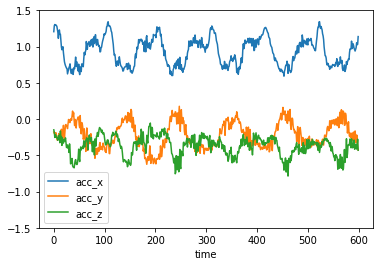

In [29]:
plot_acc_id(train, 0)
plt.ylim((-1.5, 1.5))

- 운동 reps에 따른 주기가 관측됨

(-1.5, 1.5)

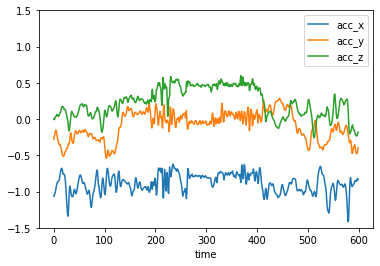

In [30]:
plot_acc_id(train, 3)
plt.ylim((-1.5, 1.5))

- 쉴 때는 움직임이 dynamic하지 않음

- 운동과 쉴 때 측정된 값 높낮이가 다를 것이며, 운동 끼리도 높낮이가 다를 것으로 추정

## 3. 데이터 전처리

In [31]:
features = ['id', 'acc_x', 'acc_y', 'acc_z', 'gy_x', 'gy_y', 'gy_z']
X_train = train[features].groupby('id').agg(['max', 'min', 'mean'])
X_test = test[features].groupby('id').agg(['max', 'min', 'mean'])

In [32]:
X_train.shape, X_test.shape, total_shift_data.shape

((3125, 18), (782, 18), (11404, 19))

In [33]:
X_train['label'] = train_label['label']

In [34]:
all_train = pd.concat([X_train,total_shift_data])

In [35]:
all_train.shape

(14529, 19)

In [36]:
all_train.head()

acc_x                         acc_y                         acc_z  \
         max       min      mean       max       min      mean       max   
id                                                                         
0   1.344268  0.591940  0.931329  0.176871 -0.624113 -0.218471 -0.054876   
1   1.234020 -2.156208 -0.766580  0.700065 -1.295598 -0.317258  0.888661   
2   1.219836 -1.142847  0.039836  0.650645 -0.690990 -0.082403  1.332992   
3  -0.622250 -1.417751 -0.887702  0.283721 -0.540827 -0.087668  0.598814   
4   0.599720 -2.429109 -0.659018  1.724782 -2.055076 -0.337067  2.678034   

                              gy_x                               gy_y  \
         min      mean         max         min       mean         max   
id                                                                      
0  -0.786336 -0.370422   31.644123  -46.254836  -1.865269   69.847244   
1  -1.019531 -0.004223  286.624363 -325.328531  11.071600  389.608060   
2   0.073846  0.626012   73.525082 -164.779067  -8.472951  297.320834   
3  -0.257124  0.227357  192.765368  -69.419166  17.744167  159.083788   
4  -1.250483  0.202758  613.972600 -769.076518  -4.819638  284.952954   

                                gy_z                       label  
           min      mean         max         min      mean        
id                                                                
0   -85.887677 -3.359506   55.953827  -79.930029  1.182107    37  
1  -315.096003  1.740475  340.170199 -270.980823  1.393294    26  
2  -249.953944  0.597877   55.642836  -44.192071  3.053291     3  
3   -82.537304  4.800931   56.456908  -85.600536 -5.869898    26  
4  -243.909948  9.651713  221.015193 -270.581913  4.453382    26

## 4. 모델링

In [37]:
from pycaret.classification import *

In [39]:
all_train.head()

acc_x                         acc_y                         acc_z  \
         max       min      mean       max       min      mean       max   
id                                                                         
0   1.344268  0.591940  0.931329  0.176871 -0.624113 -0.218471 -0.054876   
1   1.234020 -2.156208 -0.766580  0.700065 -1.295598 -0.317258  0.888661   
2   1.219836 -1.142847  0.039836  0.650645 -0.690990 -0.082403  1.332992   
3  -0.622250 -1.417751 -0.887702  0.283721 -0.540827 -0.087668  0.598814   
4   0.599720 -2.429109 -0.659018  1.724782 -2.055076 -0.337067  2.678034   

                              gy_x                               gy_y  \
         min      mean         max         min       mean         max   
id                                                                      
0  -0.786336 -0.370422   31.644123  -46.254836  -1.865269   69.847244   
1  -1.019531 -0.004223  286.624363 -325.328531  11.071600  389.608060   
2   0.073846  0.626012   73.525082 -164.779067  -8.472951  297.320834   
3  -0.257124  0.227357  192.765368  -69.419166  17.744167  159.083788   
4  -1.250483  0.202758  613.972600 -769.076518  -4.819638  284.952954   

                                gy_z                       label  
           min      mean         max         min      mean        
id                                                                
0   -85.887677 -3.359506   55.953827  -79.930029  1.182107    37  
1  -315.096003  1.740475  340.170199 -270.980823  1.393294    26  
2  -249.953944  0.597877   55.642836  -44.192071  3.053291     3  
3   -82.537304  4.800931   56.456908  -85.600536 -5.869898    26  
4  -243.909948  9.651713  221.015193 -270.581913  4.453382    26

In [41]:
all_train.shape

(14529, 19)

In [42]:
col = []
for i in range(0,18):
    tm = 'col_' + str(i)
    col.append(tm)

In [44]:
col.append('label')

In [45]:
all_train.columns = col

In [46]:
clf = setup(data = all_train, target = 'label', silent = True, session_id = 41)

Setup Succesfully Completed!


,Description,Value
0,session_id,41
1,Target Type,Multiclass
2,Label Encoded,None
3,Original Data,"(14529, 19)"
4,Missing Values,False
5,Numeric Features,18
6,Categorical Features,0
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [47]:
best_3 = compare_models(sort = 'Accuracy', n_select = 3)

IntProgress(value=0, description='Processing: ', max=178)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,18:42:47
Status,. . . . . . . . . . . . . . . . . .,Compiling Final Model
Estimator,. . . . . . . . . . . . . . . . . .,CatBoost Classifier
ETC,. . . . . . . . . . . . . . . . . .,Almost Finished


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Extra Trees Classifier,0.9971,0.0,0.9984,0.9973,0.9971,0.9971,0.9971,0.5304
1,Light Gradient Boosting Machine,0.9936,0.0,0.9978,0.9940,0.9936,0.9935,0.9935,5.7124
2,CatBoost Classifier,0.9923,0.0,0.9978,0.9929,0.9923,0.9921,0.9922,354.1495
3,Gradient Boosting Classifier,0.9889,0.0,0.9969,0.9896,0.9888,0.9886,0.9887,278.9885
4,Extreme Gradient Boosting,0.9884,0.0,0.9966,0.9892,0.9883,0.9881,0.9882,15.1326
5,Random Forest Classifier,0.9877,0.0,0.9967,0.9885,0.9876,0.9874,0.9875,0.2257
6,Decision Tree Classifier,0.9707,0.0,0.9937,0.9736,0.9694,0.9700,0.9704,0.1616
7,Quadratic Discriminant Analysis,0.9398,0.0,0.9487,0.9456,0.9399,0.9383,0.9384,0.0259
8,K Neighbors Classifier,0.8568,0.0,0.9140,0.8603,0.8401,0.8541,0.8563,0.0491
9,Naive Bayes,0.5440,0.0,0.5602,0.5649,0.5253,0.5341,0.5351,0.0117


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [ ]:
# blended = blend_models(estimator_list = best_3, fold = 5, method = 'soft')

In [ ]:
# pred_holdout = predict_model(blended)

In [ ]:
# predictions_base = predict_model(final_model, data = test)

In [ ]:
# final_model = finalize_model(blended)

In [48]:
from sklearn.ensemble import ExtraTreesClassifier

In [58]:
X_train = all_train.drop('label',1)
y_train = all_train['label']

In [59]:
xtree = ExtraTreesClassifier(random_state=42)
xtree.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=42, verbose=0,
                     warm_start=False)

In [62]:
y_pred = xtree.predict_proba(X_test)
y_pred

array([[0.  , 0.  , 0.  , ..., 0.1 , 0.  , 0.02],
       [0.01, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.01, 0.14, 0.  , ..., 0.  , 0.03, 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.01],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])

In [63]:
y_pred.shape

(782, 61)

In [64]:
submission

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,3125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3126,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3127,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3128,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3129,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,3902,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
778,3903,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
779,3904,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
780,3905,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [65]:
submission.iloc[:,1:] = y_pred
submission

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,3125,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.07,0.20,0.08,0.01,0.07,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.16,0.00,0.13,0.00,0.0,0.0,0.09,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.0,0.00,0.00,0.00,0.00,0.00,0.1,0.00,0.02
1,3126,0.01,0.00,0.00,0.00,0.01,0.01,0.00,0.01,0.0,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.02,0.00,0.01,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.82,0.01,0.0,0.0,0.00,0.00,0.00,0.00,0.01,0.02,0.00,0.00,0.00,0.0,0.01,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.01,0.00,0.0,0.00,0.00
2,3127,0.01,0.14,0.00,0.01,0.00,0.00,0.02,0.00,0.0,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.11,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.23,0.07,0.0,0.0,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.02,0.00,0.0,0.06,0.01,0.00,0.00,0.0,0.04,0.01,0.01,0.00,0.01,0.00,0.00,0.0,0.00,0.07,0.00,0.07,0.00,0.0,0.03,0.00
3,3128,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.01,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.73,0.00,0.0,0.0,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.10,0.05,0.0,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.0,0.00,0.01,0.00,0.00,0.01,0.0,0.00,0.02
4,3129,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.92,0.00,0.0,0.0,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.02,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.01,0.02,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.01,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,3902,0.00,0.00,0.00,0.00,0.08,0.02,0.00,0.01,0.0,0.02,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.02,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.74,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.01,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.0,0.01,0.00,0.00,0.00,0.01,0.0,0.01,0.00
778,3903,0.01,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.01,0.00,0.01,0.86,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.02,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.04,0.00,0.0,0.00,0.00
779,3904,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.0,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.01,0.01,0.01,0.00,0.00,0.87,0.00,0.0,0.0,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.01,0.00,0.00,0.0,0.00,0.01
780,3905,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.03,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.67,0.01,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00


In [66]:
submission.to_csv('200n_XTC.csv', index=False)

# randomforest

In [67]:
from sklearn.ensemble import RandomForestClassifier

In [68]:
model = RandomForestClassifier(n_jobs=-1, random_state=0, min_samples_leaf=30)

In [69]:
X_train

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,col_11,col_12,col_13,col_14,col_15,col_16,col_17
id,,,,,,,,,,,,,,,,,,
0,1.344268,0.591940,0.931329,0.176871,-0.624113,-0.218471,-0.054876,-0.786336,-0.370422,31.644123,-46.254836,-1.865269,69.847244,-85.887677,-3.359506,55.953827,-79.930029,1.182107
1,1.234020,-2.156208,-0.766580,0.700065,-1.295598,-0.317258,0.888661,-1.019531,-0.004223,286.624363,-325.328531,11.071600,389.608060,-315.096003,1.740475,340.170199,-270.980823,1.393294
2,1.219836,-1.142847,0.039836,0.650645,-0.690990,-0.082403,1.332992,0.073846,0.626012,73.525082,-164.779067,-8.472951,297.320834,-249.953944,0.597877,55.642836,-44.192071,3.053291
3,-0.622250,-1.417751,-0.887702,0.283721,-0.540827,-0.087668,0.598814,-0.257124,0.227357,192.765368,-69.419166,17.744167,159.083788,-82.537304,4.800931,56.456908,-85.600536,-5.869898
4,0.599720,-2.429109,-0.659018,1.724782,-2.055076,-0.337067,2.678034,-1.250483,0.202758,613.972600,-769.076518,-4.819638,284.952954,-243.909948,9.651713,221.015193,-270.581913,4.453382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2606,1.121873,-1.372177,-0.149860,0.113660,-1.772660,-0.913187,0.463209,-0.504372,-0.034071,194.732086,-179.244644,-10.456368,100.793442,-128.619308,-7.819522,121.136925,-119.308990,6.564602
2606,1.121873,-1.372177,-0.149860,0.113660,-1.772660,-0.913187,0.463209,-0.504372,-0.034071,194.732086,-179.244644,-10.456368,100.793442,-128.619308,-7.819522,121.136925,-119.308990,6.564602
2606,1.121873,-1.372177,-0.149860,0.113660,-1.772660,-0.913187,0.463209,-0.504372,-0.034071,194.732086,-179.244644,-10.456368,100.793442,-128.619308,-7.819522,121.136925,-119.308990,6.564602


In [70]:
y_train

id
0       37
1       26
2        3
3       26
4       26
        ..
2606    33
2606    33
2606    33
2606    33
2606    33
Name: label, Length: 14529, dtype: int64

In [71]:
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=30, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [72]:
y_pred = model.predict_proba(X_test)
y_pred

array([[0.        , 0.        , 0.00332143, ..., 0.08354685, 0.        ,
        0.00938042],
       [0.00632888, 0.        , 0.00267442, ..., 0.        , 0.        ,
        0.01126916],
       [0.00830964, 0.17304238, 0.00306384, ..., 0.        , 0.11315712,
        0.00488347],
       ...,
       [0.01206359, 0.        , 0.0009434 , ..., 0.        , 0.        ,
        0.00598942],
       [0.        , 0.00096774, 0.        , ..., 0.        , 0.00656804,
        0.        ],
       [0.03750845, 0.        , 0.        , ..., 0.        , 0.        ,
        0.01135712]])

In [73]:
submission

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,3125,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.07,0.20,0.08,0.01,0.07,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.16,0.00,0.13,0.00,0.0,0.0,0.09,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.0,0.00,0.00,0.00,0.00,0.00,0.1,0.00,0.02
1,3126,0.01,0.00,0.00,0.00,0.01,0.01,0.00,0.01,0.0,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.02,0.00,0.01,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.82,0.01,0.0,0.0,0.00,0.00,0.00,0.00,0.01,0.02,0.00,0.00,0.00,0.0,0.01,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.01,0.00,0.0,0.00,0.00
2,3127,0.01,0.14,0.00,0.01,0.00,0.00,0.02,0.00,0.0,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.11,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.23,0.07,0.0,0.0,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.02,0.00,0.0,0.06,0.01,0.00,0.00,0.0,0.04,0.01,0.01,0.00,0.01,0.00,0.00,0.0,0.00,0.07,0.00,0.07,0.00,0.0,0.03,0.00
3,3128,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.01,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.73,0.00,0.0,0.0,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.10,0.05,0.0,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.0,0.00,0.01,0.00,0.00,0.01,0.0,0.00,0.02
4,3129,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.92,0.00,0.0,0.0,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.02,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.01,0.02,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.01,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,3902,0.00,0.00,0.00,0.00,0.08,0.02,0.00,0.01,0.0,0.02,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.02,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.74,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.01,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.0,0.01,0.00,0.00,0.00,0.01,0.0,0.01,0.00
778,3903,0.01,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.01,0.00,0.01,0.86,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.02,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.04,0.00,0.0,0.00,0.00
779,3904,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.0,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.01,0.01,0.01,0.00,0.00,0.87,0.00,0.0,0.0,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.01,0.00,0.00,0.0,0.00,0.01
780,3905,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.03,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.67,0.01,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00


In [74]:
submission.iloc[:,1:] = y_pred
submission

,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
0,3125,0.000000,0.000000,0.003321,0.002613,0.000000,0.000000,0.000000,0.000000,0.000000,0.053033,0.145285,0.149636,0.003824,0.237331,0.026424,0.000000,0.000000,0.000000,0.000000,0.000000,0.003566,0.000000,0.006318,0.003823,0.116427,0.000000,0.038628,0.000000,0.000000,0.000000,0.026509,0.011821,0.010402,0.000000,0.000000,0.000000,0.026280,0.000000,0.008375,0.000000,0.000000,0.000000,0.005122,0.000959,0.000000,0.000000,0.000000,0.000000,0.004828,0.004743,0.000000,0.004383,0.00000,0.003824,0.000000,0.001233,0.000000,0.008365,0.083547,0.000000,0.009380
1,3126,0.006329,0.000000,0.002674,0.019681,0.013026,0.010564,0.000000,0.002722,0.001258,0.006596,0.035458,0.026406,0.000000,0.032024,0.003039,0.020528,0.007933,0.001778,0.005970,0.000000,0.070287,0.036149,0.025214,0.115190,0.003531,0.000000,0.306558,0.000000,0.000533,0.000000,0.006947,0.003868,0.010979,0.003706,0.028624,0.028657,0.010440,0.000000,0.004229,0.000000,0.003178,0.003210,0.000000,0.001489,0.000000,0.000000,0.001444,0.002007,0.013378,0.016527,0.024221,0.017164,0.00000,0.038830,0.000000,0.003837,0.000000,0.012547,0.000000,0.000000,0.011269
2,3127,0.008310,0.173042,0.003064,0.003966,0.000000,0.011000,0.019381,0.013252,0.004767,0.000000,0.002373,0.000000,0.000000,0.000000,0.000000,0.000933,0.104283,0.020803,0.000000,0.000000,0.000000,0.000000,0.000000,0.001860,0.000000,0.002014,0.033651,0.032866,0.003654,0.002716,0.000000,0.000000,0.002516,0.052026,0.005588,0.013180,0.010431,0.013692,0.000000,0.000000,0.037109,0.007232,0.004496,0.000952,0.005841,0.024136,0.010080,0.009373,0.025150,0.015311,0.001797,0.000000,0.00000,0.000000,0.064849,0.003347,0.131575,0.001341,0.000000,0.113157,0.004883
3,3128,0.009579,0.005949,0.042663,0.009936,0.000000,0.004831,0.000000,0.010930,0.001232,0.004439,0.000606,0.002576,0.000000,0.001684,0.000000,0.010306,0.014243,0.000000,0.000000,0.000000,0.003745,0.081196,0.013659,0.013158,0.005700,0.000000,0.316816,0.000000,0.004572,0.000000,0.006879,0.000833,0.009128,0.021977,0.044286,0.006248,0.011836,0.000000,0.004784,0.000492,0.000833,0.001806,0.119782,0.027405,0.000000,0.000000,0.000000,0.000000,0.006030,0.022216,0.027082,0.005519,0.00000,0.008833,0.006806,0.021939,0.003861,0.037660,0.002159,0.000000,0.043786
4,3129,0.032582,0.000000,0.000000,0.002640,0.010197,0.000423,0.000000,0.000000,0.007923,0.002453,0.004667,0.001633,0.000000,0.004000,0.000000,0.009084,0.001148,0.000000,0.003554,0.000000,0.033970,0.004111,0.018939,0.025737,0.002660,0.000000,0.704393,0.000000,0.000870,0.000000,0.000290,0.000000,0.010177,0.000000,0.017786,0.003686,0.006436,0.000000,0.000000,0.000000,0.000000,0.005714,0.000645,0.002545,0.000000,0.000000,0.001471,0.000000,0.001379,0.027351,0.038342,0.000000,0.00000,0.000000,0.000000,0.000000,0.002350,0.007920,0.000000,0.000000,0.002927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777,3902,0.014451,0.000000,0.000000,0.005389,0.151340,0.054031,0.000000,0.000968,0.000000,0.005882,0.009808,0.003607,0.000000,0.000000,0.001750,0.020416,0.003536,0.002093,0.051720,0.010910,0.024284,0.000000,0.012801,0.008269,0.005304,0.006068,0.303326,0.000000,0.000000,0.000000,0.009535,0.016112,0.013267,0.000000,0.143261,0.007743,0.000536,0.000000,0.007515,0.000000,0.006736,0.018005,0.000000,0.000000,0.001875,0.000000,0.012458,0.000000,0.002105,0.022226,0.021013,0.002037,0.00225,0.000000,0.000000,0.000000,0.007403,0.004659,0.000000,0.002291,0.003020
778,3903,0.014258,0.000000,0.000000,0.001341,0.015857,0.017849,0.001688,0.001098,0.005968,0.000000,0.003854,0.000000,0.000000,0.000000,0.000000,0.018610,0.003357,0.000000,0.032040,0.001875,0.016350,0.000000,0.004057,0.017791,0.000729,0.004

In [75]:
submission.to_csv('n200_rf.csv', index=False)